# Difference in difference

1.   Temperature
2.   Elemento de la lista



In [57]:
# All major variable sets

pre_start = pd.Timestamp("2023-04-01 00:00:00") # Same time periods for both; missing Months 2 and 3
pre_end   = pd.Timestamp("2023-12-23 23:59:59")

post_start = pd.Timestamp("2024-04-01 00:00:00")
post_end   = pd.Timestamp("2024-12-23 23:59:59")

# Temperature
start_date = "2023-04-01"
end_date = "2024-12-23"

# 1. Load Data

## 1.1 Temperature


In [58]:
import pandas as pd
import requests

def fetch_hourly_temperature(start_date, end_date, latitude=51.5074, longitude=-0.1278):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m",
        "timezone": "Europe/London"
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": pd.to_datetime(data['hourly']['time']),
        "temperature": data['hourly']['temperature_2m']
    })
    return df

# Download data for the full treatment and pre-treatment periods
df_temp = fetch_hourly_temperature(start_date, end_date)
# df_temp.to_csv("london_hourly_temperature_2023_2024.csv", index=False)
df_weather = df_temp

#df_weather['Timestamp'] = pd.to_datetime(df_weather['time'])
df_weather['Hour'] = df_weather['time'].dt.hour
df_weather['Date'] = df_weather['time'].dt.date
df_weather.head()

# 1. Filter to 4–7pm only
df_temp_peak = df_weather[df_weather['Hour'].between(16, 18)].copy()

# 2. Daily average for those hours
df_temp_daily = df_temp_peak.groupby(df_temp_peak['time'].dt.date)['temperature'].mean().reset_index()
df_temp_daily.columns = ['Date', 'Temp_4to7_avg']
df_temp_daily.head()


Date  Temp_4to7_avg
0  2023-04-01      11.333333
1  2023-04-02      11.100000
2  2023-04-03       9.933333
3  2023-04-04      12.466667
4  2023-04-05      10.900000

## 1.2 Electricity

In [59]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path(""r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare")
fin_DIR = Path("/Users/finbarrhodes/Documents/GitHub/ST498_CAPSTONE/FLASH/toShare")
none_dir = Path("")

dir = none_dir
# ----------------------------- #
#  (1)  Helpers
# ----------------------------- #
def load_half_hour_csv(fname: str) -> pd.DataFrame:
    """Read wide half‑hour file → long panel with datetime."""
    df = (pd.read_csv(dir / fname)
            .rename(columns={'Unnamed: 0': 'Time'}))
    df['Time'] = pd.to_datetime(df['Time'])
    return df.melt(id_vars='Time',
                   var_name='ANON_ID',
                   value_name='ELEC_KWH')

def tag_window(df, start, end, treat, post_flag):
    """Restrict to [start,end] & add treatment/post dummies."""
    mask = (df['Time'].between(start, end))
    out  = df.loc[mask].copy()
    out['Treatment'] = treat
    out['Post']      = post_flag
    return out

# ----------------------------- #
#  (2)  Load   PRE  (Feb‑23 → Jan‑24)
# ----------------------------- #
pre_rng   = (pre_start, pre_end)
df_pre_ctl = tag_window(load_half_hour_csv("controlePreConsolide.csv"),
                        *pre_rng, treat=0, post_flag=0)
df_pre_trt = tag_window(load_half_hour_csv("interventionPreConsolide.csv"),
                        *pre_rng, treat=1, post_flag=0)
df_pre = pd.concat([df_pre_ctl, df_pre_trt], ignore_index=True)

# ----------------------------- #
#  (3)  Load   POST  (Apr‑24 → Dec‑24)
# ----------------------------- #
post_rng  = (post_start, post_end)
df_post_ctl = tag_window(load_half_hour_csv("controleConsolide.csv"),
                         *post_rng, treat=0, post_flag=1)
df_post_trt = tag_window(load_half_hour_csv("interventionConsolide.csv"),
                         *post_rng, treat=1, post_flag=1)
df_post = pd.concat([df_post_ctl, df_post_trt], ignore_index=True)


# ----------------------------- #
#  (4)  Keep only HHs present in **both** periods
# ----------------------------- #
common_ids  = set(df_pre['ANON_ID']).intersection(df_post['ANON_ID'])
df_all = pd.concat([df_pre, df_post], ignore_index=True)
df_all = df_all[df_all['ANON_ID'].isin(common_ids)].reset_index(drop=True)

'''
# # ----------------------------- #
# #  (5)  Event‑time month index
# # ----------------------------- #
# df_all['event_month'] = (
#     (df_all['Time'].dt.to_period('M')
#       .dt.to_timestamp('M')            # last day of month
#       - pd.Timestamp('2024-04-30'))    # 0 = April‑24
#       .dt.days // 30                   # rough month diff
# )

# ----------------------------- #
#  (6)  4‑7 pm peak mean kWh
# ----------------------------- #
peak = df_all[df_all['Time'].dt.hour.between(16,18)]
peak = (peak
        .groupby(['ANON_ID','event_month','Treatment','Post'], as_index=False)
        .agg(peak_kwh=('ELEC_KWH','mean'))
        .sort_values(['ANON_ID','event_month']))
'''
# '''
peak = df_all[df_all['Time'].dt.hour.between(16,18)]
peak = (peak
        .groupby(['ANON_ID','Treatment','Post'], as_index=False)
        .agg(peak_kwh=('ELEC_KWH','mean'))
        .sort_values(['ANON_ID',]))
# '''
# Step 1: Use your `df_all` (filtered to common ANON_IDs, includes Pre & Post)
df_all['Date'] = df_all['Time'].dt.date
df_all['Hour'] = df_all['Time'].dt.hour

# Step 2: Keep 4–7pm
df_peak_all = df_all[df_all['Hour'].between(16, 18)].copy()

# Step 3: Group by Date & ANON_ID
df_peak_agg = (
    df_peak_all.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(peak_kwh=('ELEC_KWH', 'mean'))
)

# Step 4: Merge with temperature
df_peak_merged = pd.merge(df_peak_agg, df_temp_daily, on='Date', how='left')
df_peak_merged['Month'] = pd.to_datetime(df_peak_merged['Date']).dt.month
df_peak_merged['Year'] = pd.to_datetime(df_peak_merged['Date']).dt.year



print(f"\n The original shape of df_peak_merged {(df_peak_merged.shape)}")

# Ensure no missing values and correct alignment
df_peak_merged_masked = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])

print(f"\n After dropping missing values; the shape of df_peak_merged {(df_peak_merged_masked.shape)}")
print("There are some missing values in peak_kwh")
print(f"\n df_peak_merged columns: {(df_peak_merged.columns)}")


 The original shape of df_peak_merged (348444, 8)

 After dropping missing values; the shape of df_peak_merged (335741, 8)
There are some missing values in peak_kwh

 df_peak_merged columns: Index(['Date', 'ANON_ID', 'Treatment', 'Post', 'peak_kwh', 'Temp_4to7_avg',
       'Month', 'Year'],
      dtype='object')


## 1.3 Complemented Socioeconomic Data

In [60]:
# ----------------------------- #
#  Load Complemented Socioeconomic data
# ----------------------------- #

socio_df = pd.read_csv("comp_socio_df.csv")
socio_df.columns

# Keep data with socioeconomic features
common_ids_02  = set(df_peak_merged_masked['ANON_ID']).intersection(socio_df['ANON_ID'])
df_peak_merged = df_peak_merged_masked[df_peak_merged_masked['ANON_ID'].isin(common_ids_02)].reset_index(drop=True)
print(f"\n The original shape of df_peak_merged {(df_peak_merged.shape)}")

# Ensure no missing values and correct alignment
df_peak_merged_masked = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])
print(f"\n After dropping missing values; the shape of df_peak_merged {(df_peak_merged_masked.shape)}")
df_peak_merged = df_peak_merged_masked



 The original shape of df_peak_merged (299064, 8)

 After dropping missing values; the shape of df_peak_merged (299064, 8)


# 2. Dynamic Difference-in-Differences (DiD)



**Analysis using the rich panel df_peak_merged, which includes:**

*   Average consumption during 4–7pm (peak_kwh)
*   Month & year
*   Indicator 'Treatment' Intervention = 1 / Control = 0
*   Indicator 'Post' Post-treatment = 1  / Pre-treatment = 0
*   Daily temperature during the same period


In [63]:
import pandas as pd
import statsmodels.formula.api as smf



# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)


# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)


# ---------------------------
# Dynamic DiD formula:
# ---------------------------
# Base: peak_kwh ~ Treatment + Post + C(Month) + Treatment×Post×C(Month) + Temp
# We interact Post × Treatment × Month (which includes all relevant pairwise interactions)

formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']})

# ---------------------------
# View Summary
# ---------------------------
print(model.summary())

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)


                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     27.78
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           5.74e-91
Time:                        17:33:28   Log-Likelihood:                 58725.
No. Observations:              299064   AIC:                        -1.174e+05
Df Residuals:                  299035   BIC:                        -1.171e+05
Df Model:                          28                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

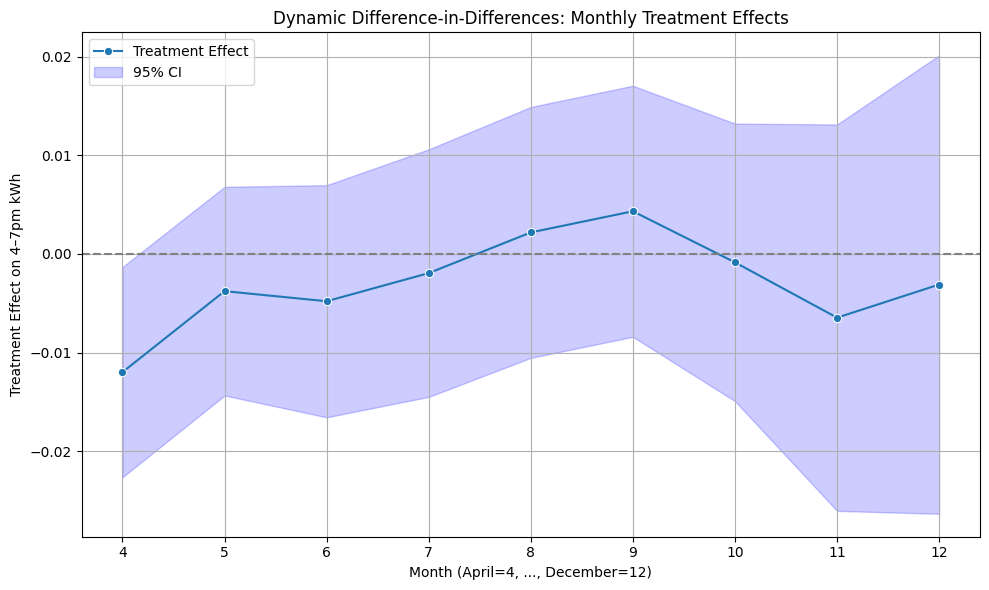

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = dynamic_did.index.str.extract(r'\[(\d+)\]')[0].dropna().astype(int)

# 3. Build dataframe for plotting
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=effect_df, x='Month', y='Effect', marker='o', label='Treatment Effect')
plt.fill_between(effect_df['Month'], effect_df['CI_lower'], effect_df['CI_upper'],
                 alpha=0.2, color='blue', label='95% CI')

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Monthly Treatment Effects")
plt.xlabel("Month (April=4, ..., December=12)")
plt.ylabel("Treatment Effect on 4–7pm kWh")
plt.xticks(ticks=range(4, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 3. Quantile Treatment Effect


In [73]:
def show_or_save_plot(filename=None):
    """Helper function to handle plot display and saving based on settings"""
    if SAVE_PLOTS and filename:
        plt.savefig(os.path.join(output_dir, filename), dpi=SAVE_DPI, bbox_inches='tight')
        print(f"✓ Saved: {filename}")

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()  # Close the plot to free memory if not showing


SHOW_PLOTS = True  # Set to True to display plots, False to only save them
SAVE_PLOTS = False  # Set to True to save plots, False to only display them

# Optional: Set DPI for saved images
SAVE_DPI = 600

## 3.1 QTE for 10 25 50 75 90 %


📈 Estimated Monthly Treatment Effects (Dynamic DiD):
Treatment:Post:C(Month)[10]   -0.000851
Treatment:Post:C(Month)[11]   -0.006458
Treatment:Post:C(Month)[12]   -0.003098
Treatment:Post:C(Month)[4]    -0.011980
Treatment:Post:C(Month)[5]    -0.003770
Treatment:Post:C(Month)[6]    -0.004792
Treatment:Post:C(Month)[7]    -0.001939
Treatment:Post:C(Month)[8]     0.002186
Treatment:Post:C(Month)[9]     0.004329
dtype: float64

Estimating quantile regression for 0.1th quantile...
QTE estimates for 0.1th quantile:
Treatment:Post:C(Month)[10]   -0.006019
Treatment:Post:C(Month)[11]   -0.001027
Treatment:Post:C(Month)[12]   -0.000079
Treatment:Post:C(Month)[4]    -0.003148
Treatment:Post:C(Month)[5]    -0.002218
Treatment:Post:C(Month)[6]    -0.001844
Treatment:Post:C(Month)[7]    -0.003545
Treatment:Post:C(Month)[8]     0.000743
Treatment:Post:C(Month)[9]    -0.000400
dtype: float64

Estimating quantile regression for 0.25th quantile...
QTE estimates for 0.25th quantile:
Treatment:Post:C(M

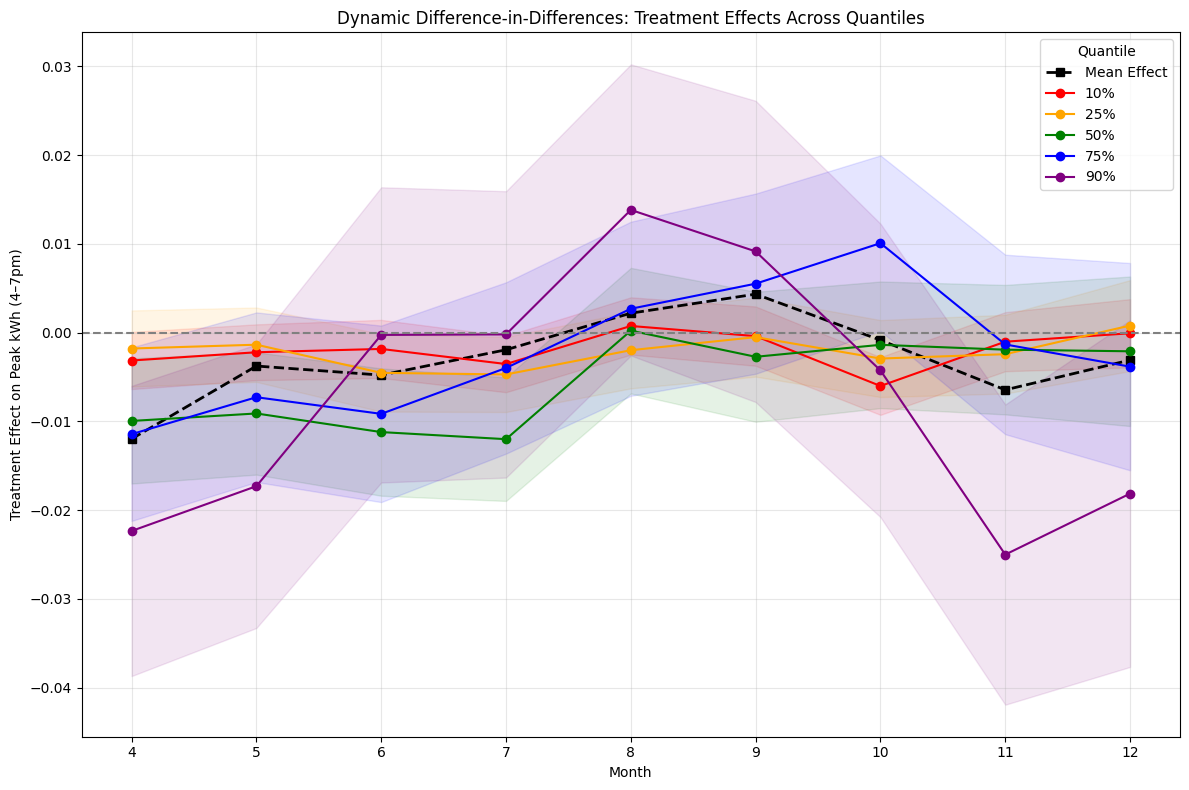

<Figure size 1500x1200 with 0 Axes>

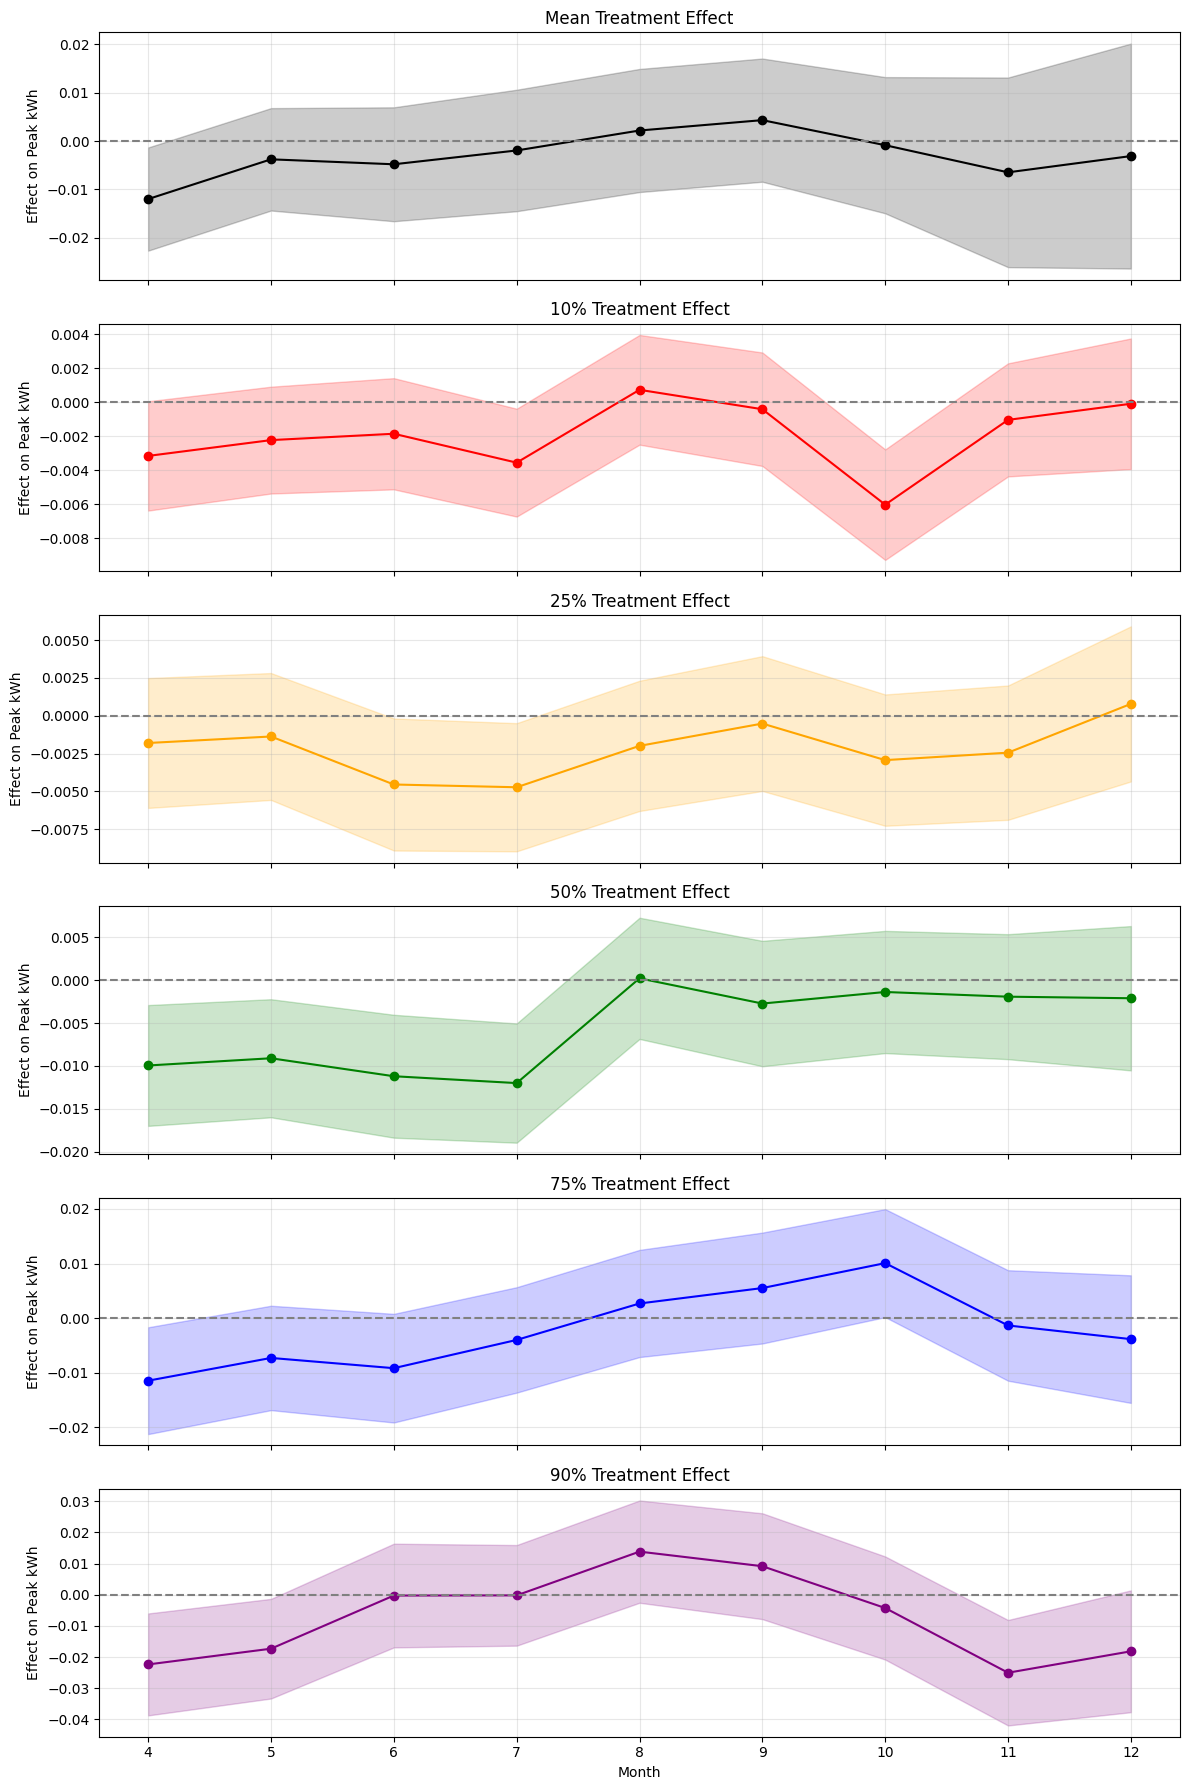

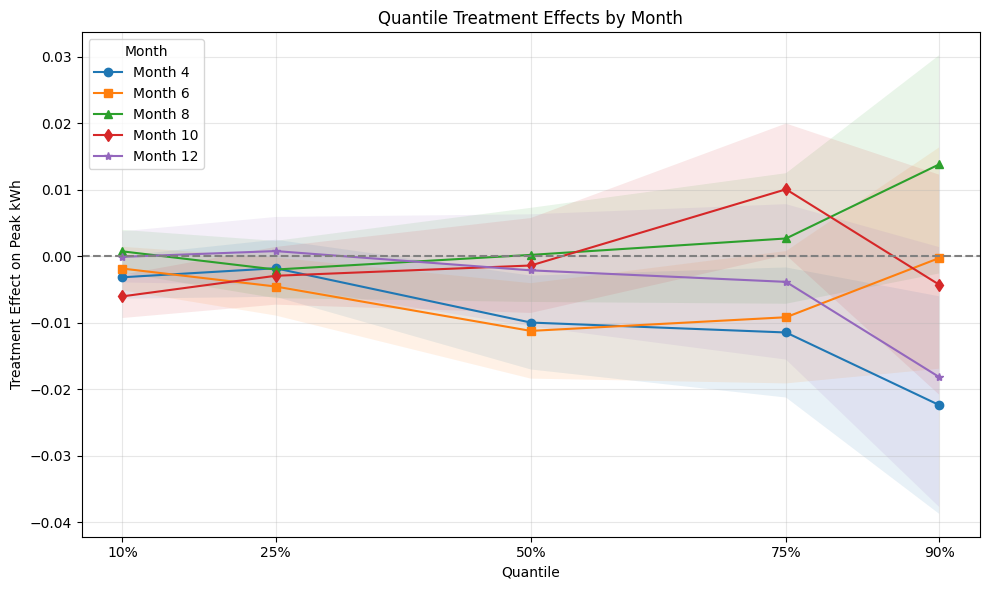

In [68]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns
import os
output_dir = 'quantile_basic_effect_plots'
os.makedirs(output_dir, exist_ok=True)

# Your initial data preparation
# Ensure no missing values and correct alignment
df_peak_merged = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])
# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# ---------------------------
# Original Dynamic DiD model
# ---------------------------
formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)
# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster',
                cov_kwds={'groups': df_peak_merged['ANON_ID']})

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n📈 Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)

# ---------------------------
# Quantile Treatment Effects
# ---------------------------
# Define the quantiles to analyze
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
colors = ['red', 'orange', 'green', 'blue', 'purple']  # Colors for different quantiles

# Create a dictionary to store QTE results
qte_results = {}

for q in quantiles:
    print(f"\nEstimating quantile regression for {q}th quantile...")

    # Use the same formula structure as the OLS model for consistency
    qr_model = QuantReg.from_formula(formula=formula, data=df_peak_merged)
    qr_fit = qr_model.fit(q=q)

    # Extract the Treatment:Post:C(Month) coefficients - same structure as OLS
    q_dynamic_terms = qr_fit.params[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]
    q_dynamic_se = qr_fit.bse[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]

    qte_results[q] = {'params': q_dynamic_terms, 'se': q_dynamic_se}

    print(f"QTE estimates for {q}th quantile:")
    print(q_dynamic_terms)

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract OLS (mean) Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = [int(m) for m in dynamic_did.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 3. Build dataframe for plotting - Mean effects
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values,
    'Quantile': 'Mean'
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Build dataframes for each quantile
qte_dfs = []
for q in quantiles:
    # Extract parameters and standard errors for this quantile
    q_params = qte_results[q]['params']
    q_se = qte_results[q]['se']

    # Extract month numbers using the same method as for mean effects
    q_months = [int(m) for m in q_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

    # Create dataframe for this quantile
    q_df = pd.DataFrame({
        'Month': q_months,
        'Effect': q_params.values,
        'SE': q_se.values,
        'Quantile': f'{int(q*100)}%'
    })
    q_df = q_df.sort_values('Month')
    q_df['CI_lower'] = q_df['Effect'] - 1.96 * q_df['SE']
    q_df['CI_upper'] = q_df['Effect'] + 1.96 * q_df['SE']

    qte_dfs.append(q_df)

# Combine all results
all_effects_df = pd.concat([effect_df] + qte_dfs, ignore_index=True)

# ---------------------------
# Create Visualizations
# ---------------------------
# Plot 1: Combined plot with all quantiles
plt.figure(figsize=(12, 8))

# Plot mean effect
mean_data = all_effects_df[all_effects_df['Quantile'] == 'Mean']
plt.plot(mean_data['Month'], mean_data['Effect'], marker='s', color='black',
         linestyle='--', linewidth=2, label='Mean Effect')

# Plot each quantile
for q, color in zip(quantiles, colors):
    q_label = f'{int(q*100)}%'
    q_data = all_effects_df[all_effects_df['Quantile'] == q_label]
    plt.plot(q_data['Month'], q_data['Effect'], marker='o', color=color, label=q_label)
    plt.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                    alpha=0.1, color=color)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects Across Quantiles")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Quantile")
plt.tight_layout()
plt.show()

# Plot 2: Facet grid with separate panel for each quantile
plt.figure(figsize=(15, 12))
unique_quantiles = all_effects_df['Quantile'].unique()
n_quantiles = len(unique_quantiles)

fig, axes = plt.subplots(nrows=n_quantiles, figsize=(12, 3*n_quantiles), sharex=True)

for i, quant in enumerate(unique_quantiles):
    ax = axes[i]
    q_data = all_effects_df[all_effects_df['Quantile'] == quant]

    # Use appropriate color (black for mean, colors for quantiles)
    color = 'black' if quant == 'Mean' else colors[i-1]

    ax.plot(q_data['Month'], q_data['Effect'], marker='o', color=color)
    ax.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')
    ax.set_title(f"{quant} Treatment Effect")
    ax.set_ylabel("Effect on Peak kWh")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '01_basic_quantile.png'), dpi=300)
plt.show()

# Plot 3: Horizontal comparison of quantile effects for selected months
# Choose a few representative months
selected_months = sorted(list(set(months)))[::2]  # Every other month

plt.figure(figsize=(10, 6))
month_markers = ['o', 's', '^', 'd', '*']

for i, month in enumerate(selected_months):
    # Get data for this month across all quantiles
    month_data = all_effects_df[all_effects_df['Month'] == month]
    # Drop the mean for this plot
    month_data = month_data[month_data['Quantile'] != 'Mean']

    # Sort by quantile value for proper ordering on x-axis
    month_data['Quantile_Value'] = month_data['Quantile'].str.rstrip('%').astype(int) / 100
    month_data = month_data.sort_values('Quantile_Value')

    # Plot
    plt.plot(month_data['Quantile_Value'], month_data['Effect'],
             marker=month_markers[i % len(month_markers)], label=f'Month {month}')
    plt.fill_between(month_data['Quantile_Value'], month_data['CI_lower'],
                     month_data['CI_upper'], alpha=0.1)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Quantile Treatment Effects by Month")
plt.xlabel("Quantile")
plt.ylabel("Treatment Effect on Peak kWh")
plt.xticks([0.1, 0.25, 0.5, 0.75, 0.9], ['10%', '25%', '50%', '75%', '90%'])
plt.grid(True, alpha=0.3)
plt.legend(title="Month")
plt.tight_layout()
plt.show()

## 3.2 QTE for 10ths quantiles

In [76]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
# Create a directory to save the plots if it doesn't exist
output_dir = 'quantile_dynamic_effect_plots'
os.makedirs(output_dir, exist_ok=True)
# Your initial data preparation
# Ensure no missing values and correct alignment
df_peak_merged = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])
# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# ---------------------------
# Original Dynamic DiD model
# ---------------------------
formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)
# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster',
                cov_kwds={'groups': df_peak_merged['ANON_ID']})

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n📈 Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)

# ---------------------------
# Quantile Treatment Effects
# ---------------------------
# Number of quantiles to analyze (you can change this to any number)
num_quantiles = 9

# Generate evenly spaced quantiles
quantiles = np.linspace(0.1, 0.9, num=num_quantiles)

# Create color map for the different quantiles
cmap = cm.get_cmap('viridis', num_quantiles)
colors = [cmap(i) for i in range(num_quantiles)]

# Create a dictionary to store QTE results
qte_results = {}

for q in quantiles:
    print(f"\nEstimating quantile regression for {q:.2f}th quantile...")

    # Use the same formula structure as the OLS model for consistency
    qr_model = QuantReg.from_formula(formula=formula, data=df_peak_merged)
    qr_fit = qr_model.fit(q=q)

    # Extract the Treatment:Post:C(Month) coefficients - same structure as OLS
    q_dynamic_terms = qr_fit.params[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]
    q_dynamic_se = qr_fit.bse[qr_fit.params.index.str.contains('Treatment:Post:C\(Month\)')]

    qte_results[q] = {'params': q_dynamic_terms, 'se': q_dynamic_se}

    print(f"QTE estimates for {q:.2f}th quantile:")
    print(q_dynamic_terms)

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract OLS (mean) Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = [int(m) for m in dynamic_did.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 3. Build dataframe for plotting - Mean effects
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values,
    'Quantile': 'Mean',
    'Quantile_Value': None
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Build dataframes for each quantile
qte_dfs = []
for q in quantiles:
    # Extract parameters and standard errors for this quantile
    q_params = qte_results[q]['params']
    q_se = qte_results[q]['se']

    # Extract month numbers using the same method as for mean effects
    q_months = [int(m) for m in q_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

    # Create dataframe for this quantile
    q_df = pd.DataFrame({
        'Month': q_months,
        'Effect': q_params.values,
        'SE': q_se.values,
        'Quantile': f'{int(q*100)}%',
        'Quantile_Value': q
    })
    q_df = q_df.sort_values('Month')
    q_df['CI_lower'] = q_df['Effect'] - 1.96 * q_df['SE']
    q_df['CI_upper'] = q_df['Effect'] + 1.96 * q_df['SE']

    qte_dfs.append(q_df)

# Combine all results
all_effects_df = pd.concat([effect_df] + qte_dfs, ignore_index=True)




📈 Estimated Monthly Treatment Effects (Dynamic DiD):
Treatment:Post:C(Month)[10]   -0.000851
Treatment:Post:C(Month)[11]   -0.006458
Treatment:Post:C(Month)[12]   -0.003098
Treatment:Post:C(Month)[4]    -0.011980
Treatment:Post:C(Month)[5]    -0.003770
Treatment:Post:C(Month)[6]    -0.004792
Treatment:Post:C(Month)[7]    -0.001939
Treatment:Post:C(Month)[8]     0.002186
Treatment:Post:C(Month)[9]     0.004329
dtype: float64

Estimating quantile regression for 0.10th quantile...


<ipython-input-76-1368547177>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', num_quantiles)


QTE estimates for 0.10th quantile:
Treatment:Post:C(Month)[10]   -0.006019
Treatment:Post:C(Month)[11]   -0.001027
Treatment:Post:C(Month)[12]   -0.000079
Treatment:Post:C(Month)[4]    -0.003148
Treatment:Post:C(Month)[5]    -0.002218
Treatment:Post:C(Month)[6]    -0.001844
Treatment:Post:C(Month)[7]    -0.003545
Treatment:Post:C(Month)[8]     0.000743
Treatment:Post:C(Month)[9]    -0.000400
dtype: float64

Estimating quantile regression for 0.20th quantile...
QTE estimates for 0.20th quantile:
Treatment:Post:C(Month)[10]   -0.002166
Treatment:Post:C(Month)[11]   -0.002915
Treatment:Post:C(Month)[12]    0.002593
Treatment:Post:C(Month)[4]    -0.001531
Treatment:Post:C(Month)[5]    -0.001585
Treatment:Post:C(Month)[6]    -0.002132
Treatment:Post:C(Month)[7]    -0.003816
Treatment:Post:C(Month)[8]    -0.003547
Treatment:Post:C(Month)[9]    -0.001644
dtype: float64

Estimating quantile regression for 0.30th quantile...
QTE estimates for 0.30th quantile:
Treatment:Post:C(Month)[10]   -0.00

<ipython-input-76-1368547177>:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_effects_df = pd.concat([effect_df] + qte_dfs, ignore_index=True)


NameError: name 'SAVE_PLOTS' is not defined

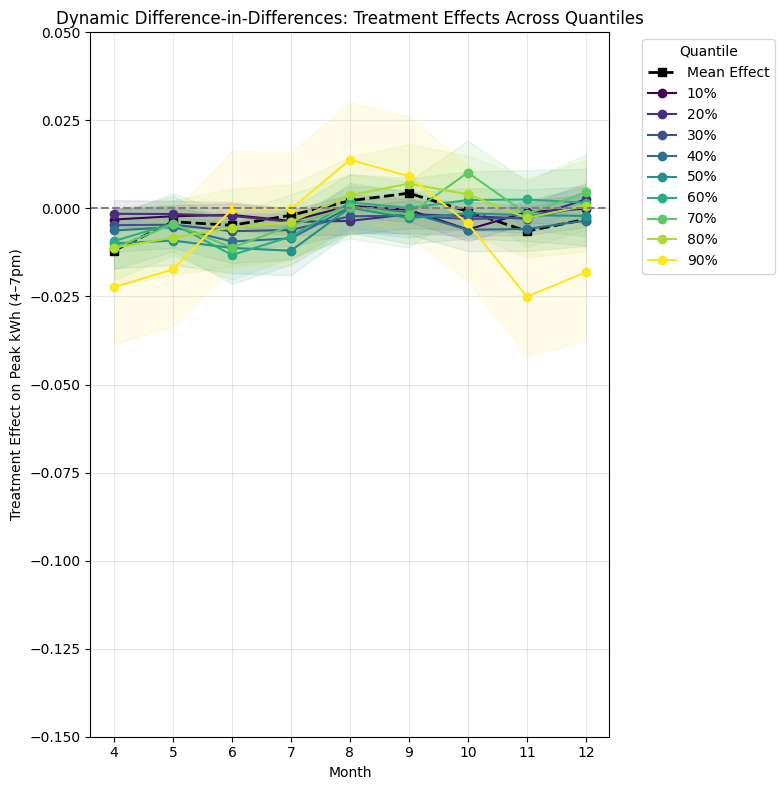

In [77]:
SAVE_PLOTS = False
# ---------------------------
# Create Visualizations for quantile plots and export (gotta run previous chunk too)
# ---------------------------
# Plot 1: Combined plot with all quantiles
plt.figure(figsize=(8, 8))

# Plot mean effect
mean_data = all_effects_df[all_effects_df['Quantile'] == 'Mean']
plt.plot(mean_data['Month'], mean_data['Effect'], marker='s', color='black',
         linestyle='--', linewidth=2, label='Mean Effect')

# Plot each quantile
for i, q in enumerate(quantiles):
    q_label = f'{int(q*100)}%'
    q_data = all_effects_df[all_effects_df['Quantile'] == q_label]
    plt.plot(q_data['Month'], q_data['Effect'], marker='o', color=colors[i], label=q_label)
    plt.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                    alpha=0.1, color=colors[i])

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects Across Quantiles")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Quantile", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylim(-0.15, 0.05)
plt.tight_layout()
show_or_save_plot('01_treatment_effects_by_months.jpg')


# Plot 2: Facet grid with separate panel for each quantile
plt.figure(figsize=(24, 2 + 2.5*num_quantiles))  # Adjust height based on number of quantiles
unique_quantiles = ['Mean'] + [f'{int(q*100)}%' for q in quantiles]
n_quantiles = len(unique_quantiles)

fig, axes = plt.subplots(nrows=n_quantiles, figsize=(8, 2 + 2*n_quantiles), sharex=True)

for i, quant in enumerate(unique_quantiles):
    ax = axes[i]
    q_data = all_effects_df[all_effects_df['Quantile'] == quant]

    # Use appropriate color (black for mean, colors for quantiles)
    color = 'black' if quant == 'Mean' else colors[i-1]

    ax.plot(q_data['Month'], q_data['Effect'], marker='o', color=color)
    ax.fill_between(q_data['Month'], q_data['CI_lower'], q_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')
    ax.set_title(f"{quant} Treatment Effect")
    ax.set_ylabel("Effect on Peak kWh")
    ax.grid(True, alpha=0.3)

    # Set the same y-axis limits for each subplot
    ax.set_ylim(-0.15, 0.05)

axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'f_01_treatment_effects_by_months.jpg'), dpi=400)
plt.show()

# Plot 3: Horizontal comparison of quantile effects for selected months
# Choose a few representative months (up to 5 for clarity)
all_months = sorted(list(set(months)))
if len(all_months) <= 5:
    selected_months = all_months
else:
    # Select evenly spaced months
    indices = np.linspace(0, len(all_months)-1, 5).astype(int)
    selected_months = [all_months[i] for i in indices]

plt.figure(figsize=(10, 8))
month_markers = ['o', 's', '^', 'd', '*']

for i, month in enumerate(selected_months):
    # Get data for this month across all quantiles
    month_data = all_effects_df[(all_effects_df['Month'] == month) &
                               (all_effects_df['Quantile'] != 'Mean')]

    # Sort by quantile value for proper ordering on x-axis
    month_data = month_data.sort_values('Quantile_Value')

    # Plot
    plt.plot(month_data['Quantile_Value'], month_data['Effect'],
             marker=month_markers[i % len(month_markers)], label=f'Month {month}')
    plt.fill_between(month_data['Quantile_Value'], month_data['CI_lower'],
                     month_data['CI_upper'], alpha=0.1)
    plt.ylim(-0.15, 0.05)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Quantile Treatment Effects by Month")
plt.xlabel("Quantile")
plt.ylabel("Treatment Effect on Peak kWh")

# Create nice looking x-tick labels based on actual quantiles
plt.xticks(quantiles, [f'{int(q*100)}%' for q in quantiles], rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title="Month")

plt.tight_layout()
show_or_save_plot('02_treatment_effects_by_quantile.png')


# Plot 4: Heatmap of treatment effects across months and quantiles
# Pivot the data for the heatmap
heatmap_data = all_effects_df[all_effects_df['Quantile'] != 'Mean'].pivot(
    index='Quantile_Value', columns='Month', values='Effect')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Heatmap: Quantiles × Months')
plt.xlabel('Month')
plt.ylabel('Quantile')
plt.tight_layout()
show_or_save_plot('03_Heatmap_combined_treatment_effects_by_quantile.jpg')


## 3.3 Socioeconomic feature: INCOME CATEGORY

In [72]:
##### import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import os

# Create a directory to save the plots if it doesn't exist
output_dir = 'income_02_treatment_effect_plots'
os.makedirs(output_dir, exist_ok=True)

# First check if INCOME_CATEGORY is in the dataset
if 'INCOME_CATEGORY' not in df_peak_merged.columns:
    # Merge with socioeconomic data if needed
    df_peak_merged = pd.merge(
        df_peak_merged,
        socio_df[['ANON_ID', 'INCOME_CATEGORY']],
        on='ANON_ID',
        how='inner'
    )

# Ensure INCOME_CATEGORY is properly categorized
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'
]
df_peak_merged['INCOME_CATEGORY'] = pd.Categorical(
    df_peak_merged['INCOME_CATEGORY'],
    categories=income_category_order,
    ordered=True
)

# Convert necessary columns to appropriate types
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# ---------------------------
# Overall Model (for reference)
# ---------------------------
overall_formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

overall_model = smf.ols(formula=overall_formula, data=df_peak_merged).fit(
    cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']}
)

# Extract overall treatment effects
overall_effects = overall_model.params[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
overall_effects_se = overall_model.bse[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

# ---------------------------
# Income Category Heterogeneity Analysis
# ---------------------------
# Store results for each income category
income_results = {}
income_categories = df_peak_merged['INCOME_CATEGORY'].cat.categories

# Use a colormap for visualizing different income categories
cmap = cm.get_cmap('viridis', len(income_categories))
colors = [cmap(i) for i in range(len(income_categories))]

# Run separate regressions for each income category
for i, income in enumerate(income_categories):
    print(f"\nAnalyzing income category: {income}")

    # Subset data for this income category
    income_data = df_peak_merged[df_peak_merged['INCOME_CATEGORY'] == income].copy()

    if len(income_data) < 100:  # Skip if sample size is too small
        print(f"  Warning: Small sample size ({len(income_data)} observations). Skipping.")
        continue

    # Use the same formula as the overall model
    try:
        income_model = smf.ols(formula=overall_formula, data=income_data).fit(
            cov_type='cluster', cov_kwds={'groups': income_data['ANON_ID']}
        )

        # Extract income-specific treatment effects
        income_effects = income_model.params[income_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
        income_effects_se = income_model.bse[income_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

        # Store results
        income_results[income] = {
            'params': income_effects,
            'se': income_effects_se,
            'n': len(income_data)
        }

        print(f"  Estimated treatment effects for {income} (n={len(income_data)}):")
        print(income_effects)

    except Exception as e:
        print(f"  Error analyzing income category {income}: {e}")

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract months from parameter names
months = [int(m) for m in overall_effects.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 2. Build dataframe for the overall effects
overall_df = pd.DataFrame({
    'Month': months,
    'Effect': overall_effects.values,
    'SE': overall_effects_se.values,
    'Category': 'Overall'
})
overall_df = overall_df.sort_values('Month')
overall_df['CI_lower'] = overall_df['Effect'] - 1.96 * overall_df['SE']
overall_df['CI_upper'] = overall_df['Effect'] + 1.96 * overall_df['SE']





<ipython-input-72-1910816063>:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(income_categories))



Analyzing income category: 0-9,999
  Estimated treatment effects for 0-9,999 (n=3915):
Treatment:Post:C(Month)[10]   -0.012735
Treatment:Post:C(Month)[11]    0.071400
Treatment:Post:C(Month)[12]    0.085810
Treatment:Post:C(Month)[4]    -0.012843
Treatment:Post:C(Month)[5]    -0.062791
Treatment:Post:C(Month)[6]    -0.027504
Treatment:Post:C(Month)[7]    -0.023636
Treatment:Post:C(Month)[8]     0.004970
Treatment:Post:C(Month)[9]    -0.067992
dtype: float64

Analyzing income category: 10,000-19,999
  Estimated treatment effects for 10,000-19,999 (n=14822):
Treatment:Post:C(Month)[10]   -0.025318
Treatment:Post:C(Month)[11]   -0.065986
Treatment:Post:C(Month)[12]   -0.066232
Treatment:Post:C(Month)[4]    -0.039370
Treatment:Post:C(Month)[5]    -0.047456
Treatment:Post:C(Month)[6]    -0.011590
Treatment:Post:C(Month)[7]    -0.017407
Treatment:Post:C(Month)[8]    -0.004330
Treatment:Post:C(Month)[9]    -0.019278
dtype: float64

Analyzing income category: 20,000-29,999
  Estimated treatme

<Figure size 800x2450 with 0 Axes>

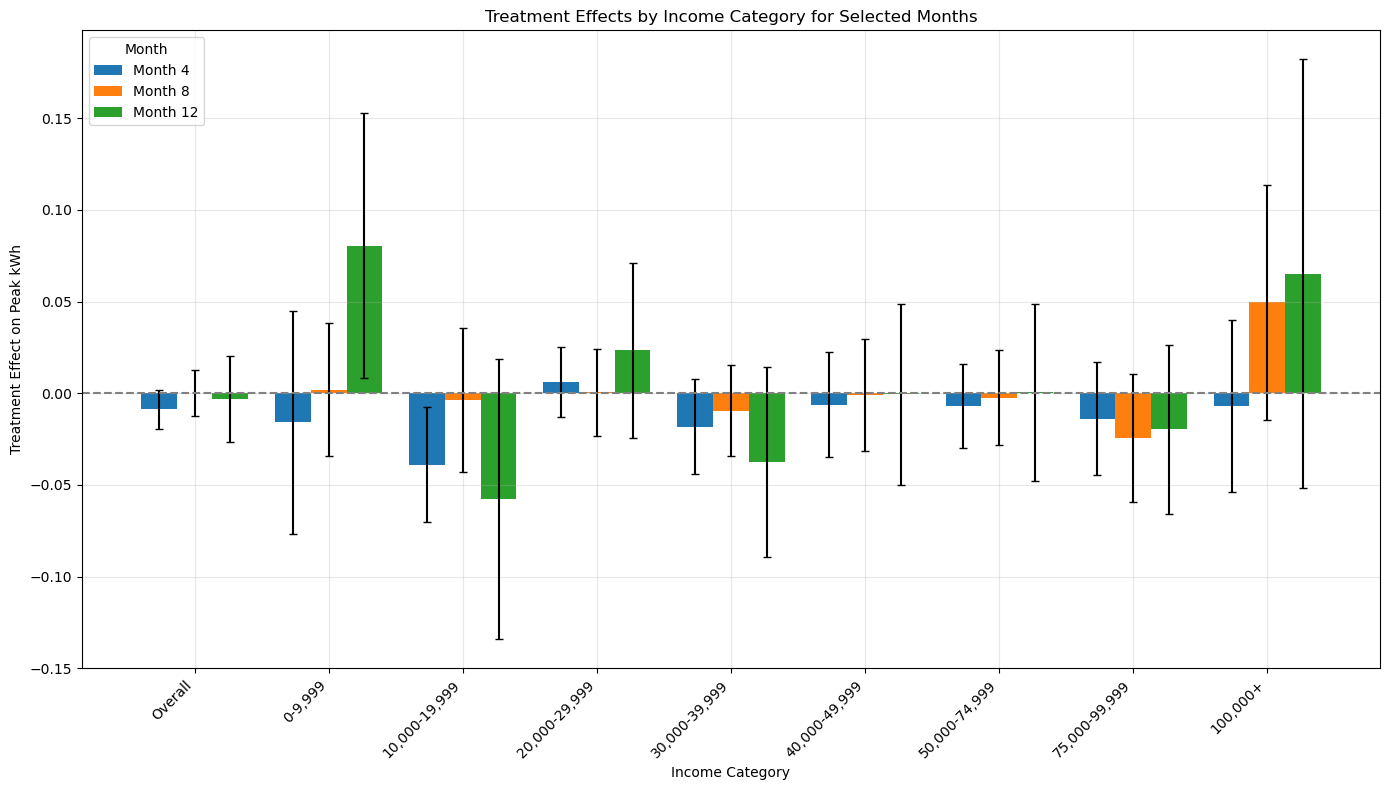

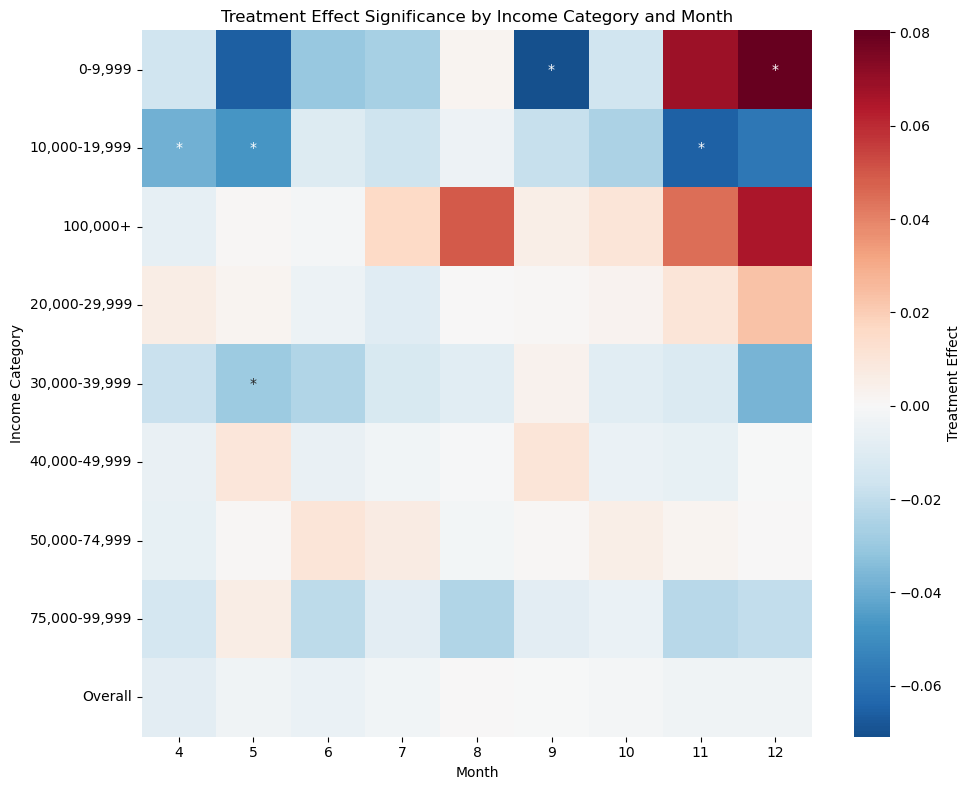

In [ ]:
# 3. Build dataframes for each income category
income_dfs = []
for income in income_results:
    # Skip if missing data
    if 'params' not in income_results[income]:
        continue

    # Extract parameters and standard errors
    income_params = income_results[income]['params']
    income_se = income_results[income]['se']

    # Extract months
    income_months = [int(m) for m in income_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

    # Create dataframe
    income_df = pd.DataFrame({
        'Month': income_months,
        'Effect': income_params.values,
        'SE': income_se.values,
        'Category': income,
        'n': income_results[income]['n']
    })
    income_df = income_df.sort_values('Month')
    income_df['CI_lower'] = income_df['Effect'] - 1.96 * income_df['SE']
    income_df['CI_upper'] = income_df['Effect'] + 1.96 * income_df['SE']

    income_dfs.append(income_df)

# Combine all results
all_effects_df = pd.concat([overall_df] + income_dfs, ignore_index=True)
# ---------------------------
# Create Visualizations
# ---------------------------
# Plot 1: Combined plot with all income categories
plt.figure(figsize=(14, 10))

# Plot overall effect
overall_data = all_effects_df[all_effects_df['Category'] == 'Overall']
plt.plot(overall_data['Month'], overall_data['Effect'], marker='s', color='black',
         linestyle='--', linewidth=2, label='Overall')

# Plot each income category
for i, income in enumerate(income_categories):
    if income not in income_results:
        continue

    income_data = all_effects_df[all_effects_df['Category'] == income]
    if len(income_data) == 0:
        continue

    plt.plot(income_data['Month'], income_data['Effect'], marker='o', color=colors[i],
             label=f'{income} (n={income_data["n"].iloc[0]})')
    plt.fill_between(income_data['Month'], income_data['CI_lower'], income_data['CI_upper'],
                    alpha=0.1, color=colors[i])

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects by Income Category")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Income Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# Save the figure instead of showing it
show_or_save_plot('01_combined_treatment_effects_by_income.jpg')
plt.close()

# Plot 2: Facet grid with separate panel for each income category
unique_categories = ['Overall'] + [cat for cat in income_categories if cat in income_results]
n_categories = len(unique_categories)

plt.figure(figsize=(8, 2 + 2.5*n_categories))
fig, axes = plt.subplots(nrows=n_categories, figsize=(8, 2 + 2*n_categories), sharex=True)

# Handle the case of only one category
if n_categories == 1:
    axes = [axes]

for i, category in enumerate(unique_categories):
    ax = axes[i]
    cat_data = all_effects_df[all_effects_df['Category'] == category]

    # Use appropriate color
    color = 'black' if category == 'Overall' else colors[list(income_categories).index(category)]

    ax.plot(cat_data['Month'], cat_data['Effect'], marker='o', color=color)
    ax.fill_between(cat_data['Month'], cat_data['CI_lower'], cat_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')

    # Add sample size for income categories
    if category != 'Overall':
        sample_size = cat_data['n'].iloc[0] if 'n' in cat_data else 'N/A'
        ax.set_title(f"{category} (n={sample_size})")
    else:
        ax.set_title("Overall")

    ax.set_ylabel("Effect on Peak kWh")
        # Set the same y-axis limits for each subplot
    ax.set_ylim(-0.15, 0.05)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Month")
plt.tight_layout()
# plt.show()
# -----------------
plt.savefig(os.path.join(output_dir, 'final_02_combined_treatment_effects_by_income.jpg'), dpi=400)
plt.close()

# Plot 3: Bar chart comparing treatment effects across income categories for selected months
# Choose a few representative months
all_months = sorted(list(set(months)))
if len(all_months) <= 3:
    selected_months = all_months
else:
    # Select beginning, middle, and end months
    selected_months = [all_months[0], all_months[len(all_months)//2], all_months[-1]]

plt.figure(figsize=(14, 8))

# For each selected month, plot a grouped bar chart
x_positions = np.arange(len(unique_categories))
width = 0.8 / len(selected_months)  # Width of each bar

for i, month in enumerate(selected_months):
    # Offset for this month's group of bars
    offset = (i - len(selected_months)/2 + 0.5) * width

    # Collect effects for this month across categories
    effects = []
    ci_lower = []
    ci_upper = []

    for category in unique_categories:
        month_cat_data = all_effects_df[(all_effects_df['Month'] == month) &
                                      (all_effects_df['Category'] == category)]

        if len(month_cat_data) > 0:
            effect = month_cat_data['Effect'].iloc[0]
            lower = month_cat_data['CI_lower'].iloc[0]
            upper = month_cat_data['CI_upper'].iloc[0]
        else:
            effect = np.nan
            lower = np.nan
            upper = np.nan

        effects.append(effect)
        ci_lower.append(lower)
        ci_upper.append(upper)

    # Plot bars for this month
    bars = plt.bar(x_positions + offset, effects, width, label=f'Month {month}')

    # Add error bars
    plt.errorbar(x_positions + offset, effects,
                yerr=[np.array(effects) - np.array(ci_lower),
                      np.array(ci_upper) - np.array(effects)],
                fmt='none', color='black', capsize=3)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Treatment Effects by Income Category for Selected Months")
plt.xlabel("Income Category")
plt.ylabel("Treatment Effect on Peak kWh")
plt.xticks(x_positions, unique_categories, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title="Month")
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(output_dir, '03_combined_treatment_effects_by_income.jpg'), dpi=400)
# plt.close()

# Plot 4: Heatmap of treatment effects across months and income categories
# Pivot the data for the heatmap
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Heatmap: Income Categories × Months')
plt.xlabel('Month')
plt.ylabel('Income Category')
plt.tight_layout()
# Save the figure instead of showing it
plt.savefig(os.path.join(output_dir, '04_Heatmap_combined_treatment_effects_by_income.jpg'), dpi=400)
plt.close()

# Plot 5: Display significance patterns
plt.figure(figsize=(10, 8))

# Create a DataFrame with significance markers
sig_data = all_effects_df.copy()
sig_data['Significant'] = np.where(
    (sig_data['CI_lower'] > 0) | (sig_data['CI_upper'] < 0),
    '*',  # Significant effect
    ''    # Not significant
)

# Pivot for heatmap
sig_heatmap = sig_data.pivot(
    index='Category', columns='Month', values='Significant')

# Create a heatmap with significance markers
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=sig_heatmap, fmt='s',
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Significance by Income Category and Month')
plt.xlabel('Month')
plt.ylabel('Income Category')
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(output_dir, '05_Heatmap_combined_treatment_effects_by_income.jpg'), dpi=400)
#plt.close()

## 3.4 QTE for Cluster

In [114]:
#df_analysis = df_analysis.drop(columns='Cluster')
df_analysis # Must not have 'Cluster' column

Date                                            ANON_ID  \
0       2023-04-01  0045034694b28ba56978092fc4dd601c58774fd74c30b7...   
1       2023-04-01  01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...   
2       2023-04-01  01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...   
3       2023-04-01  029cf457eace7f2a0ed8f55912f926ba9855f3748a117f...   
4       2023-04-01  034d4493bbb8bd1ae4b7496160610c6a2ab00100a79a7c...   
...            ...                                                ...   
299059  2024-12-23  fce880311d169db0eb15bd50e4c62479772d37ea2f2dfa...   
299060  2024-12-23  fd78d9fb0a9035c6a9fe2704c7dcbca1b9add8ea63bf0e...   
299061  2024-12-23  fef90b0143496f6e158ba9db416049340d590648659fc6...   
299062  2024-12-23  ffba8412c38b3152abbf790a602f70ccea9313ab717d42...   
299063  2024-12-23  ffc18ddbae03457b7e1e62be04cd244c699f54530c6dcb...   

        Treatment  Post  peak_kwh  Temp_4to7_avg Month  Year INCOME_CATEGORY  
0               1     0  0.383500      11.333333     4  2023   40,000-49,999  
1               0     0  0.217333      11.333333     4  2023        100,000+  
2               1     0  0.155167      11.333333     4  2023   50,000-74,999  
3               0     0  0.218167      11.333333     4  2023   20,000-29,999  
4               0     0  0.669833      11.333333     4  2023        100,000+  
...           ...   ...       ...            ...   ...   ...             ...  
299059          1     1  0.204167       5.600000    12  2024   10,000-19,999  
299060          0     1  0.296000       5.600000    12  2024   20,000-29,999  
299061          0     1  2.056167       5.600000    12  2024        100,000+  
299062          1     1  0.857000       5.600000    12  2024        100,000+  
299063          0     1  0.158167       5.600000    12  2024   50,000-74,999  

[299064 rows x 9 columns]

Found 16 clustering methodologies:
  - Cluster_Comp04_k02
  - Cluster_Comp04_k03
  - Cluster_Comp04_k04
  - Cluster_Comp04_k05
  - Cluster_Comp04_k06
  - Cluster_Comp04_k07
  - Cluster_Comp04_k08
  - Cluster_Comp04_k09
  - Cluster_Comp06_k02
  - Cluster_Comp06_k03
  - Cluster_Comp06_k04
  - Cluster_Comp06_k05
  - Cluster_Comp06_k06
  - Cluster_Comp06_k07
  - Cluster_Comp06_k08
  - Cluster_Comp06_k09

Processing 16 cluster configurations...

Processing: 4C_2K (Cluster_Comp04_k02)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k02' unique values: [np.float64(0.0), np.float64(1.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0 (n=2)
  Cluster 0.0: n=84228, effects estimated for 9 months
  Cluster 1.0: n=214836, effects estimated for 9 months


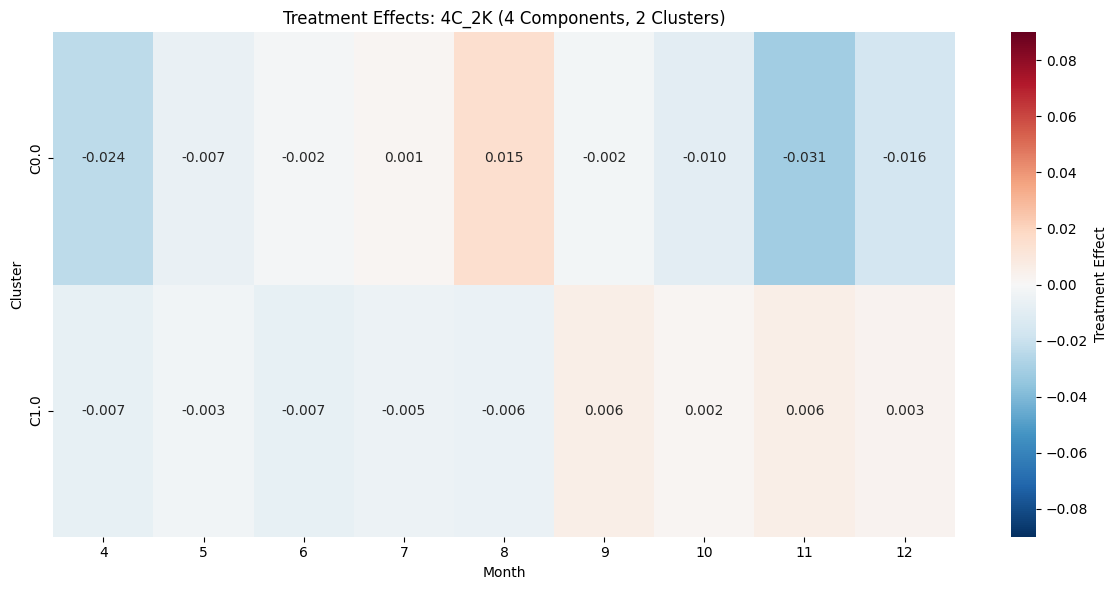

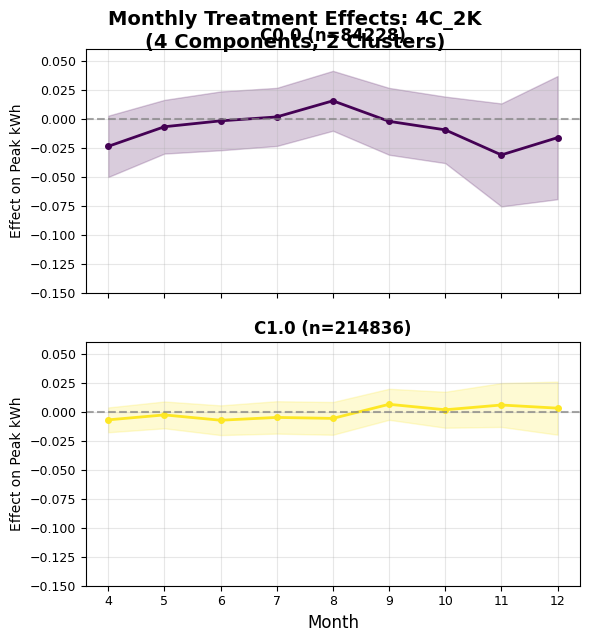


Processing: 4C_3K (Cluster_Comp04_k03)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k03' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0 (n=3)
  Cluster 0.0: n=186271, effects estimated for 9 months
  Cluster 1.0: n=73794, effects estimated for 9 months
  Cluster 2.0: n=38999, effects estimated for 9 months


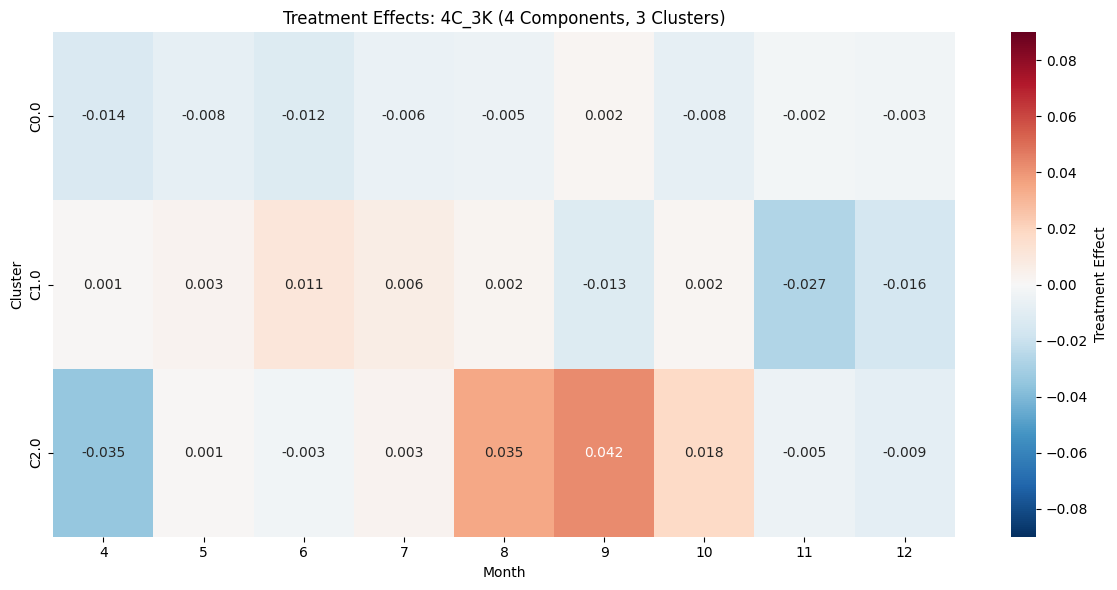

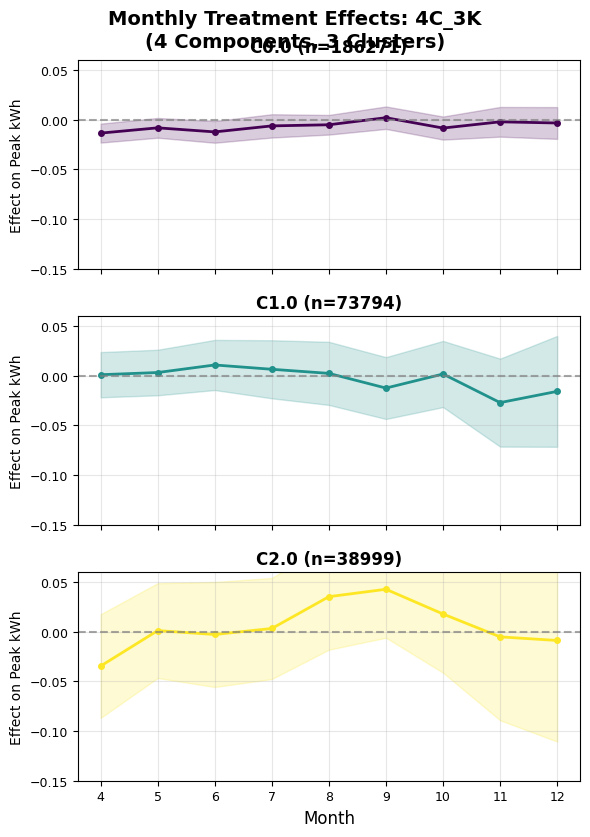


Processing: 4C_4K (Cluster_Comp04_k04)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k04' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0 (n=4)
  Cluster 0.0: n=158163, effects estimated for 9 months
  Cluster 1.0: n=65716, effects estimated for 9 months
  Cluster 2.0: n=34977, effects estimated for 9 months
  Cluster 3.0: n=40208, effects estimated for 9 months


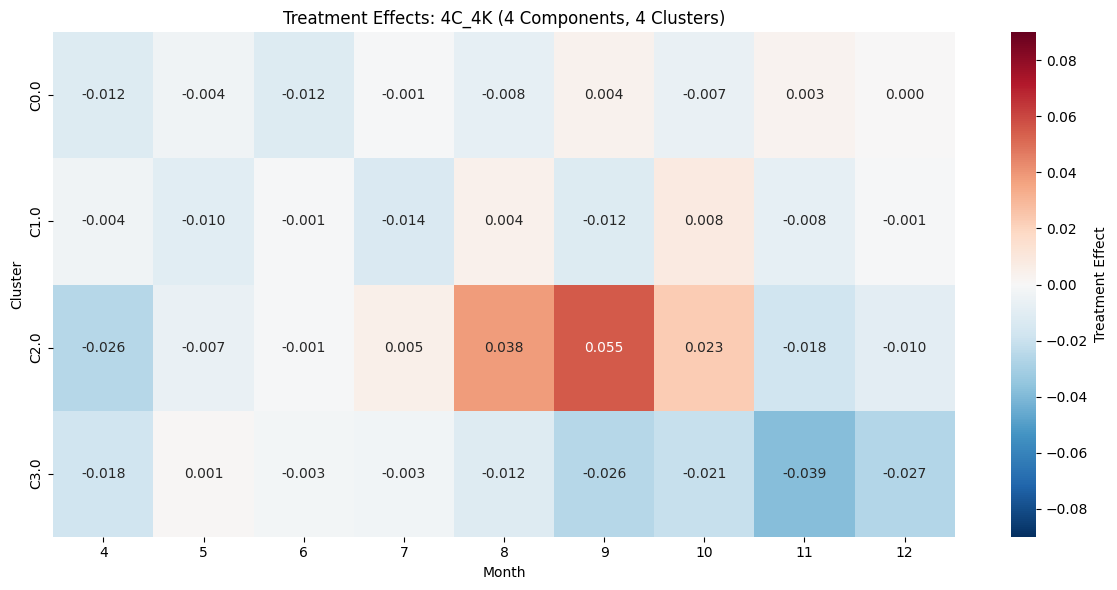

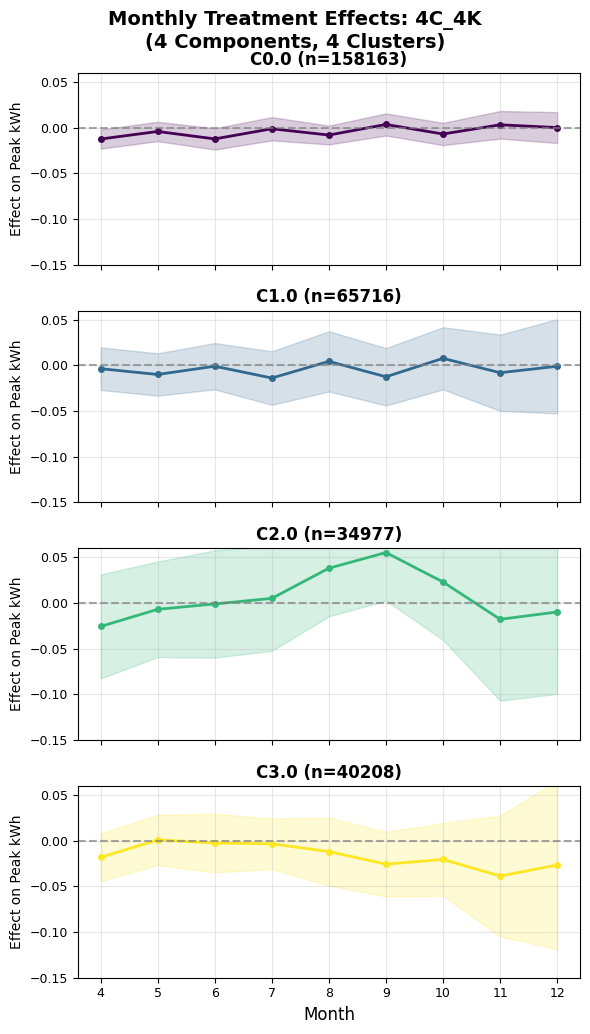


Processing: 4C_5K (Cluster_Comp04_k05)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k05' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0 (n=5)
  Cluster 0.0: n=27561, effects estimated for 9 months
  Cluster 1.0: n=126971, effects estimated for 9 months
  Cluster 2.0: n=52316, effects estimated for 9 months
  Cluster 3.0: n=37352, effects estimated for 9 months
  Cluster 4.0: n=54864, effects estimated for 9 months


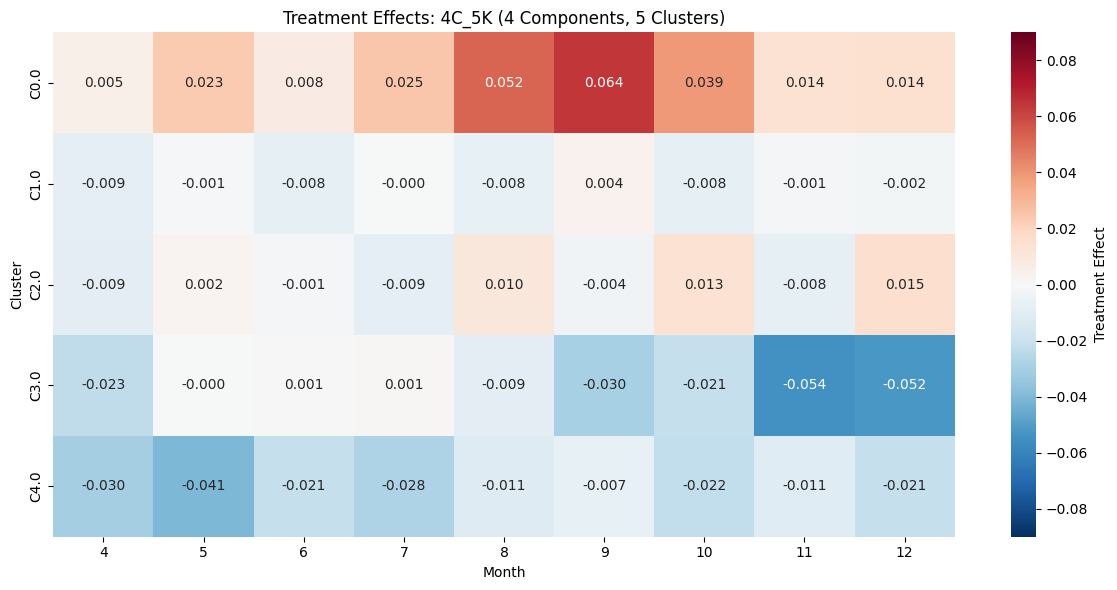

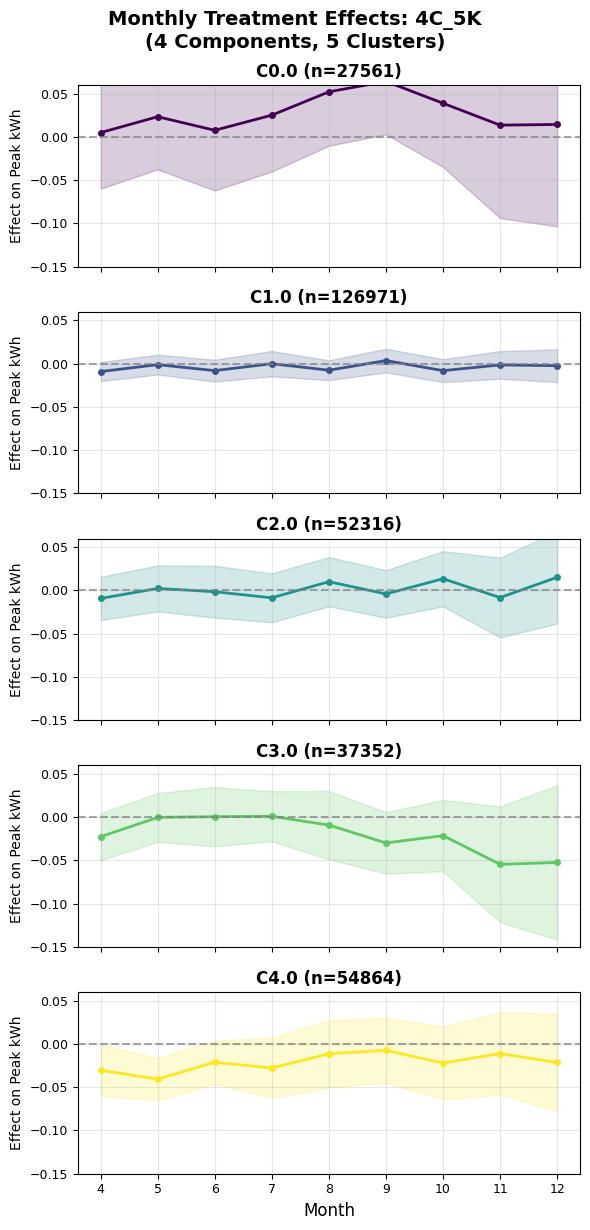


Processing: 4C_6K (Cluster_Comp04_k06)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k06' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0 (n=6)
  Cluster 0.0: n=129278, effects estimated for 9 months
  Cluster 1.0: n=55920, effects estimated for 9 months
  Cluster 2.0: n=34114, effects estimated for 9 months
  Cluster 3.0: n=6854, effects estimated for 9 months
  Cluster 4.0: n=18274, effects estimated for 9 months
  Cluster 5.0: n=54624, effects estimated for 9 months


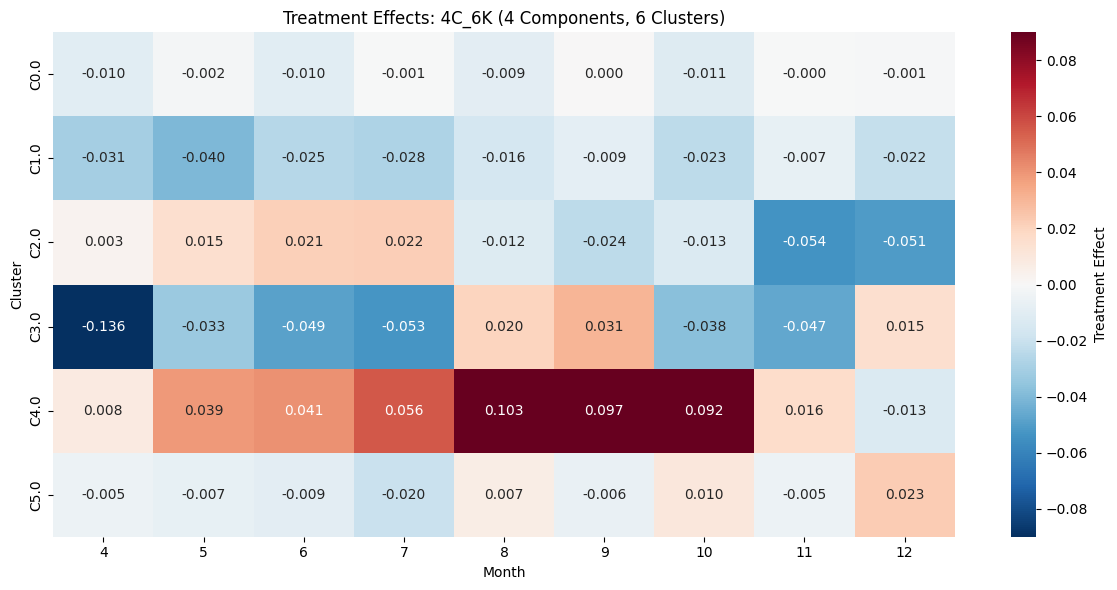

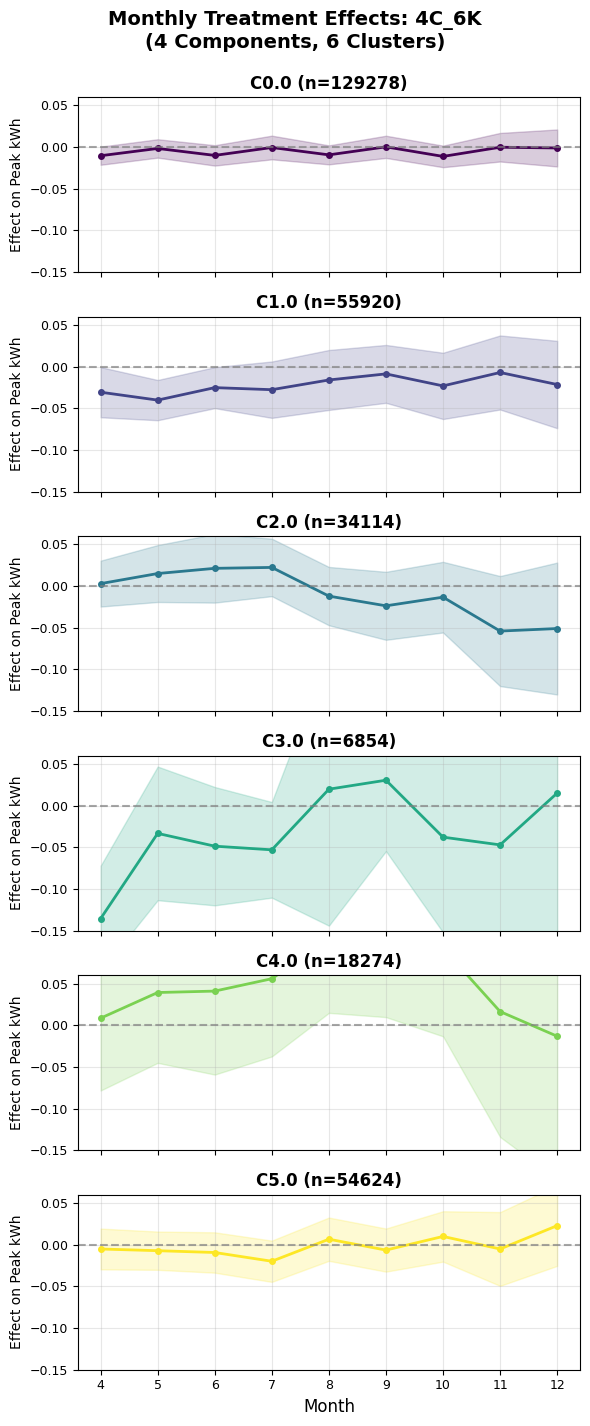


Processing: 4C_7K (Cluster_Comp04_k07)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k07' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0 (n=7)
  Cluster 0.0: n=119810, effects estimated for 9 months
  Cluster 1.0: n=58258, effects estimated for 9 months
  Cluster 2.0: n=46506, effects estimated for 9 months
  Cluster 3.0: n=19984, effects estimated for 9 months
  Cluster 4.0: n=12661, effects estimated for 9 months
  Cluster 5.0: n=6362, effects estimated for 9 months
  Cluster 6.0: n=35483, effects estimated for 9 months


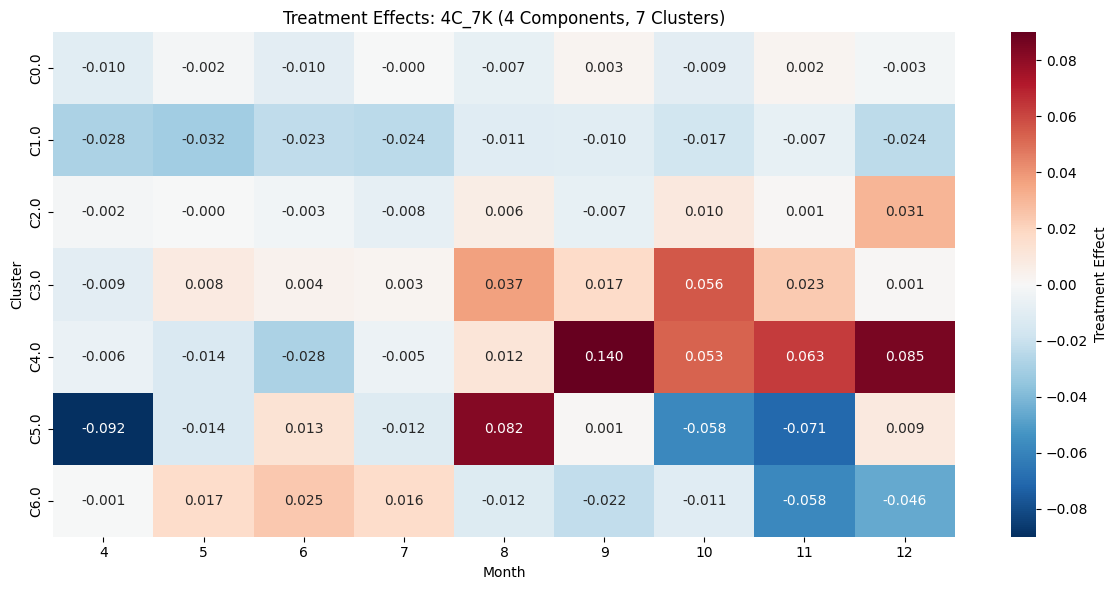

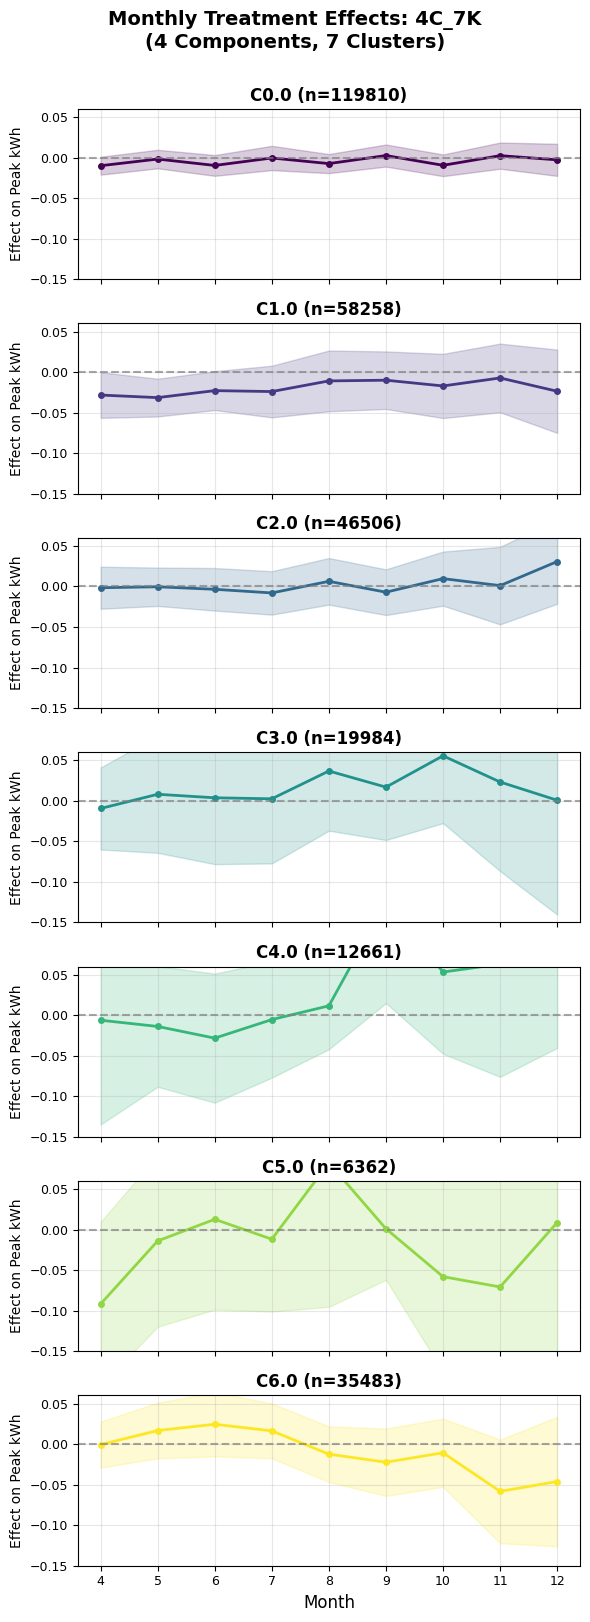


Processing: 4C_8K (Cluster_Comp04_k08)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k08' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0 (n=8)
  Cluster 0.0: n=31121, effects estimated for 9 months
  Cluster 1.0: n=106418, effects estimated for 9 months
  Cluster 2.0: n=14586, effects estimated for 9 months
  Cluster 3.0: n=20714, effects estimated for 9 months
  Cluster 4.0: n=6364, effects estimated for 9 months
  Cluster 5.0: n=51039, effects estimated for 9 months
  Cluster 6.0: n=52307, effects estimated for 9 months
  Cluster 7.0: n=16515, effects estimated for 9 months


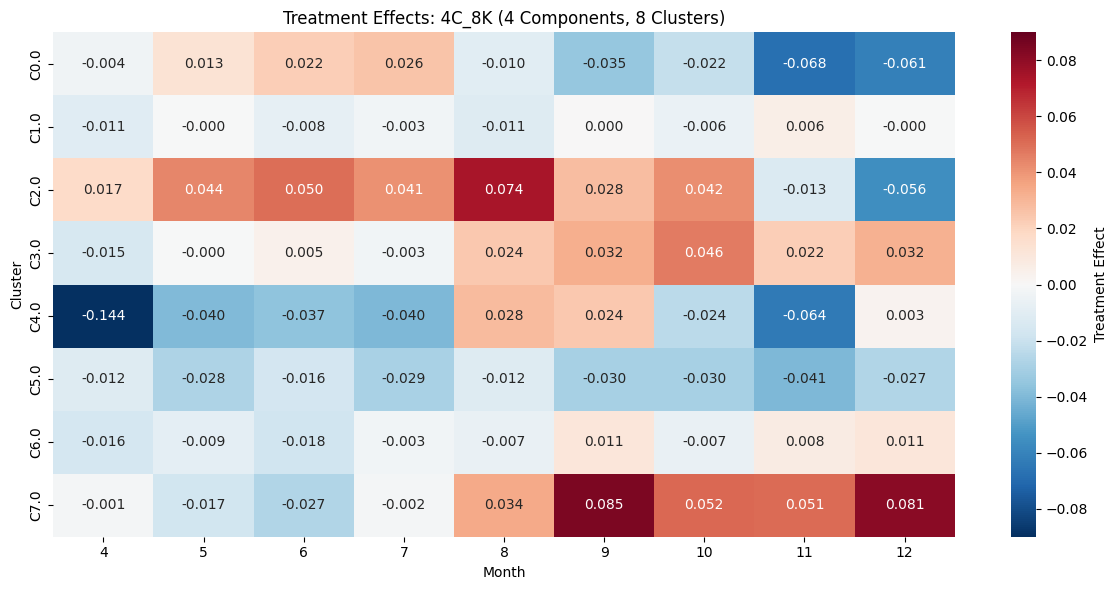

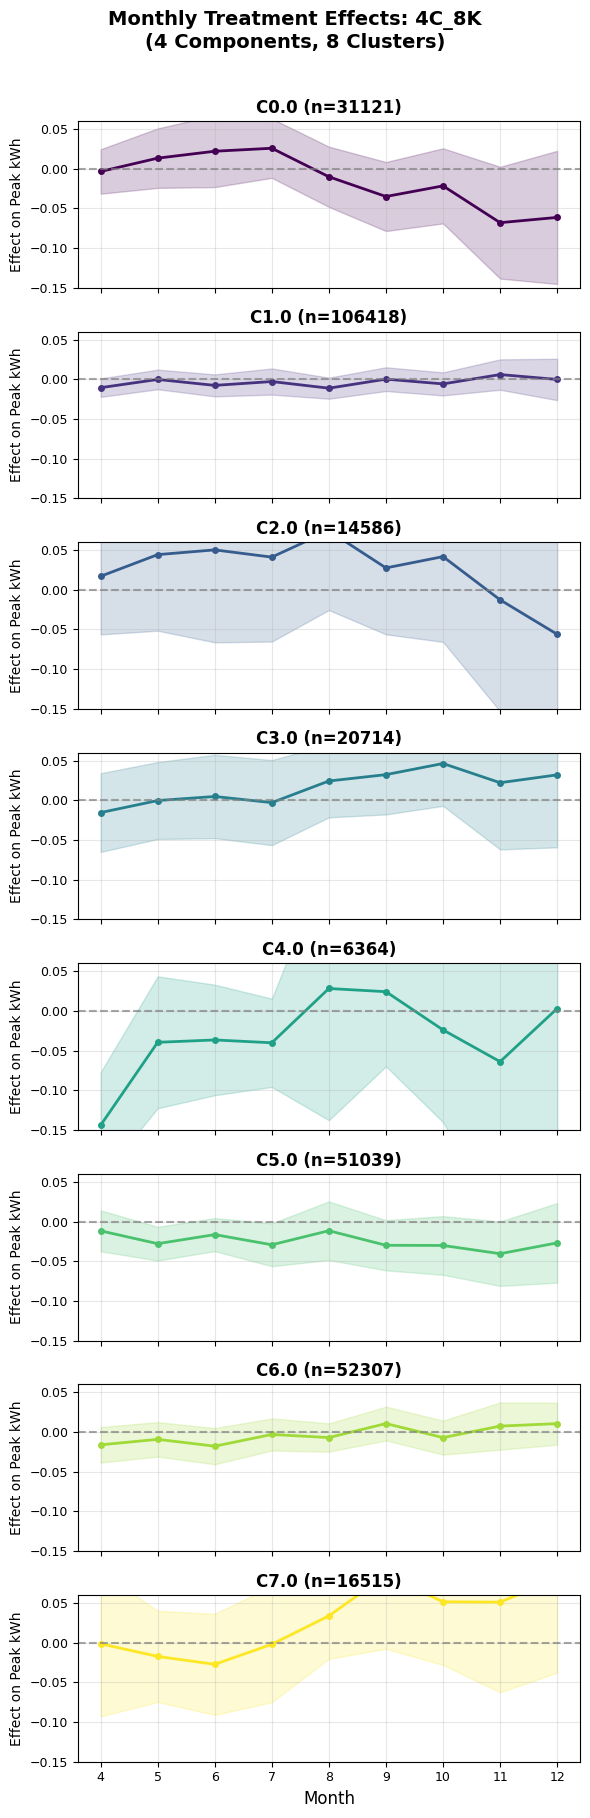


Processing: 4C_9K (Cluster_Comp04_k09)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp04_k09' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0 (n=9)
  Cluster 0.0: n=16542, effects estimated for 9 months
  Cluster 1.0: n=94024, effects estimated for 9 months
  Cluster 2.0: n=55047, effects estimated for 9 months
  Cluster 3.0: n=11692, effects estimated for 9 months
  Cluster 4.0: n=42362, effects estimated for 9 months
  Cluster 5.0: n=7340, effects estimated for 9 months
  Cluster 6.0: n=8729, effects estimated for 9 months
  Cluster 7.0: n=14872, effects estimated for 9 months
  Cluster 8.0: n=48456, effects estimated for 9 months


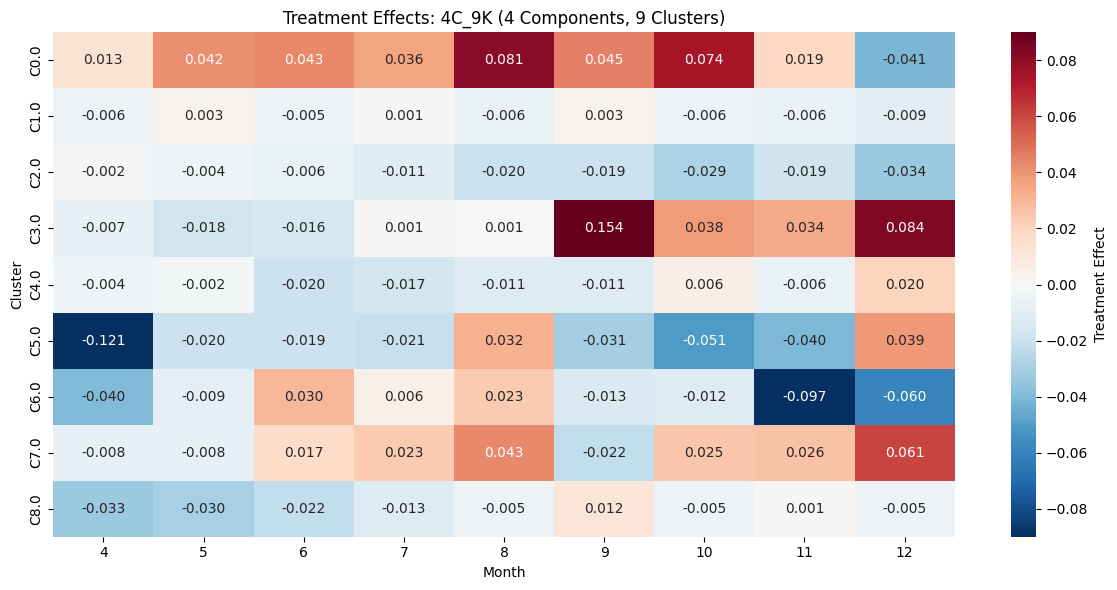

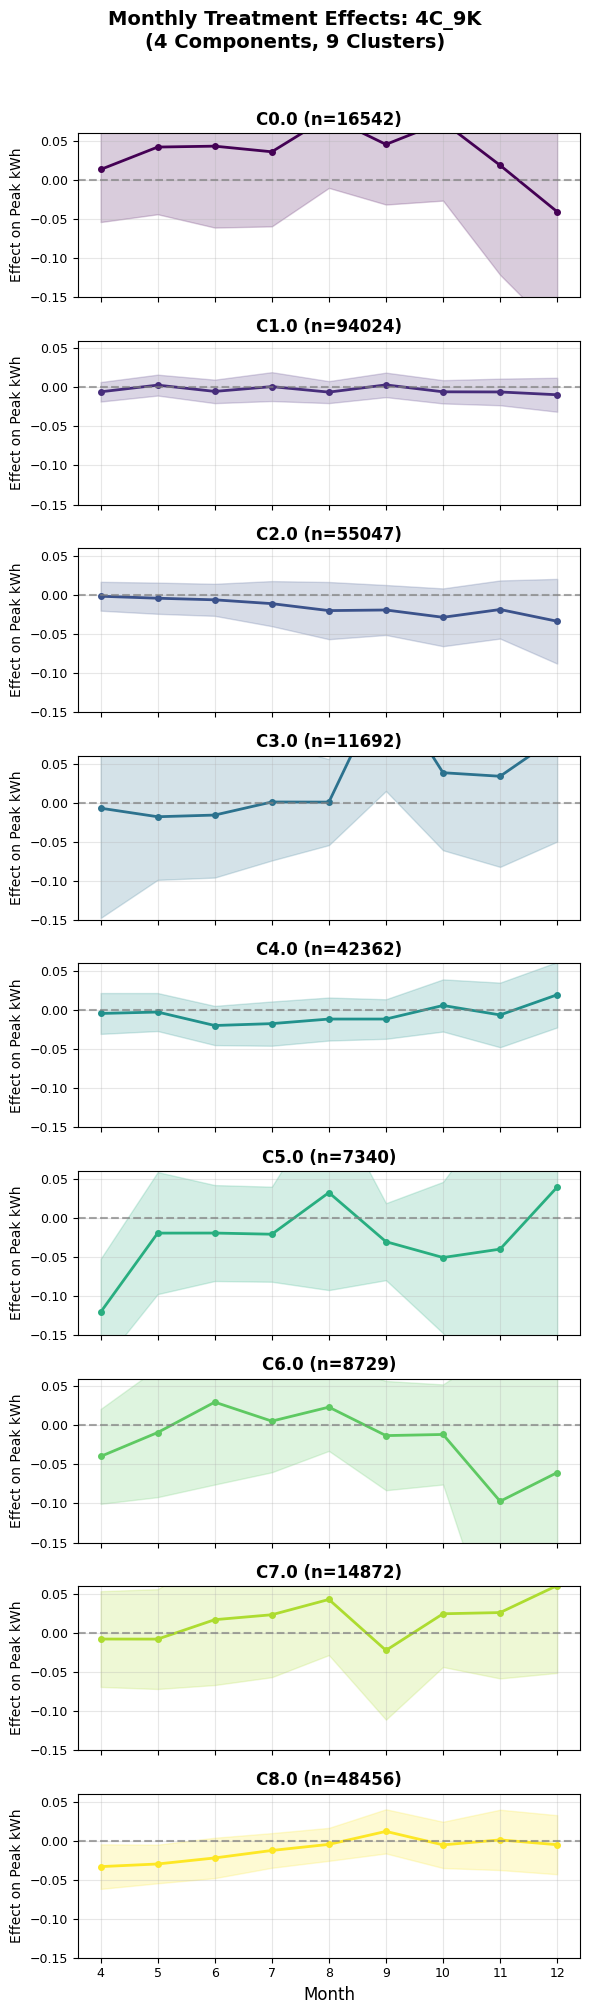


Processing: 6C_2K (Cluster_Comp06_k02)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k02' unique values: [np.float64(0.0), np.float64(1.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0 (n=2)
  Cluster 0.0: n=233915, effects estimated for 9 months
  Cluster 1.0: n=65149, effects estimated for 9 months


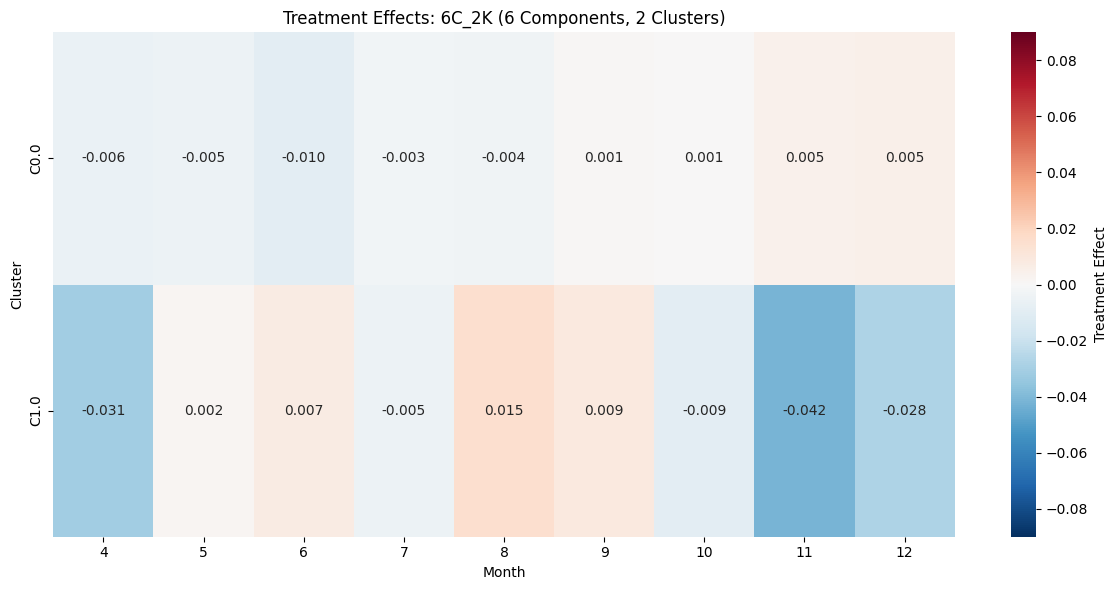

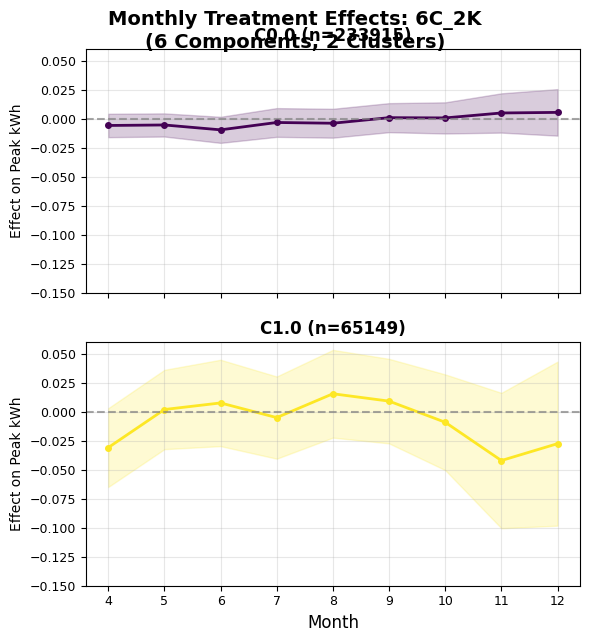


Processing: 6C_3K (Cluster_Comp06_k03)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k03' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0 (n=3)
  Cluster 0.0: n=171934, effects estimated for 9 months
  Cluster 1.0: n=48832, effects estimated for 9 months
  Cluster 2.0: n=78298, effects estimated for 9 months


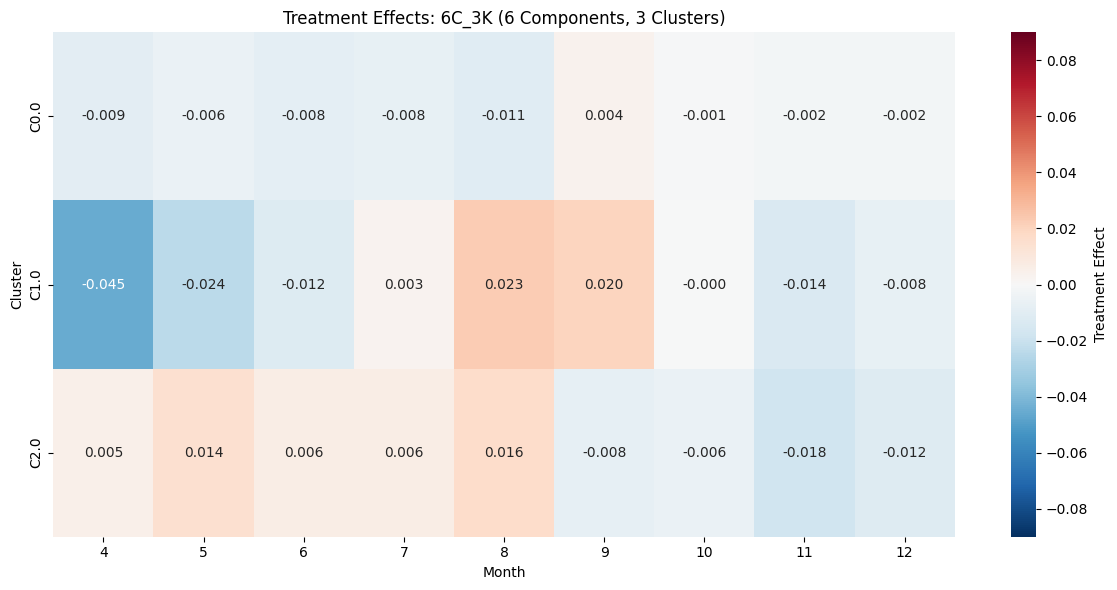

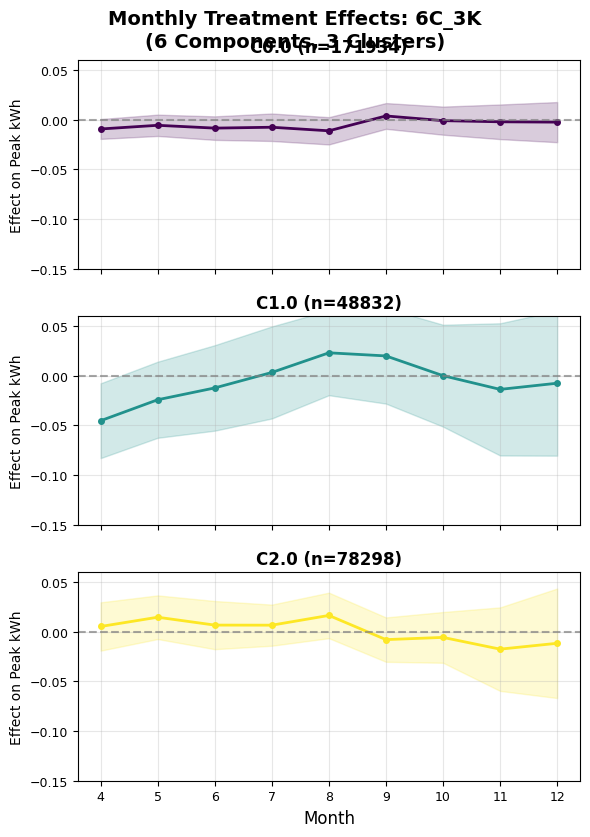


Processing: 6C_4K (Cluster_Comp06_k04)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k04' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0 (n=4)
  Cluster 0.0: n=31088, effects estimated for 9 months
  Cluster 1.0: n=139027, effects estimated for 9 months
  Cluster 2.0: n=62349, effects estimated for 9 months
  Cluster 3.0: n=66600, effects estimated for 9 months


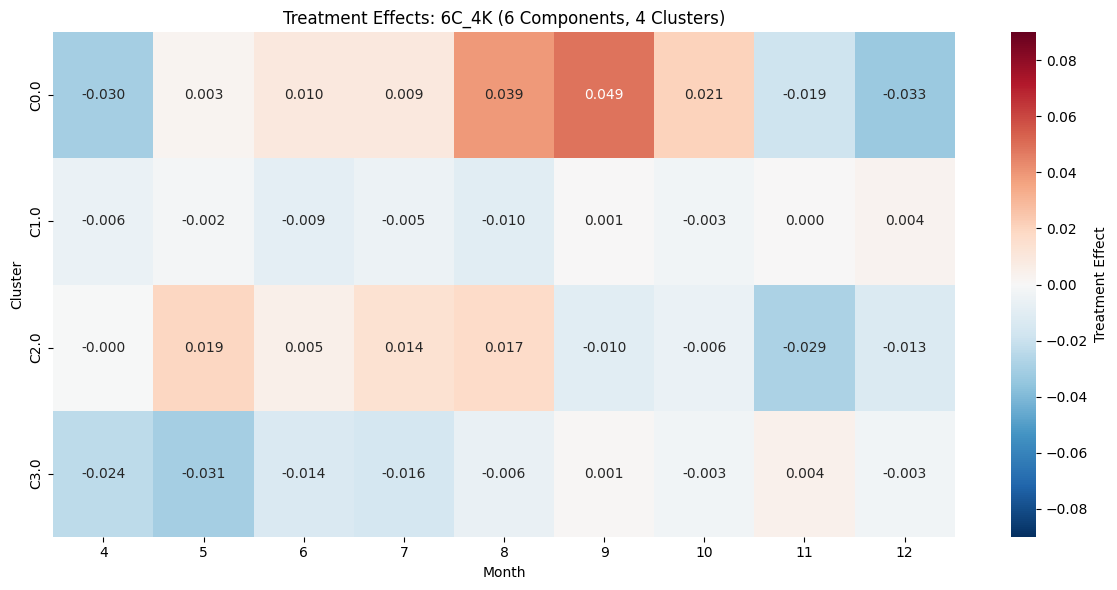

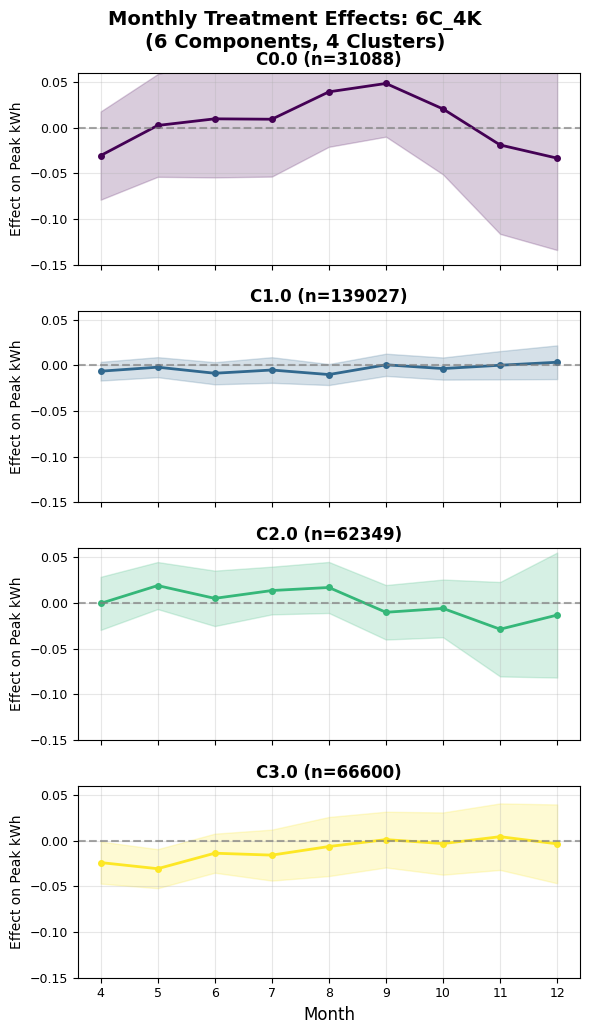


Processing: 6C_5K (Cluster_Comp06_k05)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k05' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0 (n=5)
  Cluster 0.0: n=128591, effects estimated for 9 months
  Cluster 1.0: n=21961, effects estimated for 9 months
  Cluster 2.0: n=34572, effects estimated for 9 months
  Cluster 3.0: n=65889, effects estimated for 9 months
  Cluster 4.0: n=48051, effects estimated for 9 months


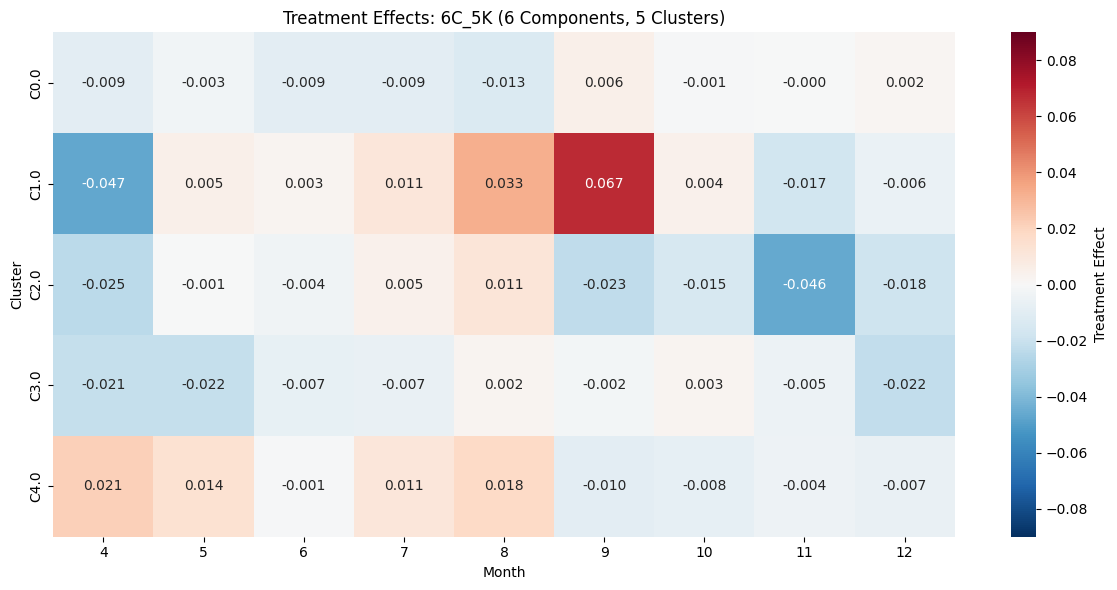

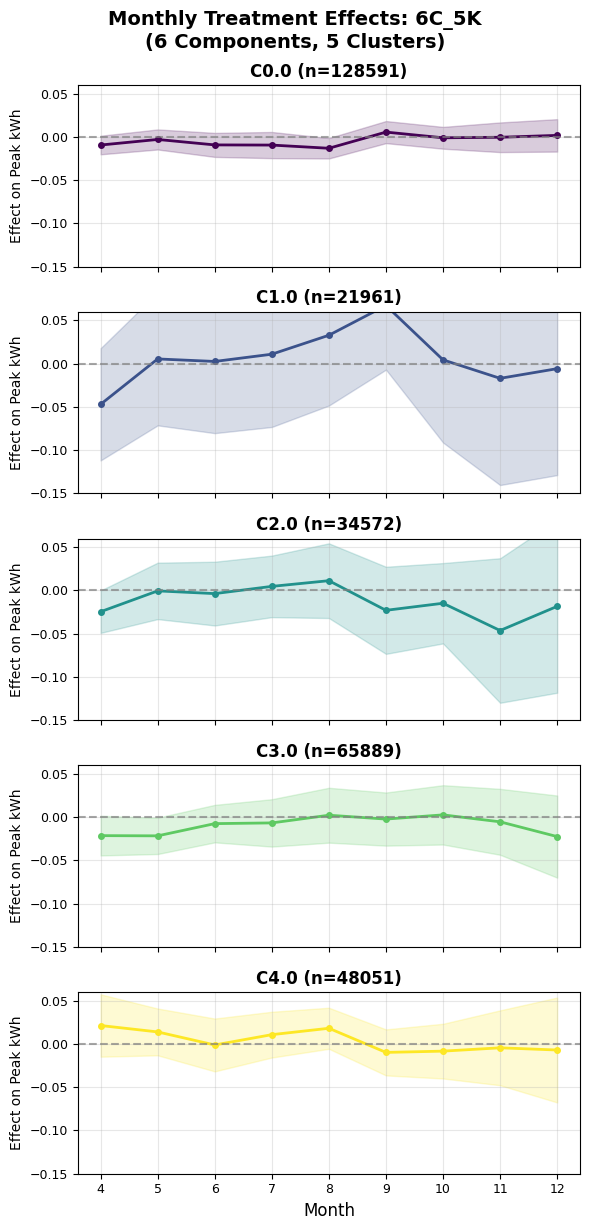


Processing: 6C_6K (Cluster_Comp06_k06)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k06' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0 (n=6)
  Cluster 0.0: n=15415, effects estimated for 9 months
  Cluster 1.0: n=115080, effects estimated for 9 months
  Cluster 2.0: n=29477, effects estimated for 9 months
  Cluster 3.0: n=42511, effects estimated for 9 months
  Cluster 4.0: n=54012, effects estimated for 9 months
  Cluster 5.0: n=42569, effects estimated for 9 months


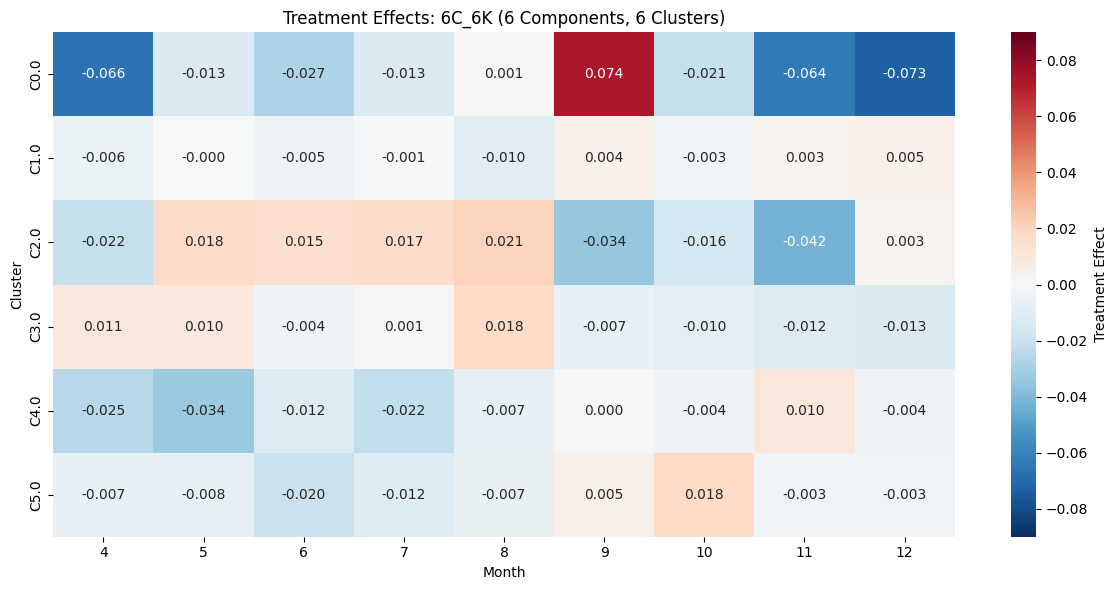

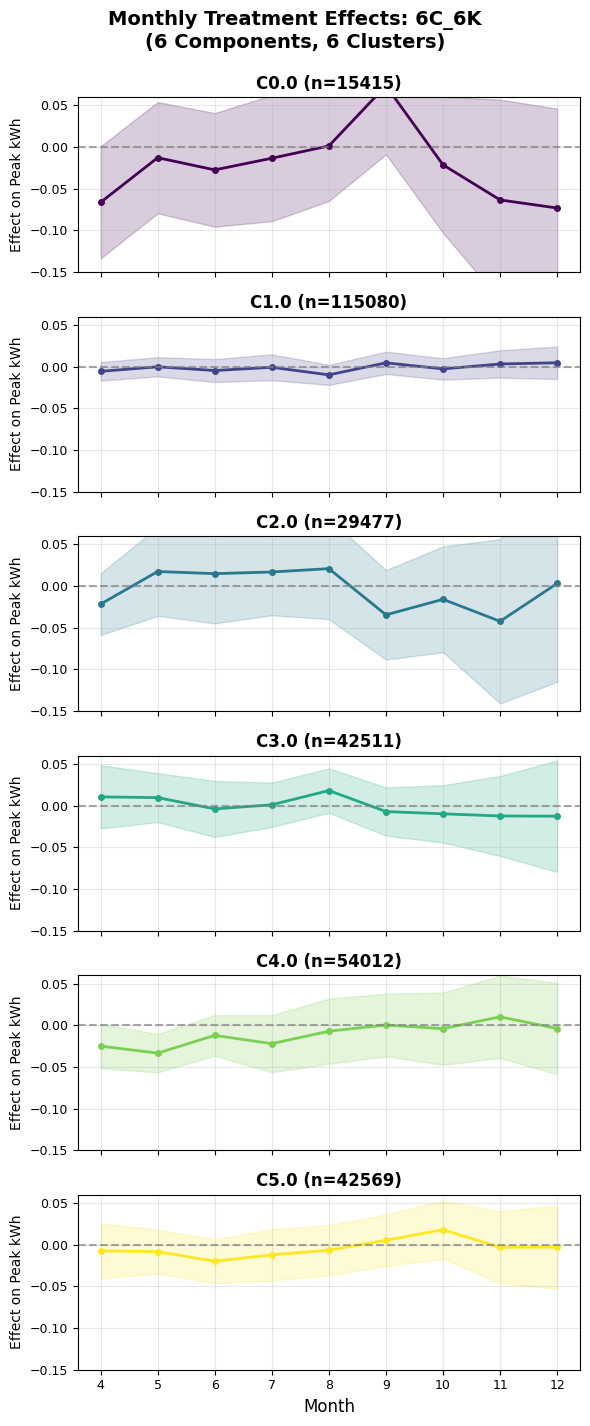


Processing: 6C_7K (Cluster_Comp06_k07)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k07' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0 (n=7)
  Cluster 0.0: n=115006, effects estimated for 9 months
  Cluster 1.0: n=19677, effects estimated for 9 months
  Cluster 2.0: n=28037, effects estimated for 9 months
  Cluster 3.0: n=40065, effects estimated for 9 months
  Cluster 4.0: n=45455, effects estimated for 9 months
  Cluster 5.0: n=42003, effects estimated for 9 months
  Cluster 6.0: n=8821, effects estimated for 9 months


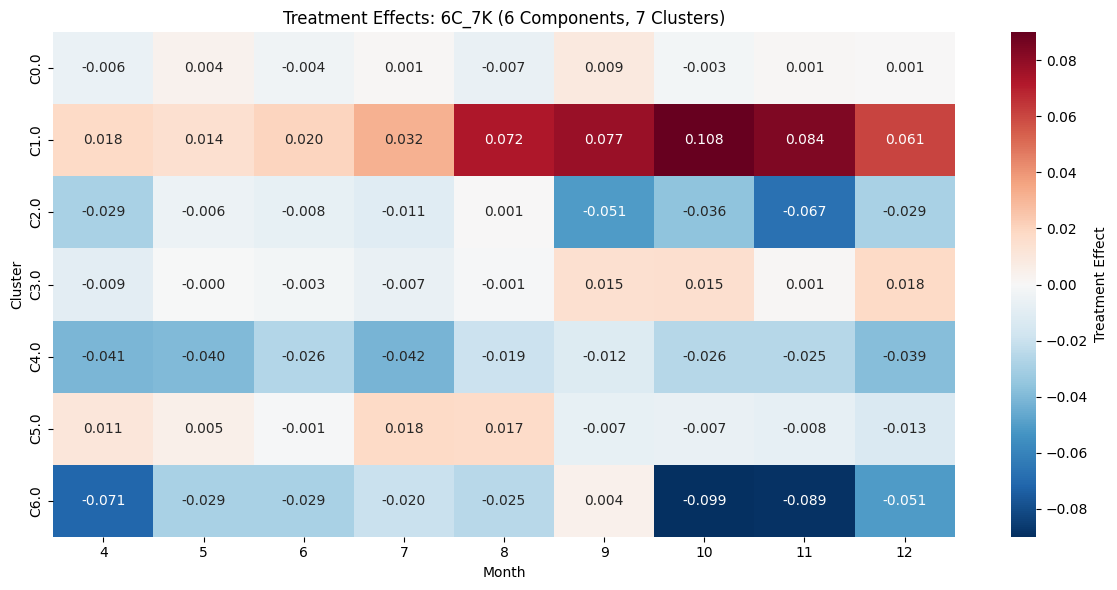

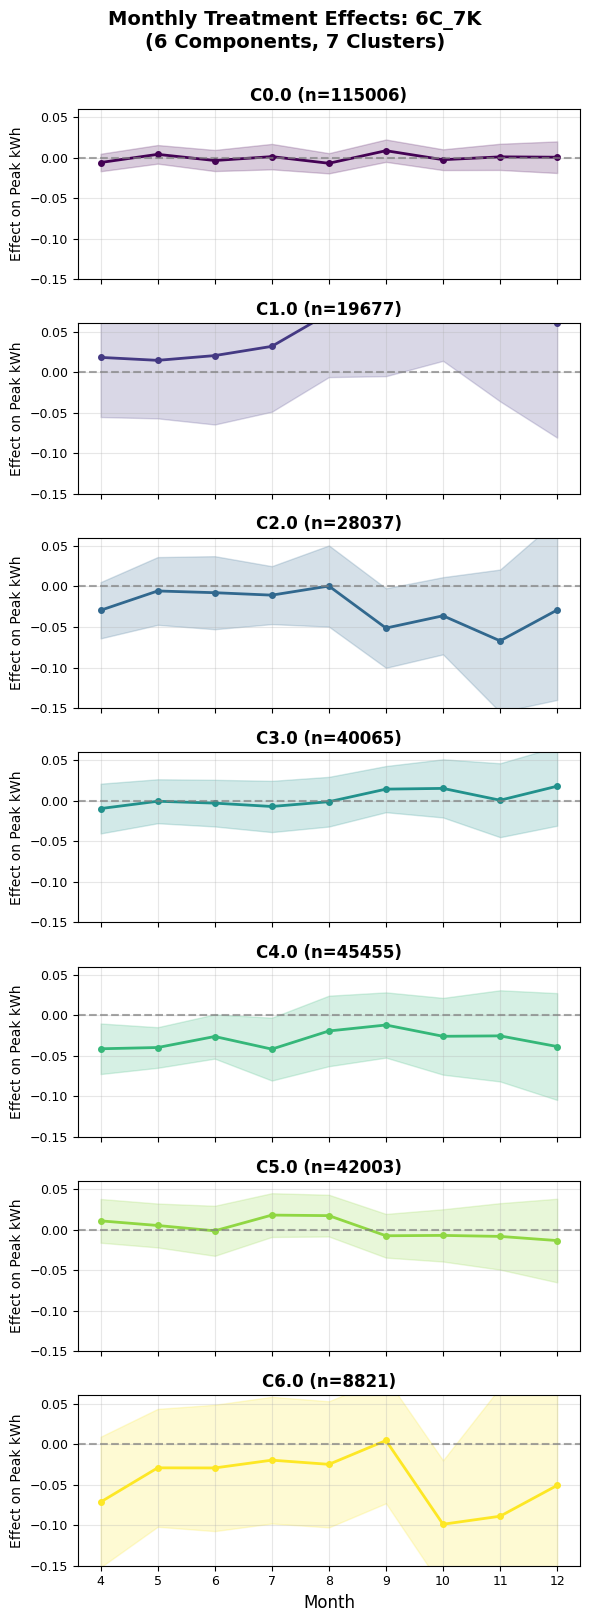


Processing: 6C_8K (Cluster_Comp06_k08)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k08' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0 (n=8)
  Cluster 0.0: n=35731, effects estimated for 9 months
  Cluster 1.0: n=23575, effects estimated for 9 months
  Cluster 2.0: n=96149, effects estimated for 9 months
  Cluster 3.0: n=37564, effects estimated for 9 months
  Cluster 4.0: n=27934, effects estimated for 9 months
  Cluster 5.0: n=57388, effects estimated for 9 months
  Cluster 6.0: n=4408, effects estimated for 9 months
  Cluster 7.0: n=16315, effects estimated for 9 months


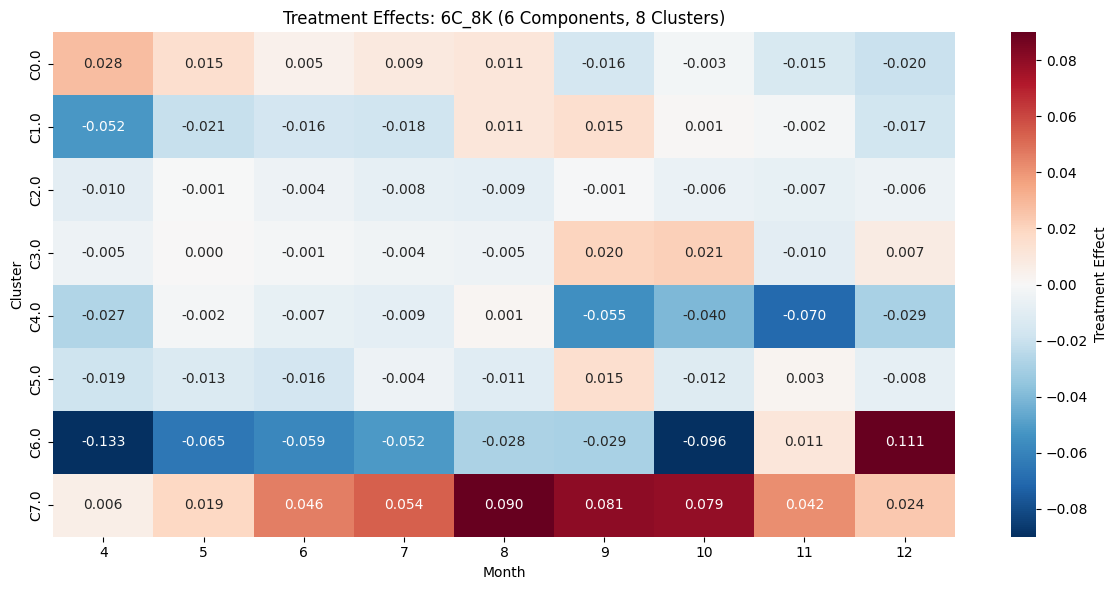

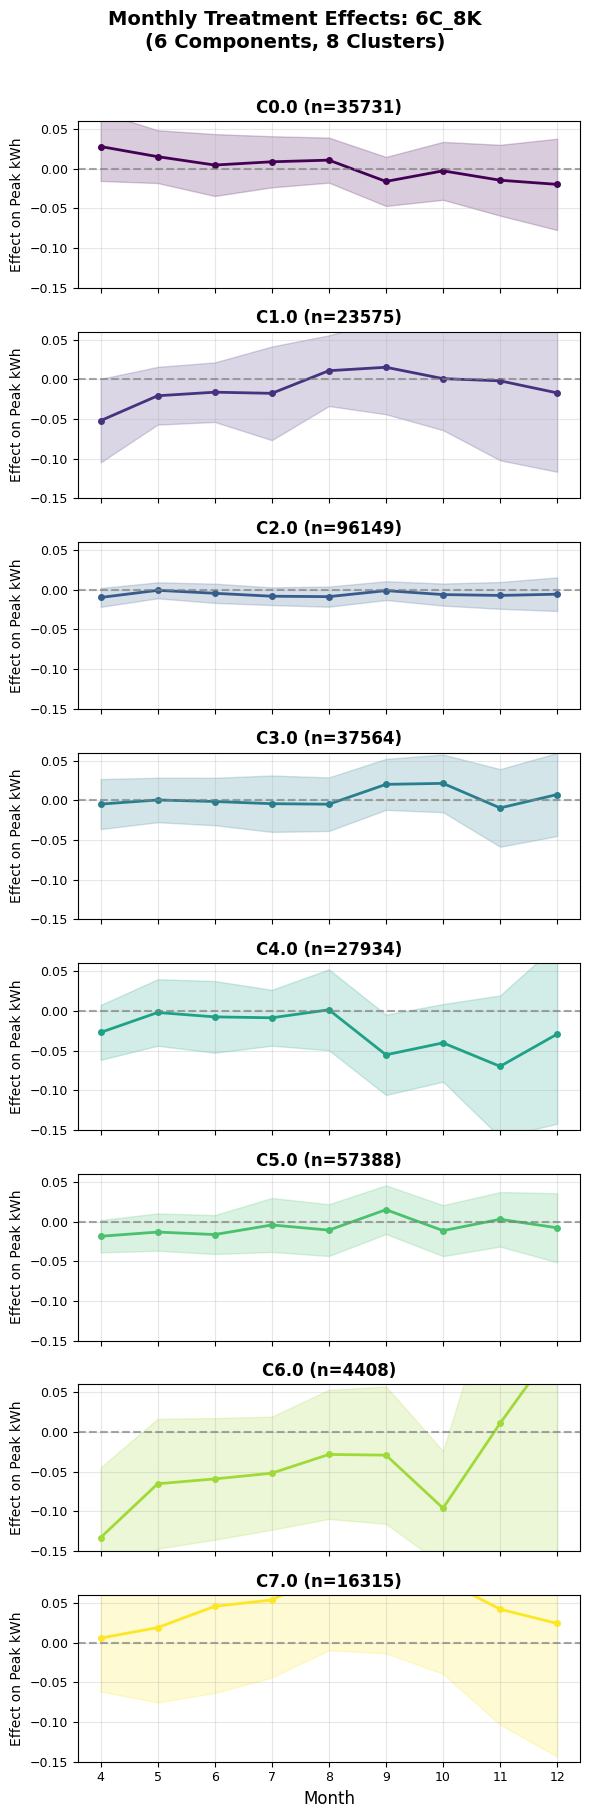


Processing: 6C_9K (Cluster_Comp06_k09)
Original df_peak_merged shape: (299064, 9)
Socio_df shape: 625
Cluster column 'Cluster_Comp06_k09' unique values: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0)]
After merge shape: (299064, 10)
Clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0 (n=9)
  Cluster 0.0: n=26055, effects estimated for 9 months
  Cluster 1.0: n=29492, effects estimated for 9 months
  Cluster 2.0: n=4897, effects estimated for 9 months
  Cluster 3.0: n=16666, effects estimated for 9 months
  Cluster 4.0: n=36716, effects estimated for 9 months
  Cluster 5.0: n=13272, effects estimated for 9 months
  Cluster 6.0: n=59588, effects estimated for 9 months
  Cluster 7.0: n=21075, effects estimated for 9 months
  Cluster 8.0: n=91303, effects estimated for 9 months


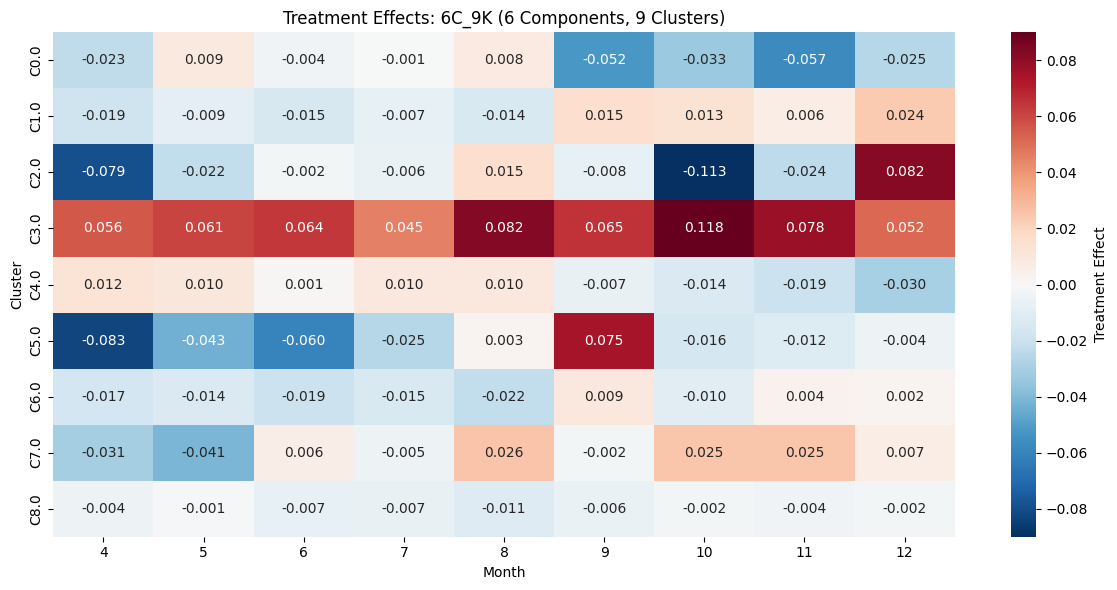

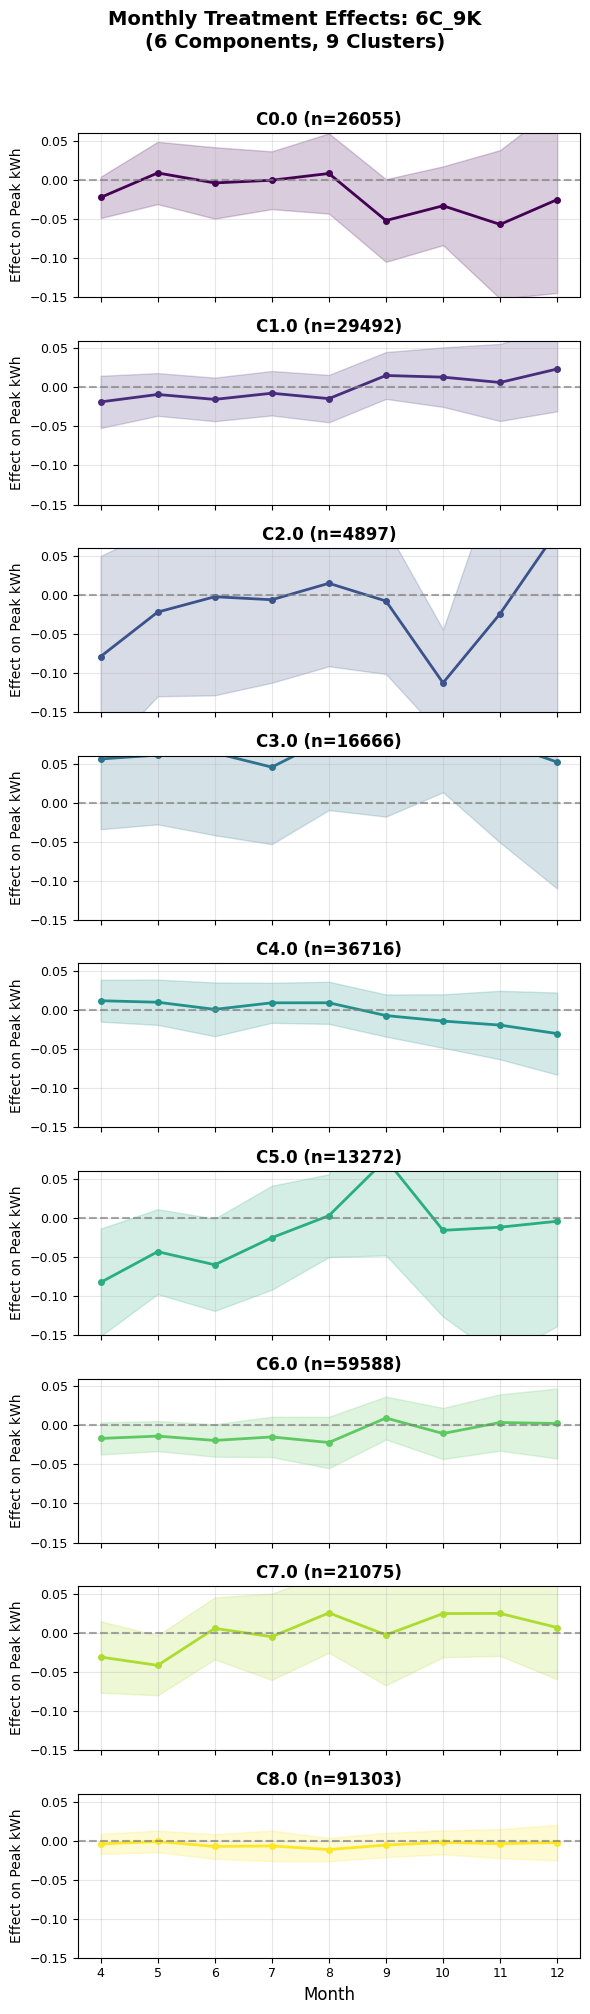


CREATING MASTER COMPARISON HEATMAP


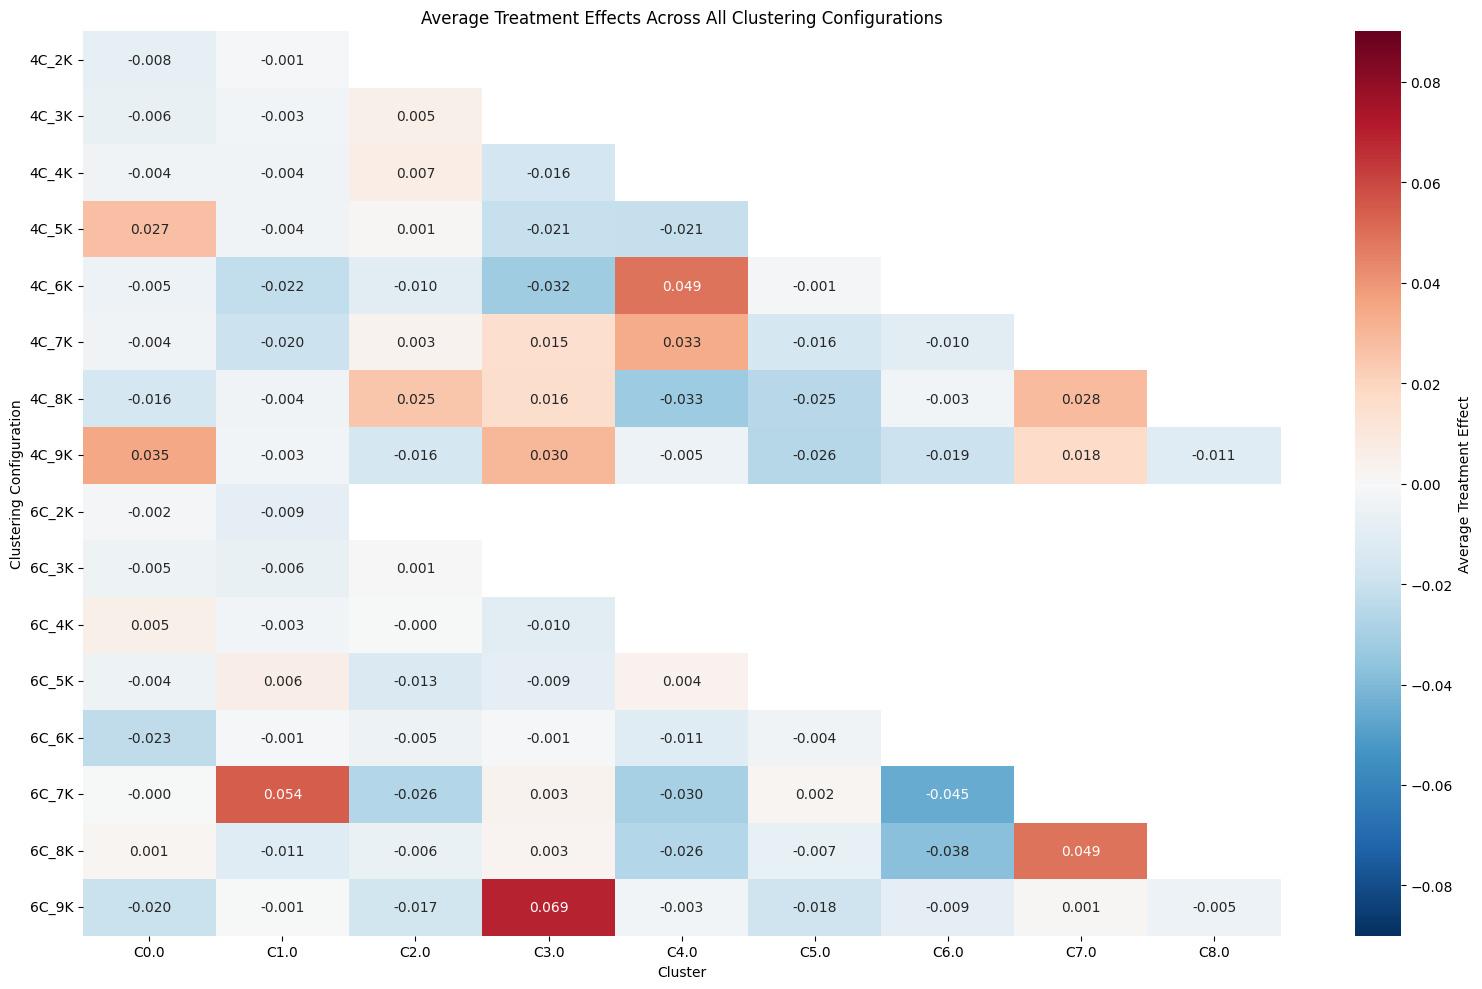

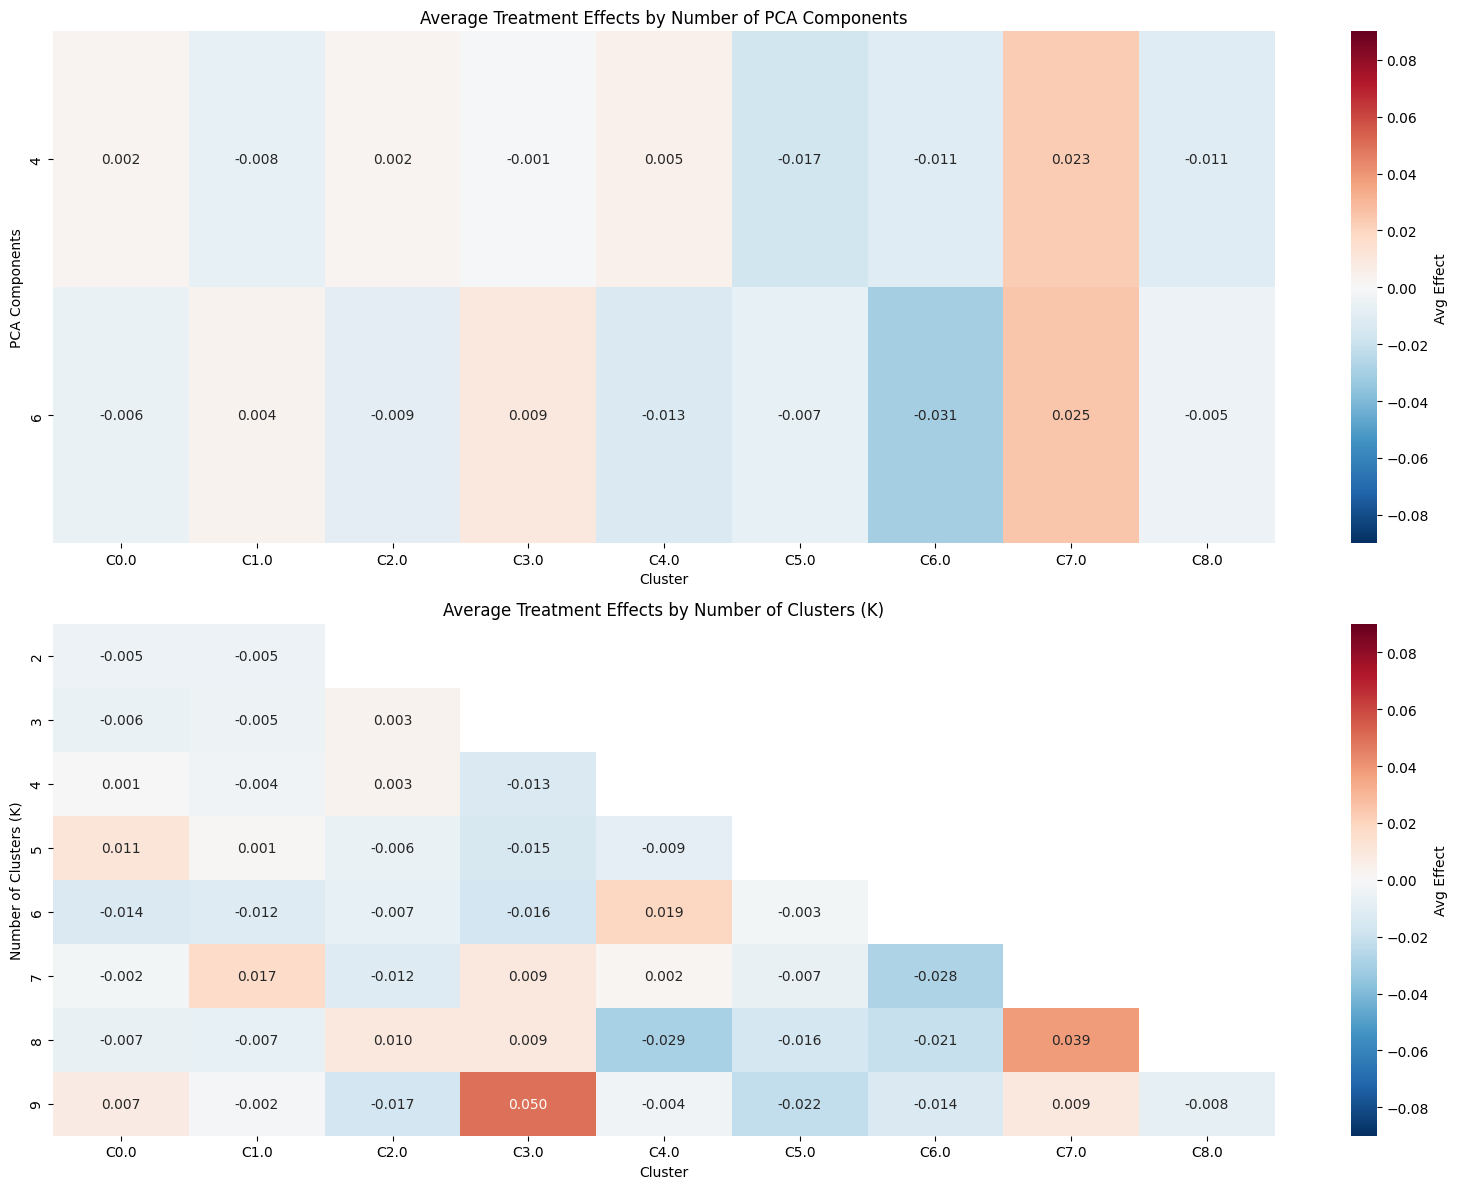


ANALYSIS SUMMARY
Total clustering configurations analyzed: 16
Successful configurations: 16

Summary by configuration:
              Avg_Effect                         Sample_Size             
                    mean     std     min     max         sum         mean
Configuration                                                            
4C_2K            -0.0048  0.0050 -0.0084 -0.0013      299064  149532.0000
4C_3K            -0.0015  0.0060 -0.0064  0.0052      299064   99688.0000
4C_4K            -0.0044  0.0094 -0.0163  0.0068      299064   74766.0000
4C_5K            -0.0036  0.0199 -0.0215  0.0271      299064   59812.8000
4C_6K            -0.0037  0.0282 -0.0322  0.0489      299064   49844.0000
4C_7K             0.0003  0.0187 -0.0196  0.0333      299064   42723.4286
4C_8K            -0.0013  0.0228 -0.0325  0.0283      299064   37383.0000
4C_9K             0.0002  0.0219 -0.0256  0.0347      299064   33229.3333
6C_2K            -0.0054  0.0051 -0.0090 -0.0018      299064  1495

In [123]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
import re  # Add regex import

# Create a directory to save the plots
SHOW_PLOTS = True
SAVE_PLOTS = False
output_dir = 'multi_cluster_treatment_effect_plots'
os.makedirs(output_dir, exist_ok=True)

def show_or_save_plot(filename=None):
    """Helper function to handle plot display and saving based on settings"""
    if SAVE_PLOTS and filename:
        plt.savefig(os.path.join(output_dir, filename), dpi=400, bbox_inches='tight')
        print(f"✓ Saved: {filename}")

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()  # Close the plot to free memory if not showing

# Get all cluster columns from socio_df
cluster_columns = [col for col in socio_df.columns if col.startswith('Cluster_Comp')]
print(f"Found {len(cluster_columns)} clustering methodologies:")
for col in cluster_columns:
    print(f"  - {col}")

# Extract unique clustering configurations
cluster_configs = []
for col in cluster_columns:
    # Extract components and k values from column names like 'Cluster_Comp04_k02'
    parts = col.split('_')
    comp = int(parts[1][4:])  # Extract number after 'Comp'
    k = int(parts[2][1:])     # Extract number after 'k'
    cluster_configs.append({
        'column': col,
        'components': comp,
        'k_clusters': k,
        'config_name': f"{comp}C_{k}K"  # Short name like "4C_3K"
    })

cluster_configs = sorted(cluster_configs, key=lambda x: (x['components'], x['k_clusters']))

print(f"\nProcessing {len(cluster_configs)} cluster configurations...")

# ---------------------------
# Overall Model Formula (for reference)
# ---------------------------
overall_formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

# Store all results for the master heatmap
all_config_results = {}

# Process each clustering configuration
for config in cluster_configs:
    cluster_col = config['column']
    config_name = config['config_name']

    print(f"\n{'='*60}")
    print(f"Processing: {config_name} ({cluster_col})")
    print(f"{'='*60}")

    # Merge cluster information with main dataset
    print(f"Original df_peak_merged shape: {df_peak_merged.shape}")
    print(f"Socio_df shape: {len(socio_df)}")
    print(f"Cluster column '{cluster_col}' unique values: {sorted(socio_df[cluster_col].unique())}")

    df_analysis = pd.merge(
        df_peak_merged,
        socio_df[['ANON_ID', cluster_col]],
        on='ANON_ID',
        how='inner'
    )

    print(f"After merge shape: {df_analysis.shape}")

    # Check if merge was successful
    if len(df_analysis) == 0:
        print(f"❌ No data after merge for {cluster_col}. Skipping.")
        continue

    # Rename cluster column for consistency
    df_analysis = df_analysis.rename(columns={cluster_col: 'Cluster'})

    # Check cluster column after rename
    if 'Cluster' not in df_analysis.columns:
        print(f"❌ Cluster column missing after rename. Available columns: {df_analysis.columns.tolist()}")
        continue

    # Ensure proper data types
    df_analysis['ANON_ID'] = df_analysis['ANON_ID'].astype(str)
    df_analysis['Month'] = df_analysis['Month'].astype(str)
    df_analysis['Treatment'] = df_analysis['Treatment'].astype(int)
    df_analysis['Post'] = df_analysis['Post'].astype(int)
    df_analysis['Cluster'] = df_analysis['Cluster'].astype(str)

    # Get unique clusters for this configuration
    try:
        cluster_unique_values = df_analysis['Cluster'].unique()
        cluster_categories = sorted([str(x) for x in cluster_unique_values if pd.notna(x)])
        print(f"Clusters: {', '.join(cluster_categories)} (n={len(cluster_categories)})")
    except Exception as e:
        print(f"❌ Error getting unique clusters: {e}")
        print(f"Cluster column dtype: {df_analysis['Cluster'].dtype}")
        print(f"Cluster sample values: {df_analysis['Cluster'].head().tolist()}")
        continue

    # Store results for each cluster in this configuration
    config_cluster_results = {}

    # Run separate regressions for each cluster
    for cluster in cluster_categories:
        cluster_data = df_analysis[df_analysis['Cluster'] == cluster].copy()

        if len(cluster_data) < 50:  # Skip if sample size is too small
            print(f"  Cluster {cluster}: Small sample ({len(cluster_data)}). Skipping.")
            continue

        try:
            cluster_model = smf.ols(formula=overall_formula, data=cluster_data).fit(
                cov_type='cluster', cov_kwds={'groups': cluster_data['ANON_ID']}
            )

            # Extract cluster-specific treatment effects
            cluster_effects = cluster_model.params[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
            cluster_effects_se = cluster_model.bse[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

            # Extract months from parameter names
            # Handle different possible parameter formats
            if len(cluster_effects) > 0:
                # Try different regex patterns for month extraction
                months = []
                for param_name in cluster_effects.index:
                    # Pattern 1: C(Month)[T.month]
                    match = re.search(r'C\(Month\)\[T\.([^\]]+)\]', param_name)
                    if match:
                        months.append(int(match.group(1)))
                    else:
                        # Pattern 2: C(Month)[month]
                        match = re.search(r'C\(Month\)\[([^\]]+)\]', param_name)
                        if match:
                            months.append(int(match.group(1)))
                        else:
                            # If no pattern matches, try to extract any number
                            match = re.search(r'(\d+)', param_name)
                            if match:
                                months.append(int(match.group(1)))
            else:
                months = []

            # Store results
            config_cluster_results[cluster] = {
                'months': months,
                'effects': cluster_effects.values,
                'se': cluster_effects_se.values,
                'n': len(cluster_data)
            }

            print(f"  Cluster {cluster}: n={len(cluster_data)}, effects estimated for {len(months)} months")

        except Exception as e:
            print(f"  Cluster {cluster}: Error - {e}")

    # Store results for this configuration
    all_config_results[config_name] = {
        'config': config,
        'cluster_results': config_cluster_results
    }

    # Create individual heatmap for this configuration
    if config_cluster_results:
        # Prepare data for heatmap
        heatmap_data = []

        for cluster, results in config_cluster_results.items():
            for month, effect in zip(results['months'], results['effects']):
                heatmap_data.append({
                    'Cluster': f"C{cluster}",
                    'Month': month,
                    'Effect': effect
                })

        if heatmap_data:
            heatmap_df = pd.DataFrame(heatmap_data)
            heatmap_pivot = heatmap_df.pivot(index='Cluster', columns='Month', values='Effect')

            # Create individual heatmap
            plt.figure(figsize=(12, 6))
            sns.heatmap(heatmap_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
                       vmin=-0.09, vmax=0.09, cbar_kws={'label': 'Treatment Effect'})
            plt.title(f'Treatment Effects: {config_name} ({config["components"]} Components, {config["k_clusters"]} Clusters)')
            plt.xlabel('Month')
            plt.ylabel('Cluster')
            plt.tight_layout()

            filename = f'heatmap_{config_name.lower()}.jpg'
            show_or_save_plot(filename)

        # ---------------------------
        # Create Monthly Treatment Effect Plots with Confidence Intervals
        # ---------------------------
        # Prepare data for time series plots
        timeseries_data = []

        for cluster, results in config_cluster_results.items():
            for i, month in enumerate(results['months']):
                effect = results['effects'][i]
                se = results['se'][i]
                ci_lower = effect - 1.96 * se
                ci_upper = effect + 1.96 * se

                timeseries_data.append({
                    'Cluster': f"C{cluster}",
                    'Month': month,
                    'Effect': effect,
                    'SE': se,
                    'CI_lower': ci_lower,
                    'CI_upper': ci_upper,
                    'n': results['n']
                })

        if timeseries_data:
            timeseries_df = pd.DataFrame(timeseries_data)

            # Get unique clusters for this configuration
            unique_clusters = sorted(timeseries_df['Cluster'].unique())
            n_clusters = len(unique_clusters)

            # Create facet grid plot
            fig, axes = plt.subplots(nrows=n_clusters, figsize=(6, 2.5 + 2*n_clusters), sharex=True)

            # Handle the case of only one cluster
            if n_clusters == 1:
                axes = [axes]

            # Color palette for clusters
            cluster_colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

            for i, cluster in enumerate(unique_clusters):
                ax = axes[i]
                cluster_data = timeseries_df[timeseries_df['Cluster'] == cluster].sort_values('Month')

                # Use color from palette
                color = cluster_colors[i]

                # Plot main effect line
                ax.plot(cluster_data['Month'], cluster_data['Effect'],
                       marker='o', color=color, linewidth=2, markersize=4)

                # Add confidence interval
                ax.fill_between(cluster_data['Month'],
                               cluster_data['CI_lower'],
                               cluster_data['CI_upper'],
                               alpha=0.2, color=color)

                # Add reference line at zero
                ax.axhline(0, linestyle='--', color='gray', alpha=0.7)

                # Add sample size to title
                sample_size = cluster_data['n'].iloc[0] if len(cluster_data) > 0 else 'N/A'
                ax.set_title(f"{cluster} (n={sample_size})", fontweight='bold')

                ax.set_ylabel("Effect on Peak kWh", fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_ylim(-0.15, 0.06)  # Consistent y-axis limits

                # Improve tick formatting
                ax.tick_params(axis='both', which='major', labelsize=9)

            # Set x-label for bottom subplot
            axes[-1].set_xlabel("Month", fontsize=12)

            # Add overall title
            fig.suptitle(f'Monthly Treatment Effects: {config_name}\n'
                        f'({config["components"]} Components, {config["k_clusters"]} Clusters)',
                        fontsize=14, fontweight='bold', y=0.98)

            plt.tight_layout()
            plt.subplots_adjust(top=0.92)  # Make room for suptitle

            filename = f'monthly_effects_{config_name.lower()}.jpg'
            show_or_save_plot(filename)

            # ---------------------------
            # Create Combined Plot (All Clusters Together)
            # ---------------------------
            # plt.figure(figsize=(12, 8))

            # for i, cluster in enumerate(unique_clusters):
            #     cluster_data = timeseries_df[timeseries_df['Cluster'] == cluster].sort_values('Month')
            #     color = cluster_colors[i]
            #     sample_size = cluster_data['n'].iloc[0] if len(cluster_data) > 0 else 'N/A'

            #     # Plot main effect line
            #     plt.plot(cluster_data['Month'], cluster_data['Effect'],
            #             marker='o', color=color, linewidth=2.5, markersize=5,
            #             label=f'{cluster} (n={sample_size})')

            #     # Add confidence interval
            #     plt.fill_between(cluster_data['Month'],
            #                    cluster_data['CI_lower'],
            #                    cluster_data['CI_upper'],
            #                    alpha=0.15, color=color)

            # # Add reference line at zero
            # plt.axhline(0, linestyle='--', color='gray', alpha=0.7, linewidth=1)

            # plt.title(f'Monthly Treatment Effects: {config_name}\n'
            #          f'({config["components"]} Components, {config["k_clusters"]} Clusters)',
            #          fontsize=14, fontweight='bold', pad=20)
            # plt.xlabel("Month", fontsize=12)
            # plt.ylabel("Treatment Effect on Peak kWh (4-7pm)", fontsize=12)
            # plt.grid(True, alpha=0.3)
            # plt.ylim(-0.15, 0.06)

            # # Add legend
            # plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

            # plt.tight_layout()

            # filename = f'combined_monthly_effects_{config_name.lower()}.jpg'
            # show_or_save_plot(filename)

# ---------------------------
# Create Master Comparison Heatmap
# ---------------------------
print(f"\n{'='*60}")
print("CREATING MASTER COMPARISON HEATMAP")
print(f"{'='*60}")

# Prepare data for master heatmap showing all configurations
master_heatmap_data = []

for config_name, config_data in all_config_results.items():
    cluster_results = config_data['cluster_results']

    for cluster, results in cluster_results.items():
        # Calculate average effect across all months for this cluster
        avg_effect = np.mean(results['effects'])

        master_heatmap_data.append({
            'Configuration': config_name,
            'Cluster': f"C{cluster}",
            'Avg_Effect': avg_effect,
            'Components': config_data['config']['components'],
            'K_Clusters': config_data['config']['k_clusters'],
            'Sample_Size': results['n']
        })

if master_heatmap_data:
    master_df = pd.DataFrame(master_heatmap_data)

    # Create pivot table for heatmap
    master_pivot = master_df.pivot(index='Configuration', columns='Cluster', values='Avg_Effect')

    # Create master heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(master_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
               vmin=-0.09, vmax=0.09, cbar_kws={'label': 'Average Treatment Effect'})
    plt.title('Average Treatment Effects Across All Clustering Configurations')
    plt.xlabel('Cluster')
    plt.ylabel('Clustering Configuration')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()

    show_or_save_plot('master_heatmap_all_configurations.jpg')

    # Create detailed configuration comparison
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))

    # Plot 1: Effects by number of components
    components_pivot = master_df.groupby(['Components', 'Cluster'])['Avg_Effect'].mean().unstack()
    sns.heatmap(components_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
               vmin=-0.09, vmax=0.09, ax=axes[0], cbar_kws={'label': 'Avg Effect'})
    axes[0].set_title('Average Treatment Effects by Number of PCA Components')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('PCA Components')

    # Plot 2: Effects by number of clusters
    k_pivot = master_df.groupby(['K_Clusters', 'Cluster'])['Avg_Effect'].mean().unstack()
    sns.heatmap(k_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
               vmin=-0.09, vmax=0.09, ax=axes[1], cbar_kws={'label': 'Avg Effect'})
    axes[1].set_title('Average Treatment Effects by Number of Clusters (K)')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Number of Clusters (K)')

    plt.tight_layout()
    show_or_save_plot('configuration_comparison_heatmaps.jpg')

# ---------------------------
# Summary Statistics
# ---------------------------
print(f"\n{'='*60}")
print("ANALYSIS SUMMARY")
print(f"{'='*60}")

total_configurations = len(all_config_results)
successful_configs = len([c for c in all_config_results.values() if c['cluster_results']])

print(f"Total clustering configurations analyzed: {total_configurations}")
print(f"Successful configurations: {successful_configs}")

if master_heatmap_data:
    summary_stats = master_df.groupby('Configuration').agg({
        'Avg_Effect': ['mean', 'std', 'min', 'max'],
        'Sample_Size': ['sum', 'mean']
    }).round(4)

    print(f"\nSummary by configuration:")
    print(summary_stats)

    # Find most extreme effects
    most_negative = master_df.loc[master_df['Avg_Effect'].idxmin()]
    most_positive = master_df.loc[master_df['Avg_Effect'].idxmax()]

    print(f"\nMost negative effect:")
    print(f"  {most_negative['Configuration']} Cluster {most_negative['Cluster']}: {most_negative['Avg_Effect']:.4f}")

    print(f"\nMost positive effect:")
    print(f"  {most_positive['Configuration']} Cluster {most_positive['Cluster']}: {most_positive['Avg_Effect']:.4f}")

print(f"\n✓ All analyses complete! Results saved to '{output_dir}' directory.")

In [117]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
import re  # Add regex import

# Create a directory to save the plots
SHOW_PLOTS = True
SAVE_PLOTS = True
output_dir = 'multi_cluster_treatment_effect_plots'
os.makedirs(output_dir, exist_ok=True)

# Get all cluster columns from socio_df
cluster_columns = [col for col in socio_df.columns if col.startswith('Cluster_Comp')]
print(f"Found {len(cluster_columns)} clustering methodologies:")
for col in cluster_columns:
    print(f"  - {col}")

# Extract unique clustering configurations
cluster_configs = []
for col in cluster_columns:
    # Extract components and k values from column names like 'Cluster_Comp04_k02'
    parts = col.split('_')
    comp = int(parts[1][4:])  # Extract number after 'Comp'
    k = int(parts[2][1:])     # Extract number after 'k'
    cluster_configs.append({
        'column': col,
        'components': comp,
        'k_clusters': k,
        'config_name': f"{comp}C_{k}K"  # Short name like "4C_3K"
    })

cluster_configs = sorted(cluster_configs, key=lambda x: (x['components'], x['k_clusters']))

print(f"\nProcessing {len(cluster_configs)} cluster configurations...")

# ---------------------------
# Overall Model Formula (for reference)
# ---------------------------
overall_formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

# Store all results for the master heatmap
all_config_results = {}

# Process each clustering configuration
for config in cluster_configs:
    cluster_col = config['column']
    config_name = config['config_name']

    print(f"\n{'='*60}")
    print(f"Processing: {config_name} ({cluster_col})")
    print(f"{'='*60}")

    # Merge cluster information with main dataset
    df_analysis = pd.merge(
        df_peak_merged,
        socio_df[['ANON_ID', cluster_col]],
        on='ANON_ID',
        how='inner'
    )

    # Rename cluster column for consistency
    df_analysis = df_analysis.rename(columns={cluster_col: 'Cluster'})

    # Ensure proper data types
    df_analysis['ANON_ID'] = df_analysis['ANON_ID'].astype(str)
    df_analysis['Month'] = df_analysis['Month'].astype(str)
    df_analysis['Treatment'] = df_analysis['Treatment'].astype(int)
    df_analysis['Post'] = df_analysis['Post'].astype(int)
    df_analysis['Cluster'] = df_analysis['Cluster'].astype(str)

    # Get unique clusters for this configuration
    cluster_categories = sorted(df_analysis['Cluster'].unique())
    print(f"Clusters: {', '.join(cluster_categories)} (n={len(cluster_categories)})")

    # Store results for each cluster in this configuration
    config_cluster_results = {}

    # Run separate regressions for each cluster
    for cluster in cluster_categories:
        cluster_data = df_analysis[df_analysis['Cluster'] == cluster].copy()

        if len(cluster_data) < 50:  # Skip if sample size is too small
            print(f"  Cluster {cluster}: Small sample ({len(cluster_data)}). Skipping.")
            continue

        try:
            cluster_model = smf.ols(formula=overall_formula, data=cluster_data).fit(
                cov_type='cluster', cov_kwds={'groups': cluster_data['ANON_ID']}
            )

            # Extract cluster-specific treatment effects
            cluster_effects = cluster_model.params[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
            cluster_effects_se = cluster_model.bse[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

            # Extract months from parameter names
            # Handle different possible parameter formats
            if len(cluster_effects) > 0:
                # Try different regex patterns for month extraction
                months = []
                for param_name in cluster_effects.index:
                    # Pattern 1: C(Month)[T.month]
                    match = re.search(r'C\(Month\)\[T\.([^\]]+)\]', param_name)
                    if match:
                        months.append(int(match.group(1)))
                    else:
                        # Pattern 2: C(Month)[month]
                        match = re.search(r'C\(Month\)\[([^\]]+)\]', param_name)
                        if match:
                            months.append(int(match.group(1)))
                        else:
                            # If no pattern matches, try to extract any number
                            match = re.search(r'(\d+)', param_name)
                            if match:
                                months.append(int(match.group(1)))
            else:
                months = []

            # Store results
            config_cluster_results[cluster] = {
                'months': months,
                'effects': cluster_effects.values,
                'se': cluster_effects_se.values,
                'n': len(cluster_data)
            }

            print(f"  Cluster {cluster}: n={len(cluster_data)}, effects estimated for {len(months)} months")

        except Exception as e:
            print(f"  Cluster {cluster}: Error - {e}")

    # Store results for this configuration
    all_config_results[config_name] = {
        'config': config,
        'cluster_results': config_cluster_results
    }

    # Create individual heatmap for this configuration
    if config_cluster_results:
        # Prepare data for heatmap
        heatmap_data = []

        for cluster, results in config_cluster_results.items():
            for month, effect in zip(results['months'], results['effects']):
                heatmap_data.append({
                    'Cluster': f"C{cluster}",
                    'Month': month,
                    'Effect': effect
                })

        if heatmap_data:
            heatmap_df = pd.DataFrame(heatmap_data)
            heatmap_pivot = heatmap_df.pivot(index='Cluster', columns='Month', values='Effect')

            # Create individual heatmap
            plt.figure(figsize=(12, 6))
            sns.heatmap(heatmap_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
                       vmin=-0.09, vmax=0.09, cbar_kws={'label': 'Treatment Effect'})
            plt.title(f'Treatment Effects: {config_name} ({config["components"]} Components, {config["k_clusters"]} Clusters)')
            plt.xlabel('Month')
            plt.ylabel('Cluster')
            plt.tight_layout()

            filename = f'heatmap_{config_name.lower()}.jpg'
            show_or_save_plot(filename)

        # ---------------------------
        # Create Monthly Treatment Effect Plots with Confidence Intervals
        # ---------------------------
        # Prepare data for time series plots
        timeseries_data = []

        for cluster, results in config_cluster_results.items():
            for i, month in enumerate(results['months']):
                effect = results['effects'][i]
                se = results['se'][i]
                ci_lower = effect - 1.96 * se
                ci_upper = effect + 1.96 * se

                timeseries_data.append({
                    'Cluster': f"C{cluster}",
                    'Month': month,
                    'Effect': effect,
                    'SE': se,
                    'CI_lower': ci_lower,
                    'CI_upper': ci_upper,
                    'n': results['n']
                })

        if timeseries_data:
            timeseries_df = pd.DataFrame(timeseries_data)

            # Get unique clusters for this configuration
            unique_clusters = sorted(timeseries_df['Cluster'].unique())
            n_clusters = len(unique_clusters)

            # Create facet grid plot
            fig, axes = plt.subplots(nrows=n_clusters, figsize=(12, 2.5 + 2*n_clusters), sharex=True)

            # Handle the case of only one cluster
            if n_clusters == 1:
                axes = [axes]

            # Color palette for clusters
            cluster_colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

            for i, cluster in enumerate(unique_clusters):
                ax = axes[i]
                cluster_data = timeseries_df[timeseries_df['Cluster'] == cluster].sort_values('Month')

                # Use color from palette
                color = cluster_colors[i]

                # Plot main effect line
                ax.plot(cluster_data['Month'], cluster_data['Effect'],
                       marker='o', color=color, linewidth=2, markersize=4)

                # Add confidence interval
                ax.fill_between(cluster_data['Month'],
                               cluster_data['CI_lower'],
                               cluster_data['CI_upper'],
                               alpha=0.2, color=color)

                # Add reference line at zero
                ax.axhline(0, linestyle='--', color='gray', alpha=0.7)

                # Add sample size to title
                sample_size = cluster_data['n'].iloc[0] if len(cluster_data) > 0 else 'N/A'
                ax.set_title(f"{cluster} (n={sample_size})", fontweight='bold')

                ax.set_ylabel("Effect on Peak kWh", fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_ylim(-0.15, 0.06)  # Consistent y-axis limits

                # Improve tick formatting
                ax.tick_params(axis='both', which='major', labelsize=9)

            # Set x-label for bottom subplot
            axes[-1].set_xlabel("Month", fontsize=12)

            # Add overall title
            fig.suptitle(f'Monthly Treatment Effects: {config_name}\n'
                        f'({config["components"]} Components, {config["k_clusters"]} Clusters)',
                        fontsize=14, fontweight='bold', y=0.98)

            plt.tight_layout()
            plt.subplots_adjust(top=0.92)  # Make room for suptitle

            filename = f'monthly_effects_{config_name.lower()}.jpg'
            show_or_save_plot(filename)

            # ---------------------------
            # Create Combined Plot (All Clusters Together)
            # ---------------------------
            plt.figure(figsize=(12, 8))

            for i, cluster in enumerate(unique_clusters):
                cluster_data = timeseries_df[timeseries_df['Cluster'] == cluster].sort_values('Month')
                color = cluster_colors[i]
                sample_size = cluster_data['n'].iloc[0] if len(cluster_data) > 0 else 'N/A'

                # Plot main effect line
                plt.plot(cluster_data['Month'], cluster_data['Effect'],
                        marker='o', color=color, linewidth=2.5, markersize=5,
                        label=f'{cluster} (n={sample_size})')

                # Add confidence interval
                plt.fill_between(cluster_data['Month'],
                               cluster_data['CI_lower'],
                               cluster_data['CI_upper'],
                               alpha=0.15, color=color)

            # Add reference line at zero
            plt.axhline(0, linestyle='--', color='gray', alpha=0.7, linewidth=1)

            plt.title(f'Monthly Treatment Effects: {config_name}\n'
                     f'({config["components"]} Components, {config["k_clusters"]} Clusters)',
                     fontsize=14, fontweight='bold', pad=20)
            plt.xlabel("Month", fontsize=12)
            plt.ylabel("Treatment Effect on Peak kWh (4-7pm)", fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.ylim(-0.15, 0.06)

            # Add legend
            plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.tight_layout()

            filename = f'combined_monthly_effects_{config_name.lower()}.jpg'
            show_or_save_plot(filename)

# ---------------------------
# Create Master Comparison Heatmap
# ---------------------------
print(f"\n{'='*60}")
print("CREATING MASTER COMPARISON HEATMAP")
print(f"{'='*60}")

# Prepare data for master heatmap showing all configurations
master_heatmap_data = []

for config_name, config_data in all_config_results.items():
    cluster_results = config_data['cluster_results']

    for cluster, results in cluster_results.items():
        # Calculate average effect across all months for this cluster
        avg_effect = np.mean(results['effects'])

        master_heatmap_data.append({
            'Configuration': config_name,
            'Cluster': f"C{cluster}",
            'Avg_Effect': avg_effect,
            'Components': config_data['config']['components'],
            'K_Clusters': config_data['config']['k_clusters'],
            'Sample_Size': results['n']
        })

if master_heatmap_data:
    master_df = pd.DataFrame(master_heatmap_data)

    # Create pivot table for heatmap
    master_pivot = master_df.pivot(index='Configuration', columns='Cluster', values='Avg_Effect')

    # Create master heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(master_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
               vmin=-0.09, vmax=0.09, cbar_kws={'label': 'Average Treatment Effect'})
    plt.title('Average Treatment Effects Across All Clustering Configurations')
    plt.xlabel('Cluster')
    plt.ylabel('Clustering Configuration')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()

    show_or_save_plot('master_heatmap_all_configurations.jpg')

    # Create detailed configuration comparison
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))

    # Plot 1: Effects by number of components
    components_pivot = master_df.groupby(['Components', 'Cluster'])['Avg_Effect'].mean().unstack()
    sns.heatmap(components_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
               vmin=-0.09, vmax=0.09, ax=axes[0], cbar_kws={'label': 'Avg Effect'})
    axes[0].set_title('Average Treatment Effects by Number of PCA Components')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('PCA Components')

    # Plot 2: Effects by number of clusters
    k_pivot = master_df.groupby(['K_Clusters', 'Cluster'])['Avg_Effect'].mean().unstack()
    sns.heatmap(k_pivot, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
               vmin=-0.09, vmax=0.09, ax=axes[1], cbar_kws={'label': 'Avg Effect'})
    axes[1].set_title('Average Treatment Effects by Number of Clusters (K)')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Number of Clusters (K)')

    plt.tight_layout()
    show_or_save_plot('configuration_comparison_heatmaps.jpg')

# ---------------------------
# Summary Statistics
# ---------------------------
print(f"\n{'='*60}")
print("ANALYSIS SUMMARY")
print(f"{'='*60}")

total_configurations = len(all_config_results)
successful_configs = len([c for c in all_config_results.values() if c['cluster_results']])

print(f"Total clustering configurations analyzed: {total_configurations}")
print(f"Successful configurations: {successful_configs}")

if master_heatmap_data:
    summary_stats = master_df.groupby('Configuration').agg({
        'Avg_Effect': ['mean', 'std', 'min', 'max'],
        'Sample_Size': ['sum', 'mean']
    }).round(4)

    print(f"\nSummary by configuration:")
    print(summary_stats)

    # Find most extreme effects
    most_negative = master_df.loc[master_df['Avg_Effect'].idxmin()]
    most_positive = master_df.loc[master_df['Avg_Effect'].idxmax()]

    print(f"\nMost negative effect:")
    print(f"  {most_negative['Configuration']} Cluster {most_negative['Cluster']}: {most_negative['Avg_Effect']:.4f}")

    print(f"\nMost positive effect:")
    print(f"  {most_positive['Configuration']} Cluster {most_positive['Cluster']}: {most_positive['Avg_Effect']:.4f}")

print(f"\n✓ All analyses complete! Results saved to '{output_dir}' directory.")

Found 16 clustering methodologies:
  - Cluster_Comp04_k02
  - Cluster_Comp04_k03
  - Cluster_Comp04_k04
  - Cluster_Comp04_k05
  - Cluster_Comp04_k06
  - Cluster_Comp04_k07
  - Cluster_Comp04_k08
  - Cluster_Comp04_k09
  - Cluster_Comp06_k02
  - Cluster_Comp06_k03
  - Cluster_Comp06_k04
  - Cluster_Comp06_k05
  - Cluster_Comp06_k06
  - Cluster_Comp06_k07
  - Cluster_Comp06_k08
  - Cluster_Comp06_k09

Processing 16 cluster configurations...

Processing: 4C_2K (Cluster_Comp04_k02)


AttributeError: 'DataFrame' object has no attribute 'unique'

Found 7 unique clusters: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0

Analyzing Cluster 0.0
  Estimated treatment effects for Cluster 0.0 (n=115006):
Treatment:Post:C(Month)[10]   -0.002539
Treatment:Post:C(Month)[11]    0.000964
Treatment:Post:C(Month)[12]    0.000534
Treatment:Post:C(Month)[4]    -0.006009
Treatment:Post:C(Month)[5]     0.004057
Treatment:Post:C(Month)[6]    -0.003555
Treatment:Post:C(Month)[7]     0.001240
Treatment:Post:C(Month)[8]    -0.006958
Treatment:Post:C(Month)[9]     0.008556
dtype: float64

Analyzing Cluster 1.0
  Estimated treatment effects for Cluster 1.0 (n=19677):
Treatment:Post:C(Month)[10]    0.108056
Treatment:Post:C(Month)[11]    0.084088
Treatment:Post:C(Month)[12]    0.061077
Treatment:Post:C(Month)[4]     0.018086
Treatment:Post:C(Month)[5]     0.014446
Treatment:Post:C(Month)[6]     0.020311
Treatment:Post:C(Month)[7]     0.031701
Treatment:Post:C(Month)[8]     0.072439
Treatment:Post:C(Month)[9]     0.077472
dtype: float64

Analyzing Cluster 2.0
  Estim

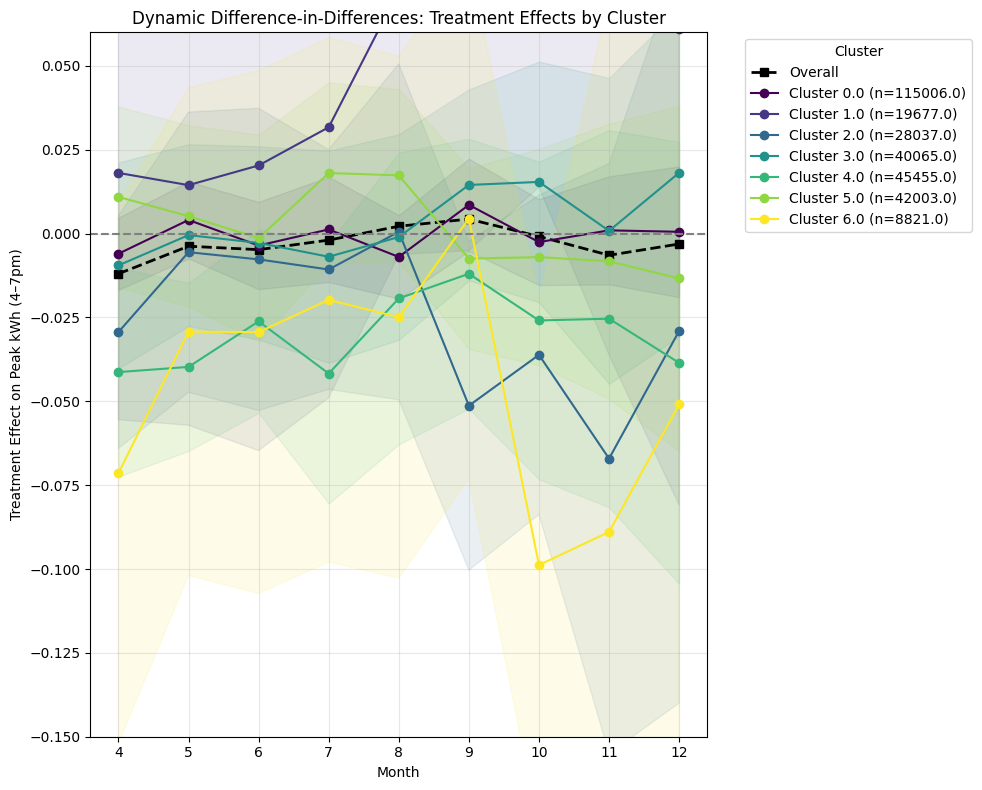

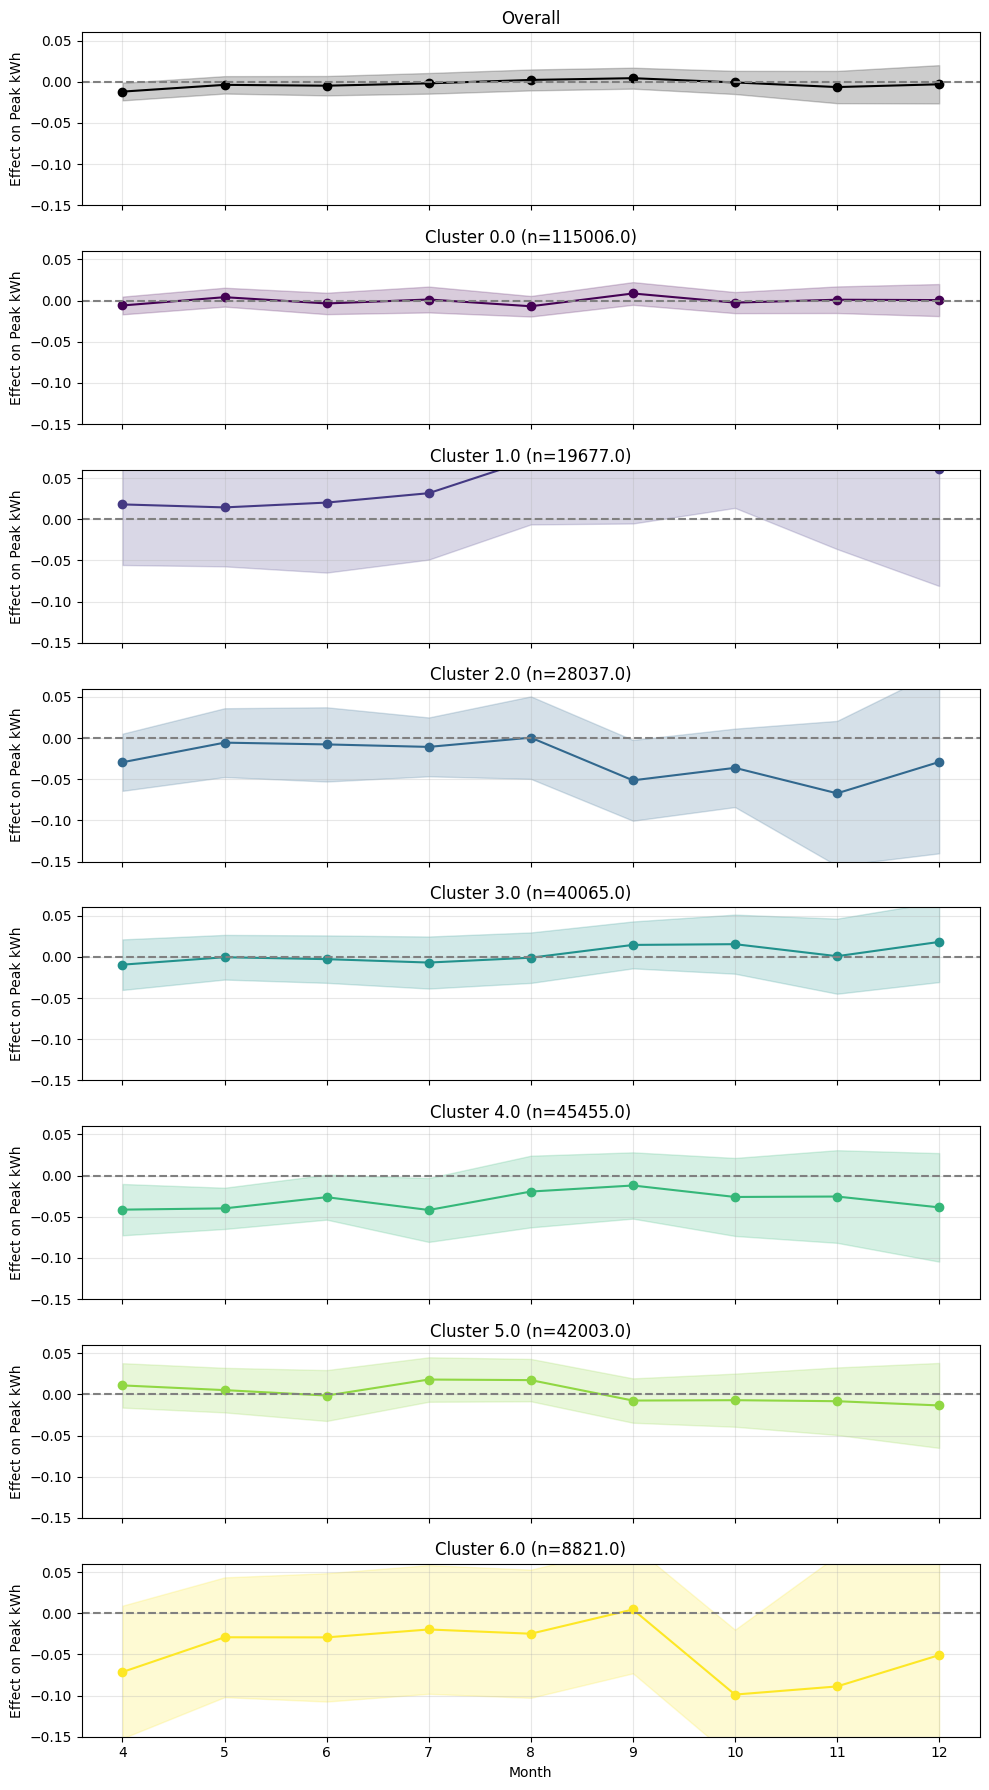

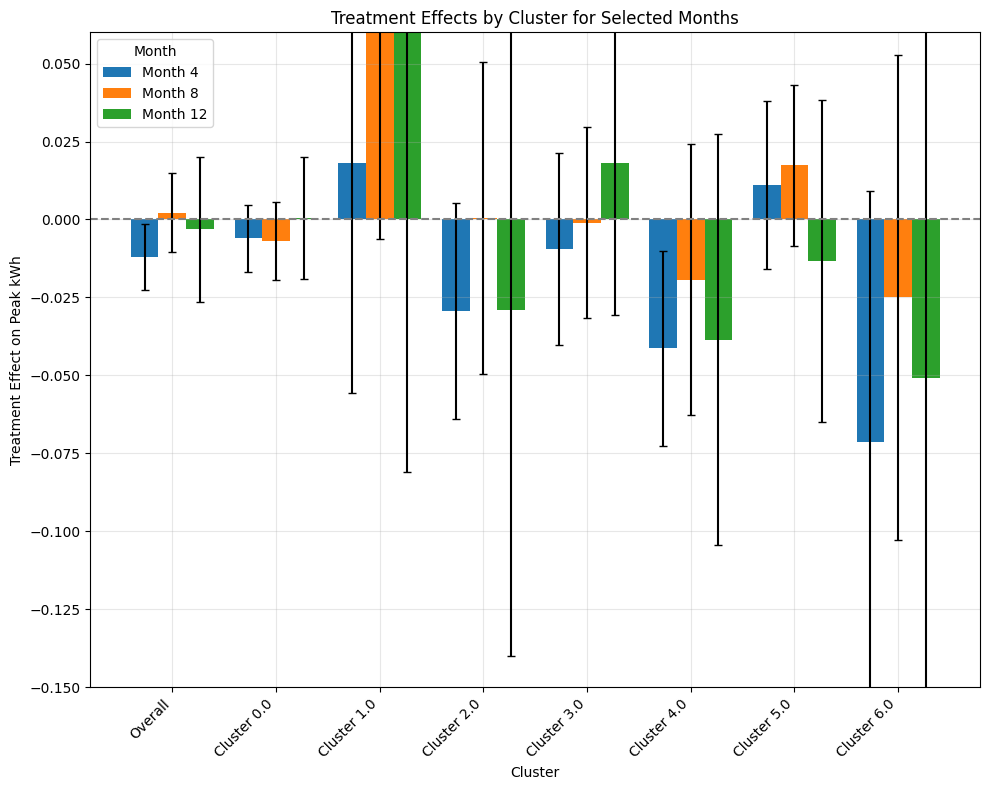

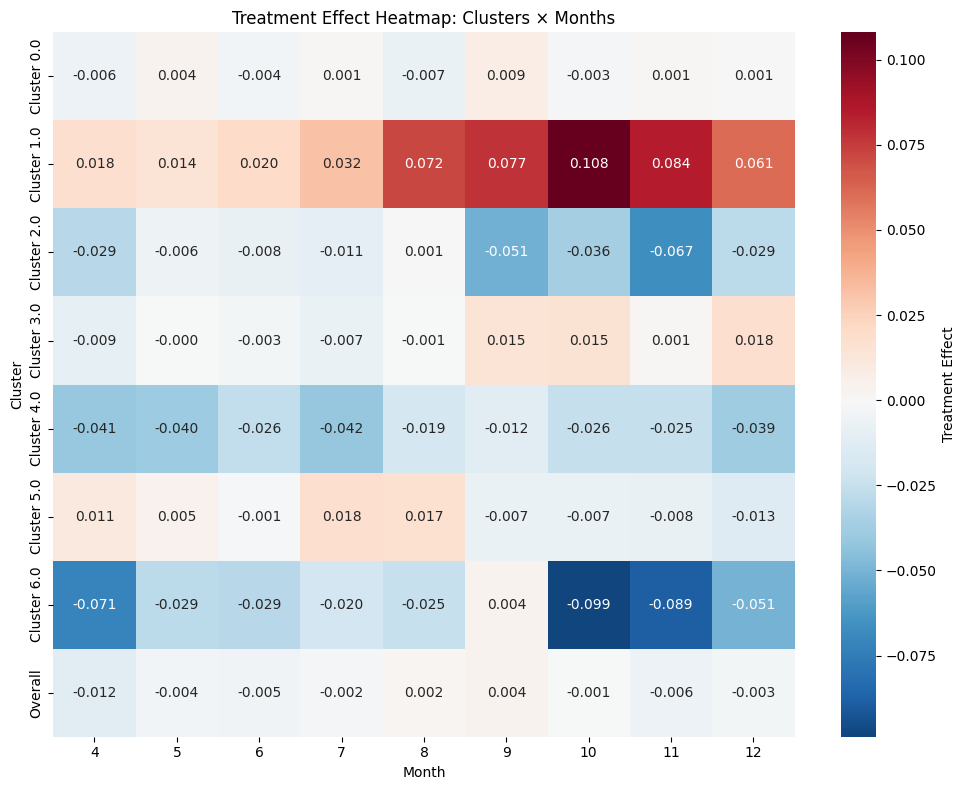

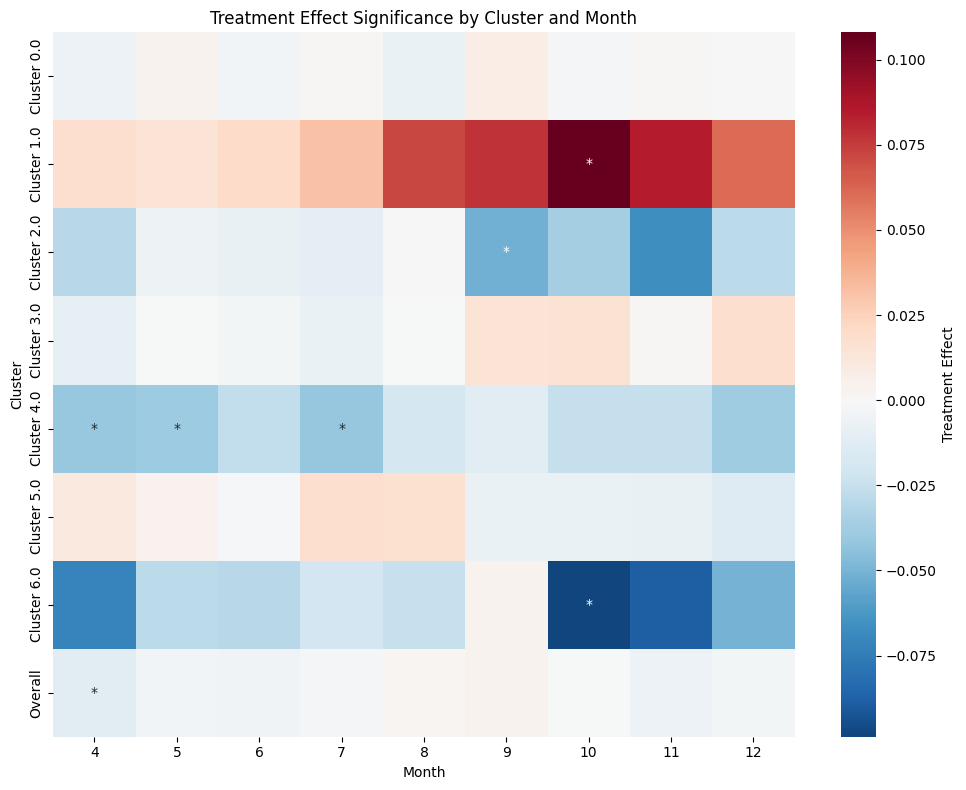

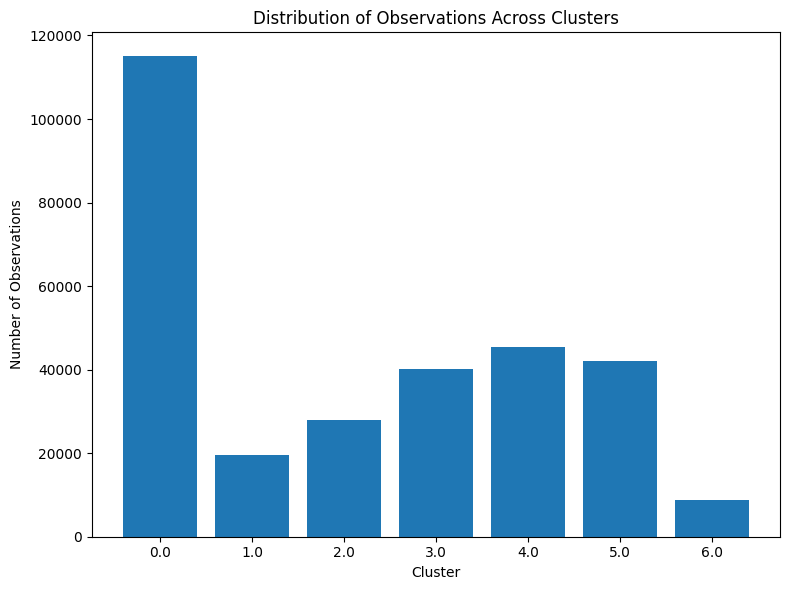

<Figure size 800x600 with 0 Axes>

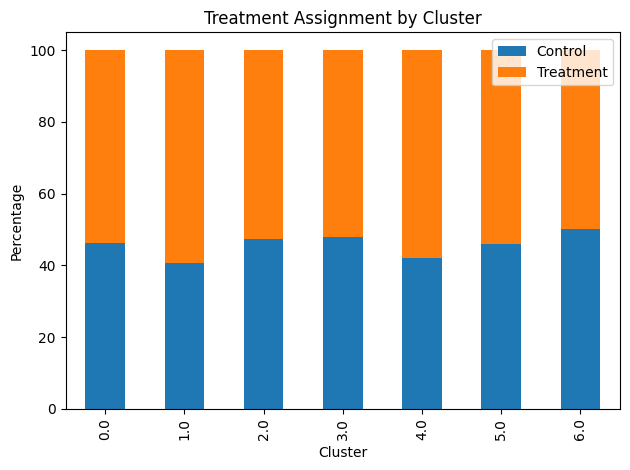

All plots saved to the 'cluster_treatment_effect_plots' directory in both PNG and JPG formats.


In [109]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

# Create a directory to save the plots
SHOW_PLOTS = True
SAVE_PLOTS = False
output_dir = 'cluster_treatment_effect_plots'
os.makedirs(output_dir, exist_ok=True)

# Assuming df_peak_merged is your main dataset and 'Cluster' is already in it
# If not, merge with the dataframe containing your cluster labels

# Check if Cluster is in the dataset
if 'Cluster' not in df_peak_merged.columns:
    # Merge with socioeconomic data including your cluster variable
    df_peak_merged = pd.merge(
        df_peak_merged,
        socio_df[['ANON_ID', 'Cluster_Comp06_k07']],
        on='ANON_ID',
        how='inner'
    )

df_peak_merged.rename(columns={'Cluster_Comp06_k07': 'Cluster'})

# Make sure ANON_ID, Month, Treatment, and Post are of appropriate types
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)

# Make sure Cluster is properly formatted (as string to avoid float precision issues)
df_peak_merged['Cluster'] = df_peak_merged['Cluster'].astype(str)

# Get unique clusters for analysis
cluster_categories = sorted(df_peak_merged['Cluster'].unique())
print(f"Found {len(cluster_categories)} unique clusters: {', '.join(cluster_categories)}")

# ---------------------------
# Overall Model (for reference)
# ---------------------------
overall_formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

overall_model = smf.ols(formula=overall_formula, data=df_peak_merged).fit(
    cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']}
)

# Extract overall treatment effects
overall_effects = overall_model.params[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
overall_effects_se = overall_model.bse[overall_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

# ---------------------------
# Cluster Heterogeneity Analysis
# ---------------------------
# Store results for each cluster
cluster_results = {}

# Create a colormap for clusters (using updated matplotlib syntax)
n_clusters = len(cluster_categories)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Run separate regressions for each cluster
for i, cluster in enumerate(cluster_categories):
    print(f"\nAnalyzing Cluster {cluster}")

    # Subset data for this cluster
    cluster_data = df_peak_merged[df_peak_merged['Cluster'] == cluster].copy()

    if len(cluster_data) < 100:  # Skip if sample size is too small
        print(f"  Warning: Small sample size ({len(cluster_data)} observations). Skipping.")
        continue

    # Use the same formula as the overall model
    try:
        cluster_model = smf.ols(formula=overall_formula, data=cluster_data).fit(
            cov_type='cluster', cov_kwds={'groups': cluster_data['ANON_ID']}
        )

        # Extract cluster-specific treatment effects
        cluster_effects = cluster_model.params[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]
        cluster_effects_se = cluster_model.bse[cluster_model.params.index.str.contains('Treatment:Post:C\(Month\)')]

        # Store results
        cluster_results[cluster] = {
            'params': cluster_effects,
            'se': cluster_effects_se,
            'n': len(cluster_data)
        }

        print(f"  Estimated treatment effects for Cluster {cluster} (n={len(cluster_data)}):")
        print(cluster_effects)

    except Exception as e:
        print(f"  Error analyzing Cluster {cluster}: {e}")

# ---------------------------
# Prepare data for plotting
# ---------------------------
# 1. Extract months from parameter names
months = [int(m) for m in overall_effects.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

# 2. Build dataframe for the overall effects
overall_df = pd.DataFrame({
    'Month': months,
    'Effect': overall_effects.values,
    'SE': overall_effects_se.values,
    'Category': 'Overall'
})
overall_df = overall_df.sort_values('Month')
overall_df['CI_lower'] = overall_df['Effect'] - 1.96 * overall_df['SE']
overall_df['CI_upper'] = overall_df['Effect'] + 1.96 * overall_df['SE']

# 3. Build dataframes for each cluster
cluster_dfs = []
for cluster in cluster_results:
    # Extract parameters and standard errors
    cluster_params = cluster_results[cluster]['params']
    cluster_se = cluster_results[cluster]['se']

    # Extract months
    cluster_months = [int(m) for m in cluster_params.index.str.extract(r'C\(Month\)\[(\d+)\]')[0]]

    # Create dataframe - use exact cluster string for category
    cluster_df = pd.DataFrame({
        'Month': cluster_months,
        'Effect': cluster_params.values,
        'SE': cluster_se.values,
        'Category': f'Cluster {cluster}',
        'n': cluster_results[cluster]['n'],
        'ClusterID': cluster  # Store original cluster ID for easier matching
    })
    cluster_df = cluster_df.sort_values('Month')
    cluster_df['CI_lower'] = cluster_df['Effect'] - 1.96 * cluster_df['SE']
    cluster_df['CI_upper'] = cluster_df['Effect'] + 1.96 * cluster_df['SE']

    cluster_dfs.append(cluster_df)

# Combine all results
all_effects_df = pd.concat([overall_df] + cluster_dfs, ignore_index=True)

# Create a mapping from category names to colors for consistent coloring
category_color_map = {'Overall': 'black'}
for i, cluster in enumerate(cluster_categories):
    category_color_map[f'Cluster {cluster}'] = colors[i]

# ---------------------------
# Create Visualizations
# ---------------------------
# Plot 1: Combined plot with all clusters
plt.figure(figsize=(10, 8))

# Plot overall effect
overall_data = all_effects_df[all_effects_df['Category'] == 'Overall']
plt.plot(overall_data['Month'], overall_data['Effect'], marker='s', color='black',
         linestyle='--', linewidth=2, label='Overall')

# Plot each cluster
for i, cluster in enumerate(cluster_categories):
    category_name = f'Cluster {cluster}'
    if category_name not in all_effects_df['Category'].values:
        continue

    cluster_data = all_effects_df[all_effects_df['Category'] == category_name]
    plt.plot(cluster_data['Month'], cluster_data['Effect'], marker='o', color=colors[i],
             label=f'Cluster {cluster} (n={cluster_data["n"].iloc[0]})')
    plt.fill_between(cluster_data['Month'], cluster_data['CI_lower'], cluster_data['CI_upper'],
                    alpha=0.1, color=colors[i])

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Treatment Effects by Cluster")
plt.xlabel("Month")
plt.ylabel("Treatment Effect on Peak kWh (4–7pm)")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(-0.15, 0.06)  # Set consistent y-axis limits - adjusted for your data
plt.tight_layout()
# Save the figure
show_or_save_plot('01_combined_treatment_effects_by_cluster.jpg')


# Plot 2: Facet grid with separate panel for each cluster
unique_categories = ['Overall'] + [f'Cluster {c}' for c in cluster_categories if f'Cluster {c}' in all_effects_df['Category'].values]
n_categories = len(unique_categories)

fig, axes = plt.subplots(nrows=n_categories, figsize=(10, 2 + 2*n_categories), sharex=True)

# Handle the case of only one category
if n_categories == 1:
    axes = [axes]

for i, category in enumerate(unique_categories):
    ax = axes[i]
    cat_data = all_effects_df[all_effects_df['Category'] == category]

    # Use color from our mapping
    color = category_color_map[category]

    ax.plot(cat_data['Month'], cat_data['Effect'], marker='o', color=color)
    ax.fill_between(cat_data['Month'], cat_data['CI_lower'], cat_data['CI_upper'],
                   alpha=0.2, color=color)
    ax.axhline(0, linestyle='--', color='gray')

    # Add sample size for clusters
    if category != 'Overall':
        sample_size = cat_data['n'].iloc[0] if 'n' in cat_data.columns else 'N/A'
        ax.set_title(f"{category} (n={sample_size})")
    else:
        ax.set_title("Overall")

    ax.set_ylabel("Effect on Peak kWh")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.15, 0.06)  # Set consistent y-axis limits - adjusted

axes[-1].set_xlabel("Month")
plt.tight_layout()
show_or_save_plot('02_facet_grid_treatment_effects.jpg')


# Plot 3: Bar chart comparing treatment effects across clusters for selected months
# Choose a few representative months
all_months = sorted(list(set(months)))
if len(all_months) <= 3:
    selected_months = all_months
else:
    # Select beginning, middle, and end months
    selected_months = [all_months[0], all_months[len(all_months)//2], all_months[-1]]

plt.figure(figsize=(10, 8))

# For each selected month, plot a grouped bar chart
x_positions = np.arange(len(unique_categories))
width = 0.8 / len(selected_months)  # Width of each bar

for i, month in enumerate(selected_months):
    # Offset for this month's group of bars
    offset = (i - len(selected_months)/2 + 0.5) * width

    # Collect effects for this month across categories
    effects = []
    ci_lower = []
    ci_upper = []

    for category in unique_categories:
        month_cat_data = all_effects_df[(all_effects_df['Month'] == month) &
                                      (all_effects_df['Category'] == category)]

        if len(month_cat_data) > 0:
            effect = month_cat_data['Effect'].iloc[0]
            lower = month_cat_data['CI_lower'].iloc[0]
            upper = month_cat_data['CI_upper'].iloc[0]
        else:
            effect = np.nan
            lower = np.nan
            upper = np.nan

        effects.append(effect)
        ci_lower.append(lower)
        ci_upper.append(upper)

    # Plot bars for this month
    bars = plt.bar(x_positions + offset, effects, width, label=f'Month {month}')

    # Add error bars
    plt.errorbar(x_positions + offset, effects,
                yerr=[np.array(effects) - np.array(ci_lower),
                      np.array(ci_upper) - np.array(effects)],
                fmt='none', color='black', capsize=3)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Treatment Effects by Cluster for Selected Months")
plt.xlabel("Cluster")
plt.ylabel("Treatment Effect on Peak kWh")
plt.xticks(x_positions, unique_categories, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title="Month")
plt.ylim(-0.15, 0.06)  # Set consistent y-axis limits - adjusted
plt.tight_layout()

show_or_save_plot('03_bar_chart_selected_months.jpg')

# Plot 4: Heatmap of treatment effects across months and clusters
# Pivot the data for the heatmap
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.3f',
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Heatmap: Clusters × Months')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.tight_layout()
show_or_save_plot('04_heatmap_treatment_effects.jpg')


# Plot 5: Display significance patterns
plt.figure(figsize=(10, 8))

# Create a DataFrame with significance markers
sig_data = all_effects_df.copy()
sig_data['Significant'] = np.where(
    (sig_data['CI_lower'] > 0) | (sig_data['CI_upper'] < 0),
    '*',  # Significant effect
    ''    # Not significant
)

# Pivot for heatmap
sig_heatmap = sig_data.pivot(
    index='Category', columns='Month', values='Significant')

# Create a heatmap with significance markers
heatmap_data = all_effects_df.pivot(
    index='Category', columns='Month', values='Effect')

sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=sig_heatmap, fmt='s',
            cbar_kws={'label': 'Treatment Effect'})
plt.title('Treatment Effect Significance by Cluster and Month')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.tight_layout()
show_or_save_plot('05_significance_heatmap.jpg')


# Plot 6: Cluster distribution visualization
plt.figure(figsize=(8, 6))
cluster_counts = df_peak_merged['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.title('Distribution of Observations Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.tight_layout()
show_or_save_plot('06_cluster_distribution.jpg')


# Plot 7: Treatment assignment by cluster
plt.figure(figsize=(8, 6))
treatment_by_cluster = pd.crosstab(
    df_peak_merged['Cluster'],
    df_peak_merged['Treatment'],
    normalize='index'
) * 100  # Convert to percentage

treatment_by_cluster.plot(kind='bar', stacked=True)
plt.title('Treatment Assignment by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(['Control', 'Treatment'])
plt.tight_layout()
show_or_save_plot('07_treatment_assignment_by_cluster.jpg')

print(f"All plots saved to the '{output_dir}' directory in both PNG and JPG formats.")

In [ ]:
sociodf

# Bring Heterogeneous Effects

In [ ]:
# Step 0.2 (unchanged)
import pandas as pd
import os

df_merged_with_clusters = pd.read_csv('ANON_ID_w_socio_and_clusters.csv')
socio_df = df_merged_with_clusters

# Drop rows where any feature is missing (NaN)
socio_df.dropna(inplace=True)

# Remove 'Unknown'
features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
     'HOME_VALUE'
]

features = [
    'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]
mask_no_unknown = (socio_df[features] != 'Unknown').all(axis=1)
socio_df = socio_df[mask_no_unknown].copy()

print(f"Socio-economic data shape after cleaning: {socio_df.shape}")

# Convert columns with a logical order into ordered categories
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'
] # ordinal
household_occupancy_order = ['Single Adult Household', 'Couple Household', 'Multi-Occupancy Household']
children_at_home_order = ['0', '1', '2+'] # ordinal
household_size_order = ['1', '2', '3-4', '5+'] # ordinal
number_of_bedrooms_order = ['1', '2', '3', '4', '5+'] # ordinal
highest_qualification_order = [
    'GCSE Equivalent', 'A Level Equivalent',
    'Secondary Education or Less', 'University Degree or Higher'
] # ordinal
home_value_order = ['0-100k', '100-150k', '150-250k', '250-500k', '500k+'] # ordinal
social_grade_order = ['Social grade A', 'Social grade B', 'Social grade C1', 'Social grade C2', 'Social grade D'] # ordinal

feature_orders = {
    'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order,
    'HOUSEHOLD_OCCUPANCY': household_occupancy_order,
    'CHILDREN_AT_HOME': children_at_home_order,
    'HOUSEHOLD_SIZE': household_size_order,
    'NUMBER_OF_BEDROOMS': number_of_bedrooms_order,
    'HIGHEST_QUALIFICATION': highest_qualification_order,
    'HOME_VALUE': home_value_order,
    'SOCIAL_GRADE': social_grade_order
}
for col, cat_order in feature_orders.items():
    if col in socio_df.columns:
        socio_df[col] = pd.Categorical(socio_df[col], categories=cat_order, ordered=True)


Socio-economic data shape after cleaning: (614, 21)


In [ ]:
# Convert ordered categories into numerical codes
for col in feature_orders:
    if col in socio_df.columns:
        socio_df[f"{col}_num"] = socio_df[col].cat.codes

print(socio_df.shape)

socio_df.head()
socio_df['Group'] = socio_df['Group'].map({'Intervention': 1, 'Control': 0})
# Merge numeric socioeconomic data into main df
df_model = socio_df

# Only map if values are still strings
if df_model['Group'].dtype == 'object':
    df_model['Group'] = df_model['Group'].map({'Intervention': 1, 'Control': 0})
    print("Group column successfully mapped to binary values.")
else:
    print("Group column is already numeric — no mapping applied.")

# Optional: confirm result
print("Unique values in Group column:", df_model['Group'].unique())


(614, 30)
Group column is already numeric — no mapping applied.
Unique values in Group column: [0 1]


In [ ]:
from statsmodels.formula.api import ols

model = ols("Delta ~ Group * C(Cluster)", data=df_merged_with_clusters).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.065
Date:                Tue, 20 May 2025   Prob (F-statistic):              0.387
Time:                        11:20:57   Log-Likelihood:                 863.18
No. Observations:                 614   AIC:                            -1698.
Df Residuals:                     600   BIC:                            -1636.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

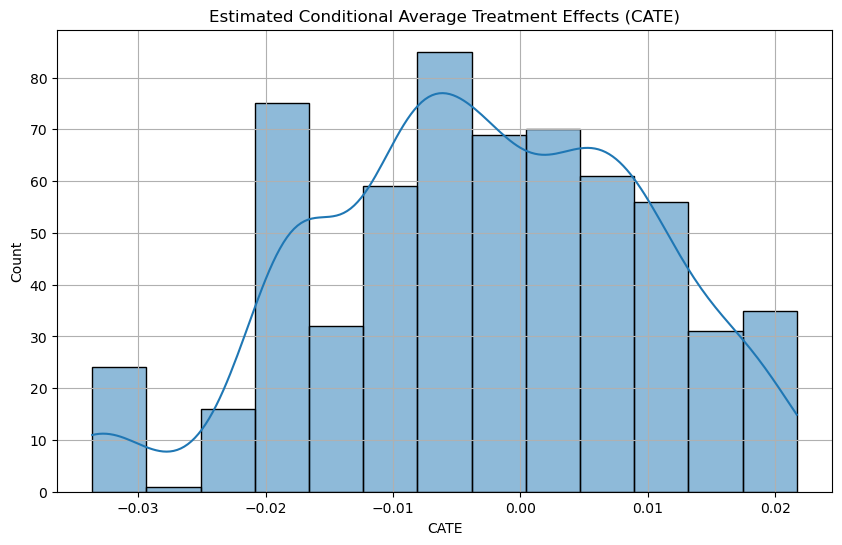

-0.0031706657649661547


In [ ]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV



features_causal = {
    'CHILDREN_AT_HOME': children_at_home_order,
    'INCOME_CATEGORY': income_category_order
}
# Inputs
# Define X, T, and Y
X_cols = [f"{col}_num" for col in features_causal] + ['Cluster']  # add 'Cluster' or any other numeric variable
X = df_model[X_cols]
T = df_model['Group']  # 1 = treated, 0 = control
Y = df_model['Delta']  # outcome variable


model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

cf = CausalForestDML(model_y=model_y, model_t=model_t, random_state=42)
cf.fit(Y, T, X=X)
avgTE = cf.ate(X)


# Estimate Conditional Average Treatment Effects
df_model['CATE'] = cf.effect(X)

# Optional: Visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_model['CATE'], kde=True)
plt.title("Estimated Conditional Average Treatment Effects (CATE)")
plt.xlabel("CATE")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print(avgTE)

In [ ]:
df_cate = df_model.groupby('Cluster')['CATE'].mean().sort_values()
print(df_cate)
# When there are many features,

Cluster
5.0   -0.010547
1.0   -0.010243
0.0   -0.006489
2.0   -0.002660
6.0   -0.001551
4.0    0.000286
3.0    0.002169
Name: CATE, dtype: float64


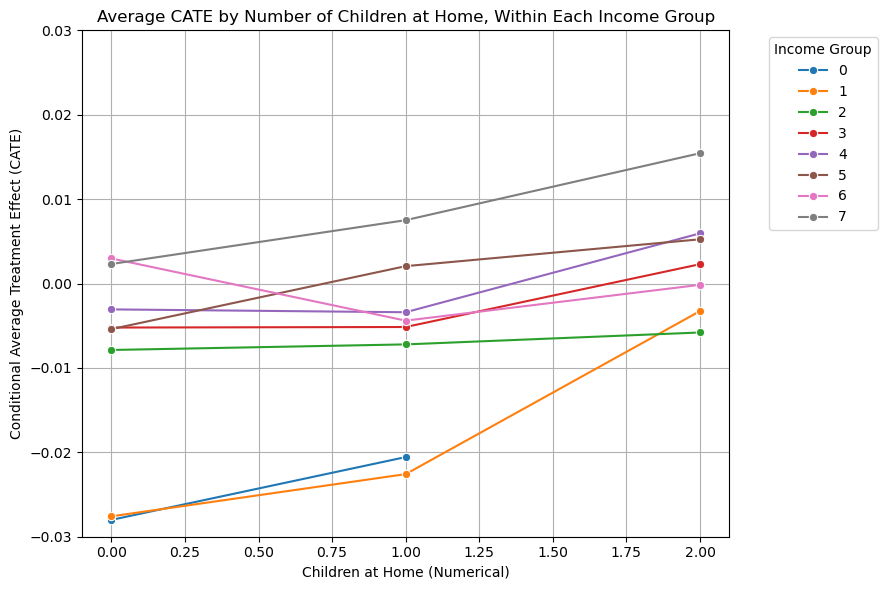

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by Income and Children count, compute average CATE
df_cate_by_income = (
    df_model
    .groupby(['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num'])['CATE']
    .mean()
    .reset_index()
)

# Plot using Seaborn
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=df_cate_by_income,
    x='CHILDREN_AT_HOME_num',
    y='CATE',
    hue='INCOME_CATEGORY_num',
    marker='o',
    palette='tab10'
)

# Labels and styling
plt.title("Average CATE by Number of Children at Home, Within Each Income Group")
plt.xlabel("Children at Home (Numerical)")
plt.ylabel("Conditional Average Treatment Effect (CATE)")
plt.grid(True)
plt.legend(title="Income Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.ylim(-0.03,0.03)
plt.show()


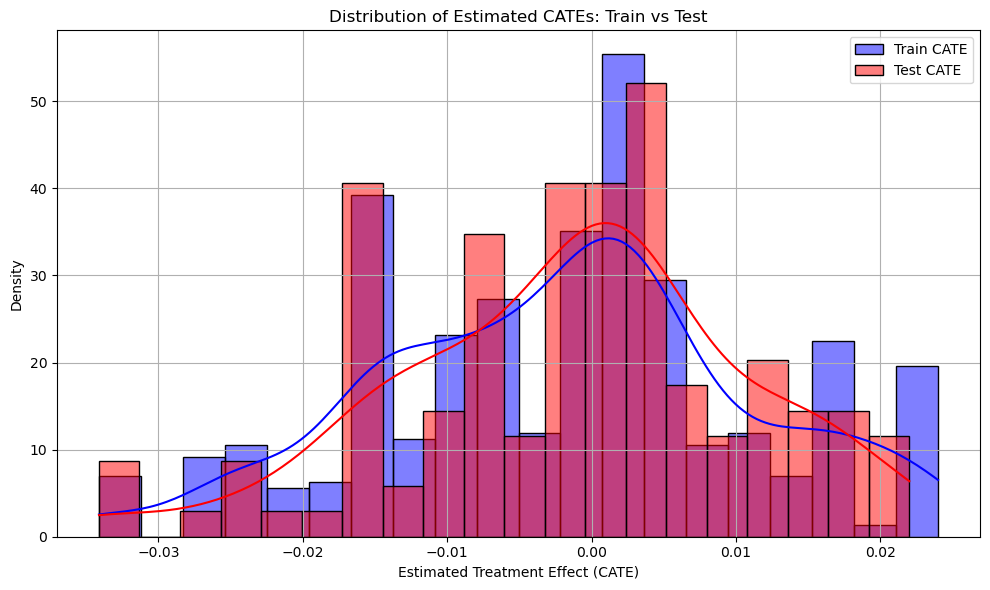

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define Variables
features = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']

import pandas as pd

# Step 1: Create dummies from the 'Cluster' column
cluster_dummies = pd.get_dummies(df_model['Cluster'], prefix='Cluster', drop_first=False)

# Step 2: Concatenate dummies to df_model
df_model_with_dummies = pd.concat([df_model, cluster_dummies], axis=1)

# Step 3: Select only the cluster dummy columns as features
cluster_dummy_features = cluster_dummies.columns.tolist()  # e.g., ['Cluster_0', 'Cluster_1', ...]
X = df_model_with_dummies[features]
T = df_model_with_dummies['Group']
Y = df_model_with_dummies['Delta']




# 2. Train/Test Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

model_y = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)

# model T -> uses features to predict the treatment T
model_t = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)


cf = CausalForestDML(
    model_y=model_y,           # see above
    model_t=model_t,           # see above
    n_estimators=500,          # Number of trees in the forest
    max_depth=10,              # Max depth of each tree
    min_samples_leaf=5,        # Min samples required in a leaf
    max_samples=0.5,           # Fraction of samples to use for each tree
    discrete_treatment=True,   # Binary treatment
    cv=5,                      # 5-fold cross-fitting
    honest=True,               # 'honest' splitting separates data used for node splitting and treatment effect measurement
    criterion='mse',           # splitting criterion maximises heterogeneity score; could also use 'mse'
    random_state=1
)

cf.fit(Y_train, T_train, X=X_train)
# 4. Estimate CATE on both sets
cate_train = cf.effect(X_train)
cate_test = cf.effect(X_test)

# 5. Plot Distributions
plt.figure(figsize=(10, 6))
sns.histplot(cate_train, color='blue', label='Train CATE', kde=True, stat="density",bins=20)
sns.histplot(cate_test, color='red', label='Test CATE', kde=True, stat="density",bins=20)
plt.title("Distribution of Estimated CATEs: Train vs Test")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim()
plt.show()

# 6. Add to dataframe for downstream use (optional)
df_model_train = X_train.copy()
df_model_test = X_test.copy()
df_model_train['CATE'] = cate_train
df_model_test['CATE'] = cate_test


# achieved X MSE (treatment effect) using CF only socio features
# now i added this clusters, do we improve?


   Cluster  Average_CATE
0      0.0     -0.003388
1      1.0     -0.007009
2      2.0     -0.000682
3      3.0      0.005752
4      4.0      0.002764
5      5.0     -0.016369
6      6.0      0.000271




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



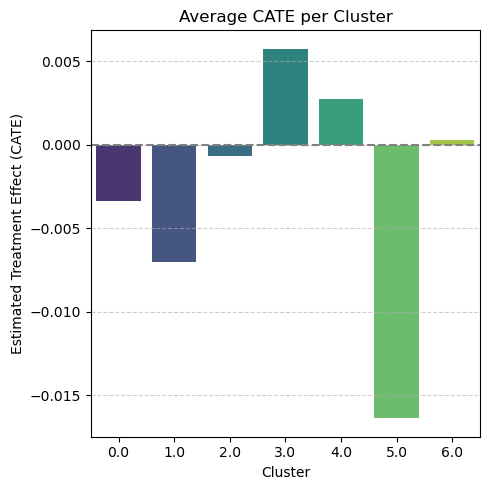

In [ ]:
# 7. Add Cluster labels back (we need these for grouping)
df_model_train['Cluster'] = df_model.loc[X_train.index, 'Cluster'].values
df_model_test['Cluster'] = df_model.loc[X_test.index, 'Cluster'].values

# 8. Combine and compute average CATE per cluster
df_model_all = pd.concat([df_model_train, df_model_test], ignore_index=True)

# 9. Compute average CATE by cluster
cluster_avg_cate = df_model_all.groupby('Cluster')['CATE'].mean().reset_index()
cluster_avg_cate.columns = ['Cluster', 'Average_CATE']
print(cluster_avg_cate)

# Optional: Plot
plt.figure(figsize=(5, 5))
sns.barplot(data=cluster_avg_cate, x='Cluster', y='Average_CATE', palette='viridis')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Average CATE per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Estimated Treatment Effect (CATE)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


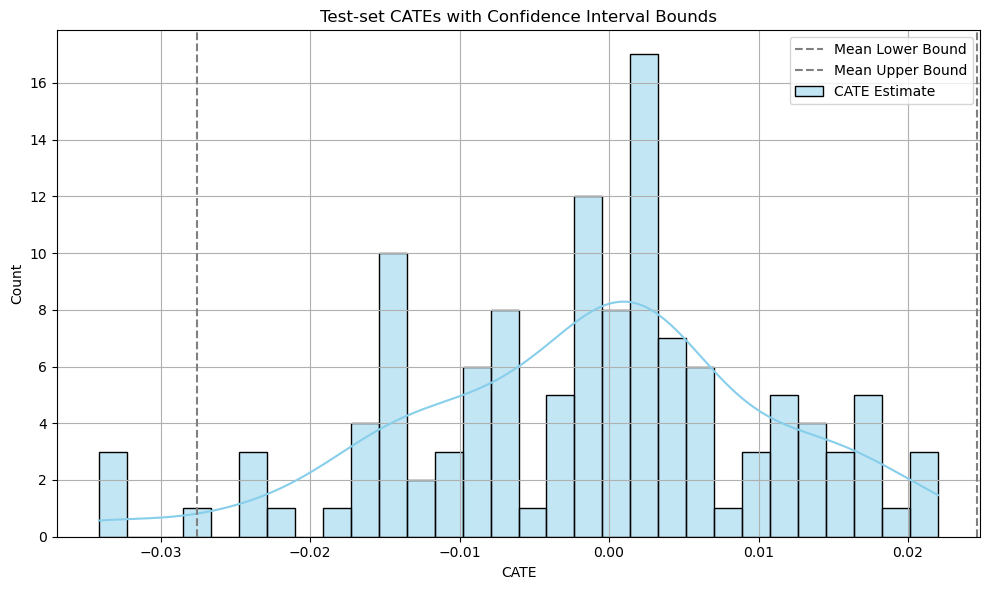

In [ ]:
# 1.1 Confidence Intervals on CATE for Test Set
intervals_test = cf.effect_interval(X_test)
lower_bound, upper_bound = intervals_test

# 1.2 Add to test dataframe
df_model_test['CATE_lower'] = lower_bound
df_model_test['CATE_upper'] = upper_bound

# 1.3 Plot CATEs with Confidence Intervals
plt.figure(figsize=(10, 6))
sns.histplot(df_model_test['CATE'], bins=30, kde=True, color='skyblue', label='CATE Estimate')
plt.axvline(x=df_model_test['CATE_lower'].mean(), color='gray', linestyle='--', label='Mean Lower Bound')
plt.axvline(x=df_model_test['CATE_upper'].mean(), color='gray', linestyle='--', label='Mean Upper Bound')
plt.title("Test-set CATEs with Confidence Interval Bounds")
plt.xlabel("CATE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Predicted treatment effect (CATE) × actual treatment assignment
X_r = T_test.values.reshape(-1, 1) * cate_test.reshape(-1, 1)

# Fit a linear model to predict outcome Y using estimated treatment effects
lr = LinearRegression()
lr.fit(X_r, Y_test)

# Predict Y using this linear model
Y_pred = lr.predict(X_r)

# R² for how much of the outcome is explained by CATEs
r2 = r2_score(Y_test, Y_pred)
print(f"R² (Y ~ CATE * T): {r2:.4f}")


R² (Y ~ CATE * T): 0.0010


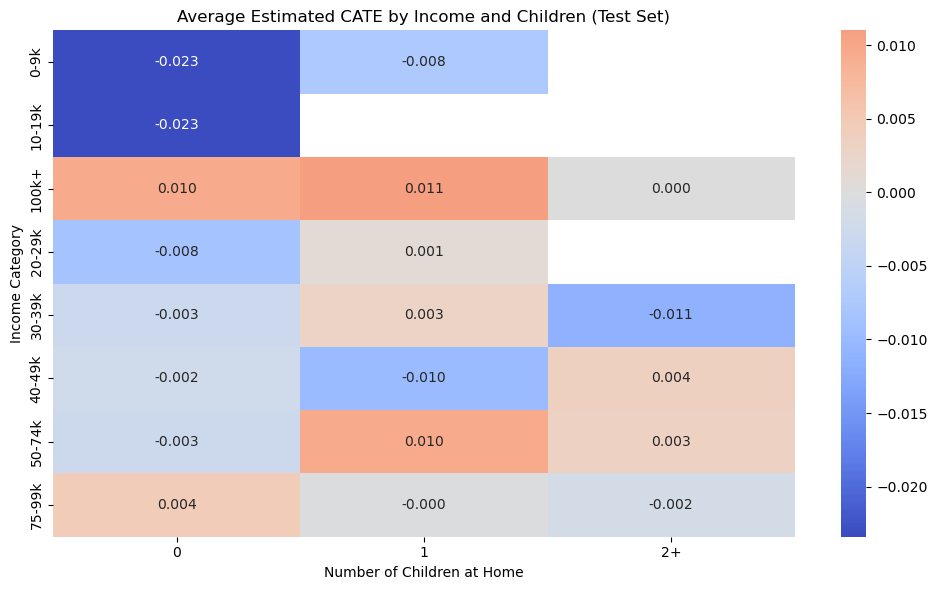

In [ ]:
# 3.1 Map categorical labels back (optional for readability)
income_map = {
    0: '0-9k', 1: '10-19k', 2: '20-29k', 3: '30-39k',
    4: '40-49k', 5: '50-74k', 6: '75-99k', 7: '100k+'
}
children_map = {0: '0', 1: '1', 2: '2+'}

df_model_test['Income'] = df_model_test['INCOME_CATEGORY_num'].map(income_map)
df_model_test['Children'] = df_model_test['CHILDREN_AT_HOME_num'].map(children_map)

# 3.2 Grouped Summary
summary = df_model_test.groupby(['Income', 'Children'])['CATE'].agg(['mean', 'count']).reset_index()

# 3.3 Heatmap
pivot = df_model_test.pivot_table(index='Income', columns='Children', values='CATE', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='coolwarm', center=0)
plt.title("Average Estimated CATE by Income and Children (Test Set)")
plt.ylabel("Income Category")
plt.xlabel("Number of Children at Home")
plt.tight_layout()
plt.show()


# Complete Model

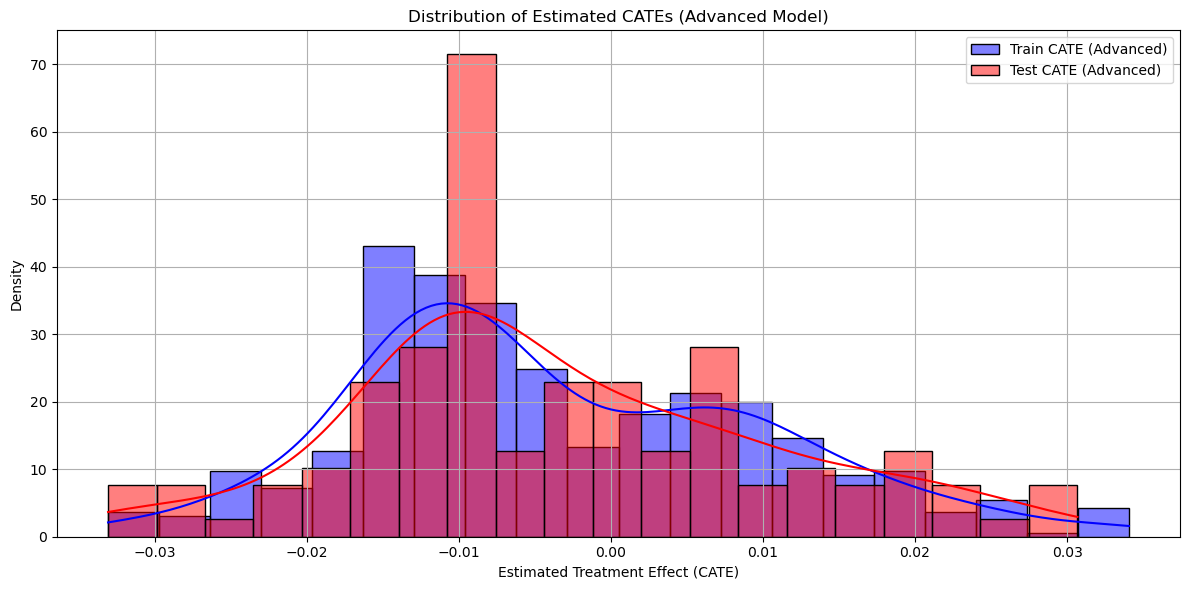

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt
import seaborn as sns

# One-hot encode AGE_GROUP
df_model_encoded = pd.get_dummies(df_model, columns=['AGE_GROUP'], drop_first=True)
feature_cols_advanced = [
    'INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num',
    'HOUSEHOLD_SIZE_num', 'NUMBER_OF_BEDROOMS_num',
    'HIGHEST_QUALIFICATION_num',  'SOCIAL_GRADE_num',
    'HOME_VALUE_num'
]

# Define features
#feature_cols_advanced = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']
age_cols = [col for col in df_model_encoded.columns if col.startswith('AGE_GROUP_')]
X_advanced = df_model_encoded[feature_cols_advanced + age_cols]
T_advanced = df_model_encoded['Group']
Y_advanced = df_model_encoded['Delta']

# Split
X_train_adv, X_test_adv, T_train_adv, T_test_adv, Y_train_adv, Y_test_adv = train_test_split(
    X_advanced, T_advanced, Y_advanced, test_size=0.2, random_state=42
)

# Causal Forest setup
model_y_adv = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)
model_t_adv = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)

cf_advanced = CausalForestDML(
    model_y=model_y_adv,
    model_t=model_t_adv,
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    max_samples=0.5,
    discrete_treatment=True,
    cv=5,
    honest=True,
    criterion='mse',
    random_state=1
)

cf_advanced.fit(Y_train_adv, T_train_adv, X=X_train_adv)

# Estimate CATE
cate_train_adv = cf_advanced.effect(X_train_adv)
cate_test_adv = cf_advanced.effect(X_test_adv)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(cate_train_adv, color='blue', label='Train CATE (Advanced)', kde=True, stat="density", bins=20)
sns.histplot(cate_test_adv, color='red', label='Test CATE (Advanced)', kde=True, stat="density", bins=20)
plt.title("Distribution of Estimated CATEs (Advanced Model)")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


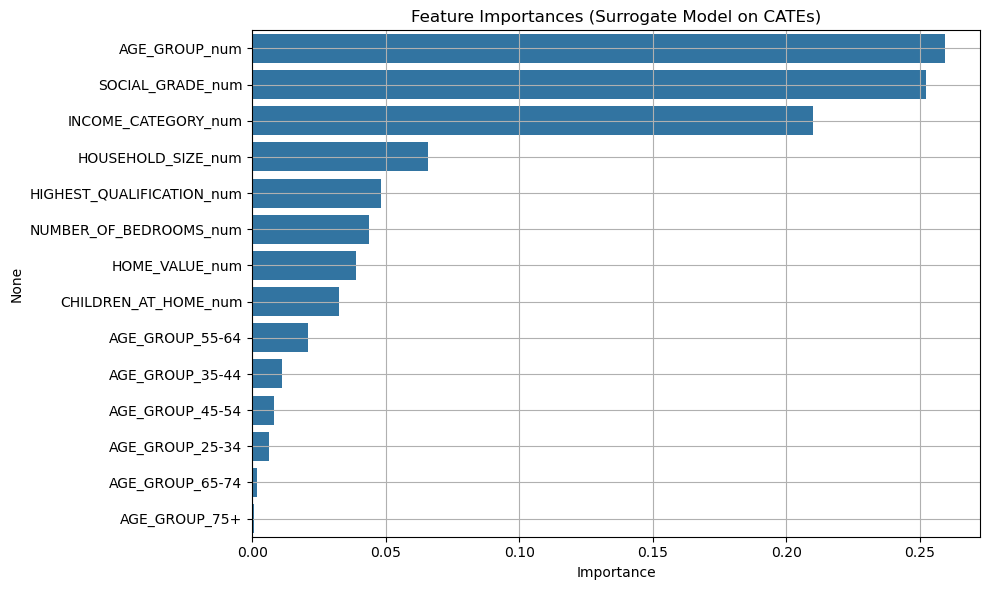

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Fit surrogate model
surrogate_model = RandomForestRegressor(random_state=42)
surrogate_model.fit(X_train_adv, cate_train_adv)

# Feature importances
importances = surrogate_model.feature_importances_
feat_importances = pd.Series(importances, index=X_train_adv.columns).sort_values(ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature Importances (Surrogate Model on CATEs)")
plt.xlabel("Importance")
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict Y using τ̂(X) * T as proxy for treatment contribution
# This is not the same as full outcome prediction but helps understand explanatory power of τ̂
y_hat_test = cate_test_adv * T_test_adv
pseudo_rmse = np.sqrt(mean_squared_error(Y_test_adv, y_hat_test))
print(f"Pseudo RMSE (CATE × T vs. Y): {pseudo_rmse:.4f}")


Pseudo RMSE (CATE × T vs. Y): 0.0518


# Evaluation of models

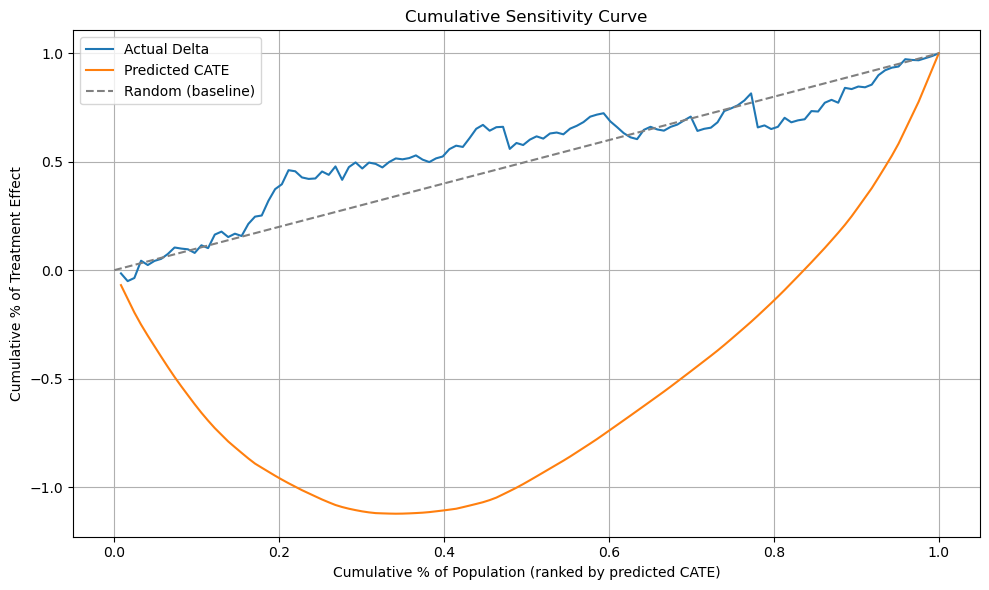

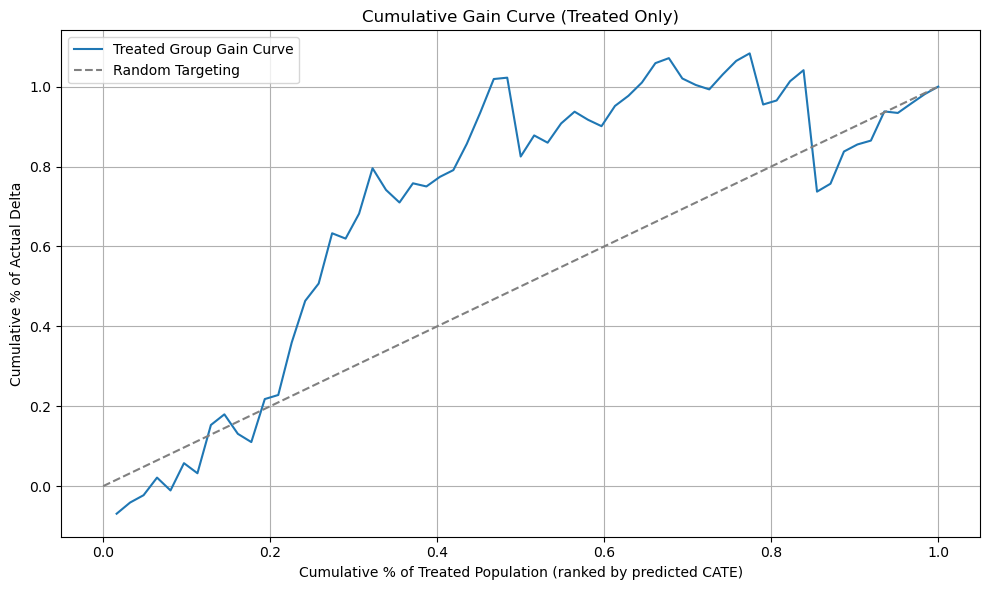

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# Combine test set data
# -------------------------------------------
df_eval = X_test_adv.copy()
df_eval['CATE'] = cate_test_adv
df_eval['Delta'] = Y_test_adv
df_eval['Treatment'] = T_test_adv

# -------------------------------------------
# Sort by CATE (descending): households with strongest predicted effect first
# -------------------------------------------
df_sorted = df_eval.sort_values(by='CATE', ascending=False).reset_index(drop=True)
df_sorted['Cumulative_Count'] = np.arange(1, len(df_sorted)+1)

# -------------------------------------------
# Cumulative Sensitivity: sum of actual effects (Delta) across percentiles
# -------------------------------------------
df_sorted['Cumulative_Actual_Effect'] = df_sorted['Delta'].cumsum()
df_sorted['Cumulative_Predicted_Effect'] = df_sorted['CATE'].cumsum()

# Normalize by total sum to get % of effect captured
total_actual = df_sorted['Delta'].sum()
total_pred = df_sorted['CATE'].sum()
df_sorted['%_Actual_Effect'] = df_sorted['Cumulative_Actual_Effect'] / total_actual
df_sorted['%_Predicted_Effect'] = df_sorted['Cumulative_Predicted_Effect'] / total_pred
df_sorted['% Population'] = df_sorted['Cumulative_Count'] / len(df_sorted)

# -------------------------------------------
# PLOT: Cumulative Sensitivity Curve
# -------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x='% Population', y='%_Actual_Effect', data=df_sorted, label='Actual Delta')
sns.lineplot(x='% Population', y='%_Predicted_Effect', data=df_sorted, label='Predicted CATE')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random (baseline)')
plt.xlabel('Cumulative % of Population (ranked by predicted CATE)')
plt.ylabel('Cumulative % of Treatment Effect')
plt.title('Cumulative Sensitivity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------------------------
# Cumulative Gain: uplift modeling performance
# -------------------------------------------
df_treated = df_sorted[df_sorted['Treatment'] == 1].copy()
df_control = df_sorted[df_sorted['Treatment'] == 0].copy()

# Rank by CATE in treated group
df_treated = df_treated.sort_values(by='CATE', ascending=False).reset_index(drop=True)
df_treated['Rank'] = np.arange(1, len(df_treated)+1)
df_treated['% Population'] = df_treated['Rank'] / len(df_treated)
df_treated['Cumulative Effect'] = df_treated['Delta'].cumsum()
df_treated['% Cumulative Effect'] = df_treated['Cumulative Effect'] / df_treated['Delta'].sum()

# -------------------------------------------
# PLOT: Cumulative Gain Curve
# -------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x='% Population', y='% Cumulative Effect', data=df_treated, label='Treated Group Gain Curve')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random Targeting')
plt.xlabel('Cumulative % of Treated Population (ranked by predicted CATE)')
plt.ylabel('Cumulative % of Actual Delta')
plt.title('Cumulative Gain Curve (Treated Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



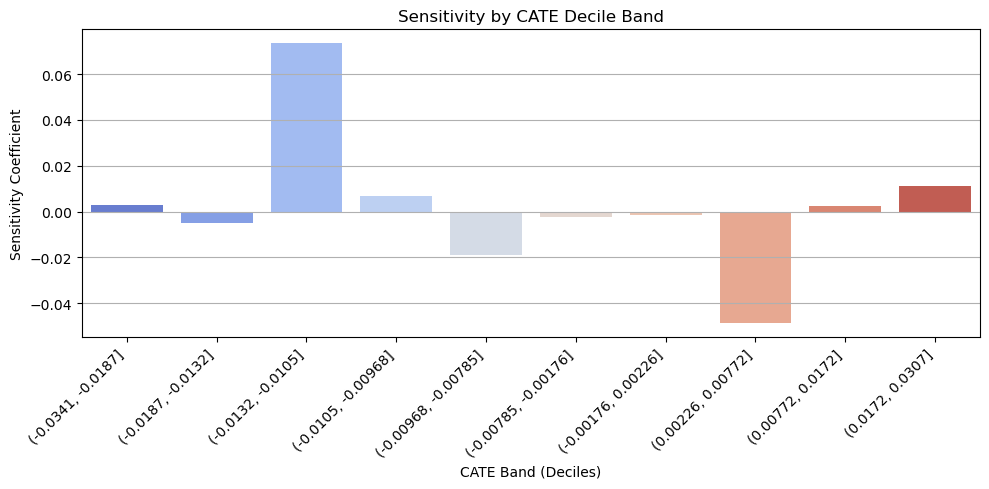

In [ ]:
import pandas as pd
import numpy as np
from toolz import curry
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Define Sensitivity Function
# -----------------------------
@curry
def sensitivity(data, y, t):
    return (np.sum((data[t] - data[t].mean()) * (data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band": pd.qcut(df[pred], q=bands, duplicates='drop')})
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))
            .reset_index(name='Sensitivity'))

# -----------------------------
# 2. Prepare Data
# -----------------------------
df_sens = X_test_adv.copy()
df_sens['CATE'] = cate_test_adv
df_sens['Delta'] = Y_test_adv
df_sens['Treatment'] = T_test_adv

# -----------------------------
# 3. Compute Sensitivity by CATE Band
# -----------------------------
sensitivity_results = sensitivity_by_band(df_sens, pred='CATE', y='Delta', t='Treatment', bands=10)

# -----------------------------
# 4. Plot Sensitivity by CATE Band
# -----------------------------
plt.figure(figsize=(10, 5))
sns.barplot(data=sensitivity_results, x='CATE_band', y='Sensitivity', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Sensitivity by CATE Decile Band')
plt.ylabel('Sensitivity Coefficient')
plt.xlabel('CATE Band (Deciles)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# ╭──────────────────────────────────────────────────────────────╮
# │   EVALUATION FUNCTIONS                                       │
# ╰──────────────────────────────────────────────────────────────╯

def cumulative_sensitivity(df, cate_col='CATE', outcome_col='Delta', treatment_col='Treatment'):
    # Sort by CATE descending (i.e., rank people from highest to lowest estimated effect)
    df_sorted = df.sort_values(by=cate_col, ascending=False).copy()

    # Initialize lists
    sens_list = []
    frac_list = []

    for i in range(1, len(df_sorted)+1):
        # Take top i rows
        sub_df = df_sorted.iloc[:i]
        # Compute sensitivity
        sens = sensitivity(sub_df, y=outcome_col, t=treatment_col)
        sens_list.append(sens)
        frac_list.append(i / len(df_sorted))

    return pd.DataFrame({'Fraction': frac_list, 'CumulativeSensitivity': sens_list})

def cumulative_gain(df, prediction='CATE', y='Delta', t='Group', min_periods=30, steps=100):
    size = df.shape[0]
    df_sorted = df.sort_values(prediction, ascending=False).reset_index(drop=True)

    # Avoid zero step size in range
    step_size = max(1, size // steps)
    n_rows = list(range(min_periods, size, step_size)) + [size]

    return np.array([
        sensitivity(df_sorted.head(rows), y=y, t=t) * (rows / size)
        for rows in n_rows
    ])


def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1 * df[t])
    se = np.sqrt(((1 / (n - 2)) * np.sum(e**2)) / np.sum((df[t] - t_bar)**2))
    return np.array([beta1 - z * se, beta1 + z * se])  # ✅ fixed `see` → `se`


def cumulative_sensitivity_curve_ci(df, prediction='CATE', y='Delta', t='Group', min_periods=30, steps=100):
    size = df.shape[0]
    df_sorted = df.sort_values(prediction, ascending=False).reset_index(drop=True)

    step_size = max(1, size // steps)
    n_rows = list(range(min_periods, size, step_size)) + [size]

    return np.array([
        sensitivity_ci(df_sorted.head(rows), y=y, t=t)
        for rows in n_rows
    ])




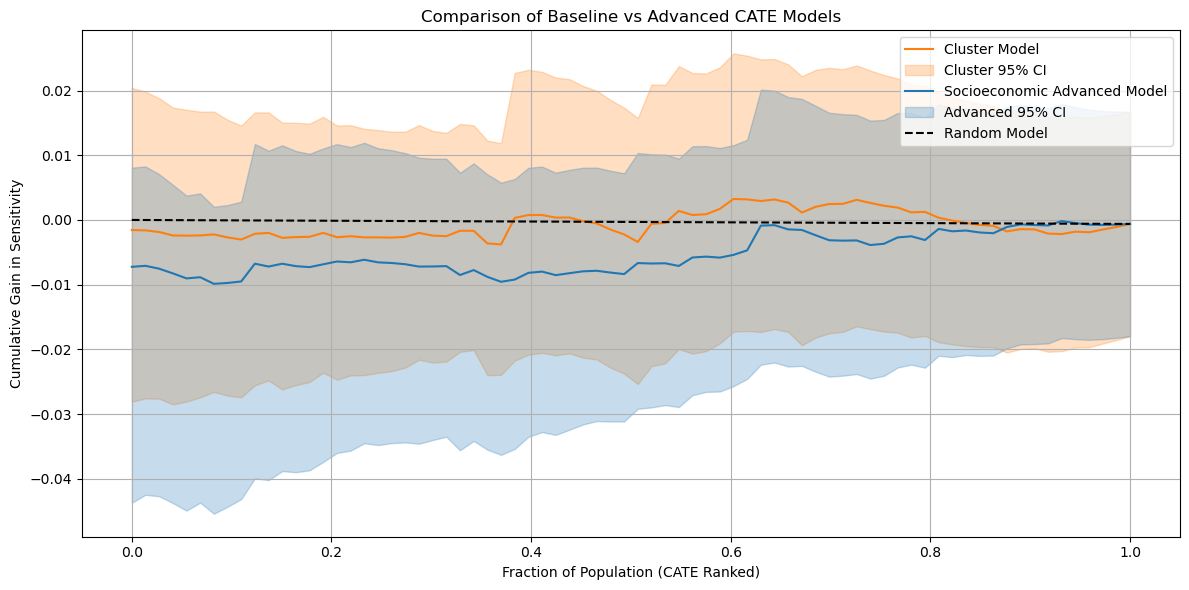

In [ ]:
# 1 Create models

# Create baseline test set (if not already)
df_model_test_base = X_test.copy()
df_model_test_base['Group'] = T_test
df_model_test_base['Delta'] = Y_test
df_model_test_base['CATE'] = cate_test  # <- from the baseline model


# Create advanced test set
df_model_test = X_test_adv.copy()
df_model_test['Group'] = T_test_adv
df_model_test['Delta'] = Y_test_adv
df_model_test['CATE'] = cate_test_adv

import numpy as np
import matplotlib.pyplot as plt

# 1. Compute cumulative gain for both models
cum_gain_base = cumulative_gain(df_model_test_base, "CATE", "Delta", "Group", min_periods=50, steps=200)
cum_gain_adv = cumulative_gain(df_model_test, "CATE", "Delta", "Group", min_periods=50, steps=200)

# 2. Compute confidence intervals
cum_gain_ci_base = cumulative_sensitivity_curve_ci(df_model_test_base, "CATE", "Delta", "Group", min_periods=50, steps=200)
cum_gain_ci_adv = cumulative_sensitivity_curve_ci(df_model_test, "CATE", "Delta", "Group", min_periods=50, steps=200)

# 3. Define x-axis (normalized rank)
x_vals = np.linspace(0, 1, len(cum_gain_base))

# 4. Plot
plt.figure(figsize=(12, 6))
plt.plot(x_vals, cum_gain_base, label="Cluster Model", color="C1")
plt.fill_between(x_vals, cum_gain_ci_base[:, 0], cum_gain_ci_base[:, 1], alpha=0.25, color="C1", label="Cluster 95% CI")

plt.plot(x_vals, cum_gain_adv, label="Socioeconomic Advanced Model", color="C0")
plt.fill_between(x_vals, cum_gain_ci_adv[:, 0], cum_gain_ci_adv[:, 1], alpha=0.25, color="C0", label="Advanced 95% CI")

# Reference line
baseline_sens = sensitivity(df_model_test_base, y='Delta', t='Group')
plt.plot([0, 1], [0, baseline_sens], linestyle='--', color='black', label='Random Model')

# Formatting
plt.xlabel("Fraction of Population (CATE Ranked)")
plt.ylabel("Cumulative Gain in Sensitivity")
plt.title("Comparison of Baseline vs Advanced CATE Models")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### Comparison of Cluster-Only vs Socioeconomic Advanced CATE Models

The plot above displays cumulative gain in sensitivity for two CATE models:
- **Cluster Model (orange)**: This baseline model uses only the counterfactual clusters (derived from energy usage profiles) as features.
- **Socioeconomic Advanced Model (blue)**: This model incorporates selected socioeconomic variables—`INCOME_CATEGORY`, `CHILDREN_AT_HOME`, and others—chosen for their relevance to behavioral energy consumption.

#### Interpretation:

- **Cumulative Gain Curve**: Measures how well the model identifies individuals for whom the treatment (intervention) had the largest effect on consumption. Higher cumulative gain suggests better ranking of treatment effect heterogeneity.
- **Confidence Bands (95%)**: Indicate uncertainty around each model's gain estimate at different fractions of the population.

#### Key Observations:

- The **Cluster Model** shows a slightly higher cumulative gain than the socioeconomic model across most of the population, suggesting that usage-based clusters alone offer meaningful structure for targeting.
- The **Socioeconomic Model** exhibits more stability in the gain curve and less deviation from the random baseline, which may reflect a more conservative ranking of treatment effect heterogeneity.
- Both models outperform the **Random Model** baseline (dashed line), meaning they are learning signal beyond noise.

#### Conclusion:

The cluster-only model provides slightly better targeting performance in terms of treatment effect sensitivity, though its confidence interval overlaps significantly with the socioeconomic model. The socioeconomic model may offer better interpretability and fairness. Depending on program goals (e.g., targeting vs understanding), either could be preferable. Future work could explore **hybrid models** that combine both sets of features for improved performance.


invalid value encountered in scalar divide


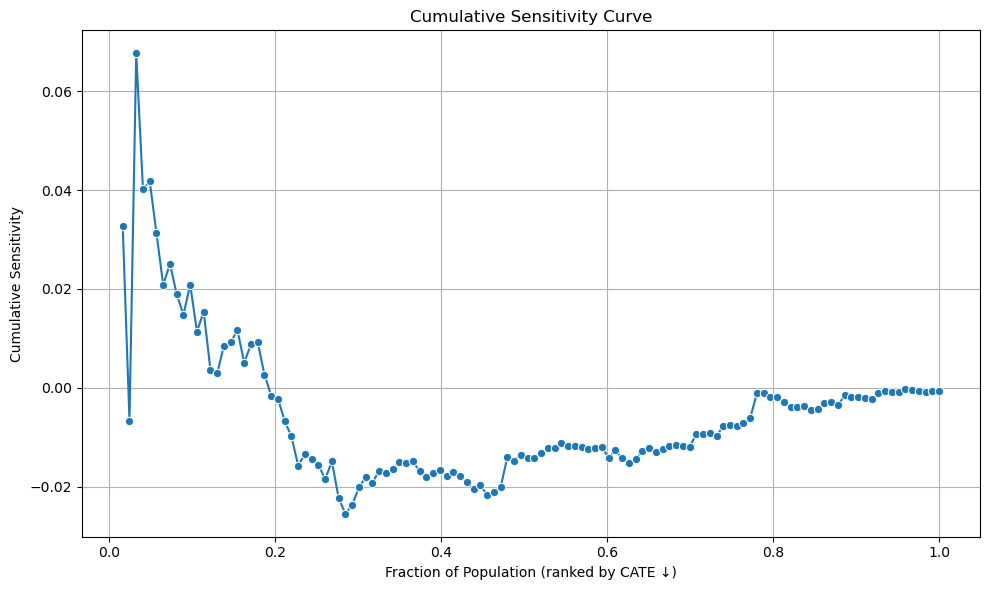

In [ ]:
# Compute and Plot
cum_sens_df = cumulative_sensitivity(df_sens, cate_col='CATE', outcome_col='Delta', treatment_col='Treatment')

plt.figure(figsize=(10, 6))
sns.lineplot(data=cum_sens_df, x='Fraction', y='CumulativeSensitivity', marker='o')
plt.title("Cumulative Sensitivity Curve")
plt.xlabel("Fraction of Population (ranked by CATE ↓)")
plt.ylabel("Cumulative Sensitivity")
plt.grid(True)
plt.tight_layout()
plt.show()


R Learner

📊 R-Learner Pseudo RMSE: 0.0504


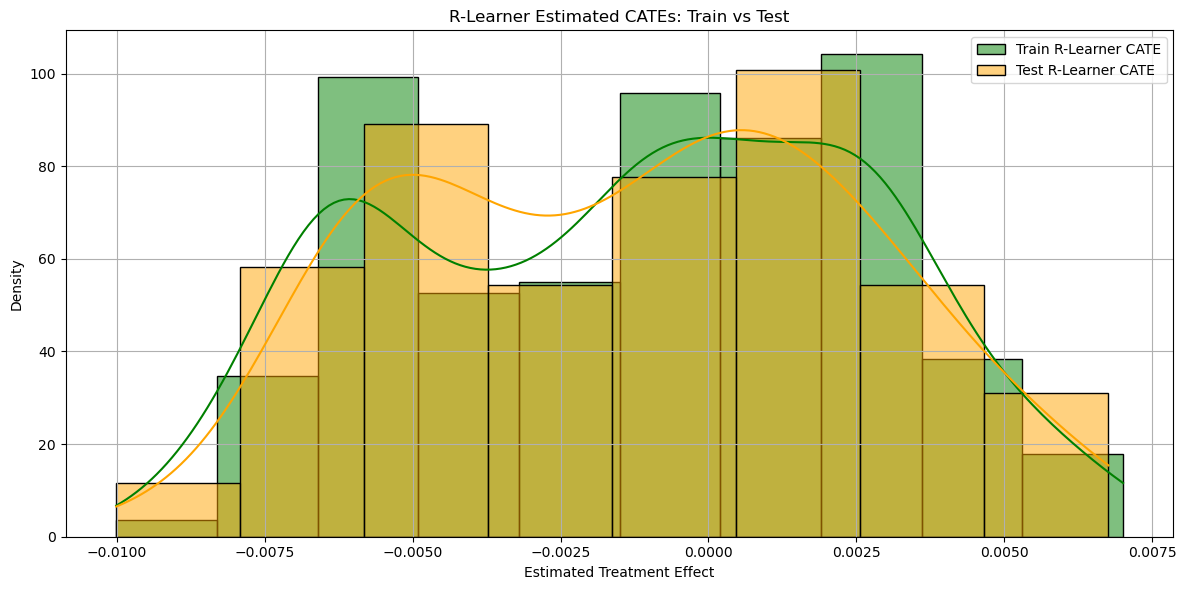

In [ ]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define Features and Split
features = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']  # Add more if needed
X = df_model[features]
T = df_model['Group']
Y = df_model['Delta']

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

# 2. Instantiate and Fit R-Learner using LinearDML
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)

rlearner = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True, random_state=42)
rlearner.fit(Y_train, T_train, X=X_train)

# 3. Predict CATE
cate_r_train = rlearner.effect(X_train)
cate_r_test = rlearner.effect(X_test)

# 4. Pseudo RMSE as diagnostic
rms_rlearner = np.sqrt(np.mean((T_test * cate_r_test - Y_test) ** 2))
print(f"📊 R-Learner Pseudo RMSE: {rms_rlearner:.4f}")

# 5. Visualization
plt.figure(figsize=(12, 6))
sns.histplot(cate_r_train, color='green', label='Train R-Learner CATE', kde=True, stat="density")
sns.histplot(cate_r_test, color='orange', label='Test R-Learner CATE', kde=True, stat="density")
plt.title("R-Learner Estimated CATEs: Train vs Test")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_model_test['CATE'] = cate_test
grouped = df_model_test.groupby('Cluster')['CATE'].agg(['mean', 'std', 'count'])
print(grouped.sort_values('mean'))


KeyError: 'Cluster'

In [ ]:
sns.barplot(data=df_model_test, x='INCOME_CATEGORY_num', y='CATE')
sns.barplot(data=df_model_test, x='CHILDREN_AT_HOME_num', y='CATE')


# FIXED EFFECTS